<a href="https://colab.research.google.com/github/adityaasunil/MAESeg/blob/main/MAE_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Datasets/images.zip -d /content/drive/MyDrive/dataset_images

Archive:  /content/drive/MyDrive/Datasets/images.zip
   creating: /content/drive/MyDrive/dataset_images/images/
  inflating: /content/drive/MyDrive/dataset_images/__MACOSX/._images  
  inflating: /content/drive/MyDrive/dataset_images/images/.DS_Store  
  inflating: /content/drive/MyDrive/dataset_images/__MACOSX/images/._.DS_Store  
   creating: /content/drive/MyDrive/dataset_images/images/test/
  inflating: /content/drive/MyDrive/dataset_images/__MACOSX/images/._test  
   creating: /content/drive/MyDrive/dataset_images/images/train/
  inflating: /content/drive/MyDrive/dataset_images/__MACOSX/images/._train  
   creating: /content/drive/MyDrive/dataset_images/images/test/image/
  inflating: /content/drive/MyDrive/dataset_images/__MACOSX/images/test/._image  
   creating: /content/drive/MyDrive/dataset_images/images/test/mask/
  inflating: /content/drive/MyDrive/dataset_images/__MACOSX/images/test/._mask  
   creating: /content/drive/MyDrive/dataset_images/images/train/image/
  inflating

In [ ]:
import kagglehub

path = kagglehub.dataset_download('mariaherrerot/aptos2019')

print("Path to dataset files: ", path)

Using Colab cache for faster access to the 'aptos2019' dataset.
Path to dataset files:  /kaggle/input/aptos2019


In [ ]:
import torch, torchvision
import argparse as arg
import random
import os,sys
import torch.nn as N
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import albumentations as A
from albumentations.pytorch import ToTensorV2
import gc
import tqdm
from einops import rearrange
import timm
from pathlib import Path

In [ ]:
def clear_memory():
  gc.collect()
  if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

In [ ]:
# utils

def denorm(tensor, mean=(0.5), std=(0.5)):
  tensor = tensor.detach().cpu()
  tensor = tensor * std + mean

  if tensor.ndim == 2:
    return tensor.numpy()
  elif tensor.ndim == 3:
    if tensor.shape[0] == 1:
      return tensor.squeeze(0).numpy()
    else:
      return tensor.permute(1,2,0).numpy()
  elif tensor.ndim == 4:
    if tensor.shape[1] == 1:
      return tensor.squeeze(1).numpy()
    else:
      return tensor.permute(0,2,3,1).numpy()

In [ ]:
# transform

def get_transforms(split):
  if split == 'train':
    return A.Compose([
      A.Resize(512,512),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.Rotate(limit=30, border_mode=cv2.BORDER_CONSTANT, p=0.5),
      A.Normalize(mean=(0.5,), std=(0.5,)),
      ToTensorV2(),
  ])
  else:
    return A.Compose([
        A.Resize(512,512),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])

/tmp/ipython-input-73974359.py:9: UserWarning: Argument(s) 'value, mask_value' are not valid for transform Rotate
  A.Rotate(limit=30, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.5),


Amount of images: 3376
torch.Size([1, 512, 512])


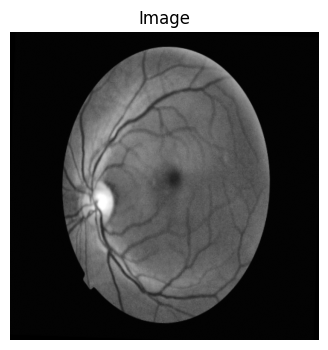

In [ ]:
# pre-training script
class UnlabelledTrainingDataset(torch.utils.data.Dataset):
  def __init__(self, img_size:int=512):
    super().__init__()

    self.image_size = 512
    self.IMAGE_PATH_1 = '/kaggle/input/aptos2019/train_images/train_images'
    self.IMAGE_PATH_2 = '/content/images/images/train/image'
    self.IMAGE_PATH_3 = '/kaggle/input/aptos2019/val_images/val_images'

    self.image_paths = []
    self.transforms = get_transforms('train')
    self.image_dirs = [self.IMAGE_PATH_1, self.IMAGE_PATH_2, self.IMAGE_PATH_3]

    self.clahe = cv2.createCLAHE(2.0,(8,8))

    for dirs in self.image_dirs:
      for root, dirs, files in os.walk(dirs):
        for f in files:
          self.image_paths.append(os.path.join(root, f))

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img = cv2.imread(self.image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    green = img[:,:,1]
    applied_clahe = self.clahe.apply(green)
    combined = cv2.GaussianBlur(applied_clahe,(3,3),0.5)

    transformed = self.transforms(image=combined)
    img = transformed['image']

    return img

ds = UnlabelledTrainingDataset()

print('Amount of images: {}'.format(len(ds)))

img = ds[random.randint(0,len(ds)-1)]
print(img.shape)
img = denorm(img)

plt.figure(figsize=(10,4))
plt.axis('off')
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.show()


In [ ]:
"""
Improved MAE Models for Vessel Segmentation

Key improvements:
1. Fixed bugs in VesselFocusedMAELoss
2. Better initialization
3. Dropout support
4. Proper normalization
5. More efficient implementation
6. Added utility methods
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class PatchEmbedding(nn.Module):
    """
    Split image into patches and embed them

    Improvements:
    - Proper bias initialization
    - Optional normalization layer
    """

    def __init__(self, img_size=512, in_channels=1, embed_dim=768, patch_size=16, norm_layer=True):
        super().__init__()

        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Optional normalization after projection
        self.norm = nn.LayerNorm(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size}*{self.img_size})"

        x = self.proj(x)  # (B, embed_dim, H//P, W//P)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        x = self.norm(x)

        return x


def get_2d_sincos_pos_embed(embed_dim=768, grid_size=32, cls_token=False):
    """
    Generate 2D sinusoidal positional embeddings

    Args:
        embed_dim: dimension of the embedding
        grid_size: height and width of the grid
        cls_token: whether to include cls token

    Returns:
        pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (with cls_token)
    """
    grid_h = torch.arange(grid_size, dtype=torch.float32)
    grid_w = torch.arange(grid_size, dtype=torch.float32)
    grid = torch.meshgrid(grid_h, grid_w, indexing='ij')
    grid = torch.stack(grid, dim=0)  # (2, grid_size, grid_size)
    grid = grid.reshape(2, -1)  # (2, grid_size*grid_size)

    # Split embedding dimension between height and width
    assert embed_dim % 2 == 0, "embed_dim must be even for sincos positional embedding"
    half_dim = embed_dim // 2

    emb_h = get_1d_sincos_embed(half_dim, grid[0])  # (grid_size*grid_size, half_dim)
    emb_w = get_1d_sincos_embed(half_dim, grid[1])  # (grid_size*grid_size, half_dim)

    pos_embed = torch.cat([emb_h, emb_w], dim=1)  # (grid_size*grid_size, embed_dim)

    if cls_token:
        cls_pos_embed = torch.zeros(1, embed_dim)
        pos_embed = torch.cat([cls_pos_embed, pos_embed], dim=0)

    return pos_embed


def get_1d_sincos_embed(embed_dim, positions):
    """
    Generate 1D sinusoidal positional embeddings

    Args:
        embed_dim: dimension of embedding
        positions: positions to encode (tensor or array)

    Returns:
        pos_embed: (num_positions, embed_dim)
    """
    assert embed_dim % 2 == 0, "embed_dim must be even"
    half_dim = embed_dim // 2

    # Frequency bands
    freq = torch.exp(
        -math.log(10000.0) * torch.arange(half_dim, dtype=torch.float32) / half_dim
    )

    # Compute angles
    if isinstance(positions, torch.Tensor):
        angles = positions.unsqueeze(1) * freq.unsqueeze(0)
    else:
        angles = positions[:, None] * freq[None, :]

    # Apply sin and cos
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)

    return emb


class MultiHeadAttention(nn.Module):
    """
    Standard multi-head self attention

    Improvements:
    - Configurable attention dropout
    - Proper scaling
    - Optional QKV bias
    """

    def __init__(self, embed_dim, num_heads, dropout=0., qkv_bias=True, proj_bias=True):
        super().__init__()

        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=proj_bias)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, E = x.shape

        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Attention scores
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)

        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, E)
        x = self.proj(x)
        x = self.proj_dropout(x)

        return x


class MLP(nn.Module):
    """
    MLP block with GELU activation

    Improvements:
    - Configurable activation
    - Better dropout placement
    """

    def __init__(self, embed_dim, mlp_ratio=4., dropout=0., activation='gelu'):
        super().__init__()

        hidden_dim = int(embed_dim * mlp_ratio)

        self.fc1 = nn.Linear(embed_dim, hidden_dim)

        if activation == 'gelu':
            self.act = nn.GELU()
        elif activation == 'relu':
            self.act = nn.ReLU()
        else:
            raise ValueError(f"Unknown activation: {activation}")

        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class TransformerBlock(nn.Module):
    """
    One Transformer block = Attention + MLP with residual connections

    Improvements:
    - Pre-norm architecture (better for deep networks)
    - Drop path for regularization
    - Proper initialization
    """

    def __init__(self, embed_dim, num_heads, mlp_ratio=4., dropout=0.,
                 drop_path=0., qkv_bias=True):
        super().__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout, qkv_bias=qkv_bias)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_ratio, dropout)

        # Drop path for stochastic depth
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)
    """
    def __init__(self, drop_prob=0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x

        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        output = x.div(keep_prob) * random_tensor
        return output


class MAEEncoder(nn.Module):
    """
    MAE Encoder with improvements for vessel segmentation

    Improvements:
    - Better dropout schedule
    - Optional CLS token
    - More flexible masking
    """

    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_channels=1,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.,
        dropout=0.,
        drop_path_rate=0.,
        qkv_bias=True,
        norm_layer=True
    ):
        super().__init__()

        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size, in_channels, embed_dim, patch_size, norm_layer
        )

        # Positional embedding (fixed, not learned)
        pos_embed = get_2d_sincos_pos_embed(embed_dim, img_size // patch_size)
        self.register_buffer('pos_embed', pos_embed.unsqueeze(0))

        # Stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim, num_heads, mlp_ratio, dropout,
                drop_path=dpr[i], qkv_bias=qkv_bias
            )
            for i in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Initialize weights"""
        if isinstance(m, nn.Linear):
            torch.nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            torch.nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def random_masking(self, x, mask_ratio=0.5):
        """
        Randomly mask patches

        Args:
            x: (B, N, E) - batch of patch embeddings
            mask_ratio: fraction to mask (e.g., 0.5 for 50%)

        Returns:
            x_visible: (B, N_visible, E) - visible patches
            mask: (B, N) - binary mask (1 = masked, 0 = visible)
            ids_restore: (B, N) - indices to restore original order
        """
        B, N, E = x.shape
        num_keep = int(N * (1 - mask_ratio))

        # Generate random noise
        noise = torch.rand(B, N, device=x.device)

        # Sort by noise to get random permutation
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # Keep first num_keep patches
        ids_keep = ids_shuffle[:, :num_keep]

        # Gather visible patches
        x_visible = torch.gather(
            x, dim=1,
            index=ids_keep.unsqueeze(-1).expand(-1, -1, E)
        )

        # Generate binary mask: 0 is keep, 1 is remove
        mask = torch.ones(B, N, device=x.device)
        mask[:, :num_keep] = 0
        # Unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_visible, mask, ids_restore

    def forward(self, x, mask_ratio=0.5):
        """
        Forward pass with masking

        Args:
            x: (B, C, H, W) - input images
            mask_ratio: fraction of patches to mask

        Returns:
            x: (B, N_visible, E) - encoded visible patches
            mask: (B, N) - binary mask
            ids_restore: (B, N) - indices to restore order
        """
        # Patch embedding
        x = self.patch_embed(x)  # (B, N, E)

        # Add positional embedding
        x = x + self.pos_embed

        # Random masking
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        return x, mask, ids_restore


class MAEDecoder(nn.Module):
    """
    MAE Decoder with improvements

    Improvements:
    - Better mask token initialization
    - More flexible architecture
    - Optional skip connections (for segmentation)
    """

    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_channels=1,
        embed_dim=768,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.,
        dropout=0.
    ):
        super().__init__()

        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.decoder_embed_dim = decoder_embed_dim

        # Project encoder output to decoder dimension
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        # Mask token
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        nn.init.normal_(self.mask_token, std=0.02)

        # Positional embedding for decoder
        decoder_pos_embed = get_2d_sincos_pos_embed(
            decoder_embed_dim, img_size // patch_size
        )
        self.register_buffer('decoder_pos_embed', decoder_pos_embed.unsqueeze(0))

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                decoder_embed_dim, decoder_num_heads, mlp_ratio, dropout
            )
            for _ in range(decoder_depth)
        ])

        self.norm = nn.LayerNorm(decoder_embed_dim)

        # Prediction head
        self.pred = nn.Linear(
            decoder_embed_dim,
            patch_size ** 2 * in_channels,
            bias=True
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Initialize weights"""
        if isinstance(m, nn.Linear):
            torch.nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x, ids_restore):
        """
        Decode masked patches

        Args:
            x: (B, N_visible, E) - encoded visible patches
            ids_restore: (B, N) - indices to restore original order

        Returns:
            x: (B, N, patch_size**2 * C) - predicted patches
        """
        B, N_visible, _ = x.shape
        N = ids_restore.shape[1]

        # Project to decoder dimension
        x = self.decoder_embed(x)

        # Append mask tokens
        mask_tokens = self.mask_token.expand(B, N - N_visible, -1)
        x = torch.cat([x, mask_tokens], dim=1)  # (B, N, decoder_embed_dim)

        # Unshuffle to restore original order
        x = torch.gather(
            x, dim=1,
            index=ids_restore.unsqueeze(-1).expand(-1, -1, x.shape[-1])
        )

        # Add positional embedding
        x = x + self.decoder_pos_embed

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        # Predict pixel values
        x = self.pred(x)

        return x


class VesselFocusedMAELoss(nn.Module):
    """
    Enhanced loss that emphasizes vessel structures

    FIXES:
    - Fixed syntax error in compute_edges (missing closing bracket)
    - Better edge computation
    - Proper loss weighting
    """

    def __init__(self, edge_weight=2.0):
        super().__init__()

        self.edge_weight = edge_weight

        # Sobel filters for edge detection
        sobel_x = torch.tensor([
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ], dtype=torch.float32).view(1, 1, 3, 3)

        sobel_y = torch.tensor([
            [-1, -2, -1],
            [ 0, 0,  0],
            [ 1, 2,  1]
        ], dtype=torch.float32).view(1, 1, 3, 3)

        self.register_buffer('sobel_x', sobel_x)
        self.register_buffer('sobel_y', sobel_y)

    def compute_edges(self, x):
        """
        Compute edge magnitude using Sobel operator

        Args:
            x: (B, C, H, W) - images

        Returns:
            edges: (B, 1, H, W) - edge magnitude
        """
        # Convert to grayscale if needed
        if x.size(1) > 1:
            x = x.mean(dim=1, keepdim=True)

        # Apply Sobel filters - FIXED: added closing bracket
        edge_x = F.conv2d(x, self.sobel_x, padding=1)
        edge_y = F.conv2d(x, self.sobel_y, padding=1)

        # Compute magnitude
        edges = torch.sqrt(edge_x ** 2 + edge_y ** 2 + 1e-6)

        return edges

    def forward(self, pred, target, mask=None):
        """
        Compute vessel-focused loss

        Args:
            pred: (B, C, H, W) - predicted images
            target: (B, C, H, W) - target images
            mask: (B, N) - optional binary mask (1=masked, 0=visible)

        Returns:
            loss: total loss
            mse_loss: MSE component
            edge_loss: edge component
        """
        # Standard MSE loss
        mse_loss = F.mse_loss(pred, target, reduction='none')

        # Apply mask if provided (only compute loss on masked regions)
        if mask is not None:
            # mask shape: (B, N) - need to reshape to image dimensions
            # This is handled in the MAE forward pass
            mse_loss = mse_loss.mean()
        else:
            mse_loss = mse_loss.mean()

        # Edge-aware component
        pred_edges = self.compute_edges(pred)
        target_edges = self.compute_edges(target)
        edge_loss = F.mse_loss(pred_edges, target_edges)

        # Combined loss
        total_loss = mse_loss + self.edge_weight * edge_loss

        return total_loss, mse_loss, edge_loss


class MAE(nn.Module):
    """
    Complete Masked Autoencoder

    Improvements:
    - Better loss computation
    - Flexible masking
    - Utility methods for visualization
    - Support for vessel-focused loss
    """

    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_channels=1,
        embed_dim=768,
        depth=12,
        num_heads=12,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.,
        dropout=0.,
        drop_path_rate=0.,
        mask_ratio=0.5,
        norm_pix_loss=False
    ):
        super().__init__()

        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_patches = (img_size // patch_size) ** 2
        self.img_size = img_size
        self.mask_ratio = mask_ratio
        self.norm_pix_loss = norm_pix_loss

        # Encoder
        self.encoder = MAEEncoder(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            dropout=dropout,
            drop_path_rate=drop_path_rate
        )

        # Decoder
        self.decoder = MAEDecoder(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim,
            decoder_embed_dim=decoder_embed_dim,
            decoder_depth=decoder_depth,
            decoder_num_heads=decoder_num_heads,
            mlp_ratio=mlp_ratio,
            dropout=dropout
        )

    def patchify(self, imgs):
        """
        Convert images to patches

        Args:
            imgs: (B, C, H, W)

        Returns:
            patches: (B, num_patches, patch_size**2 * C)
        """
        p = self.patch_size
        c = self.in_channels
        B = imgs.shape[0]
        h = w = self.img_size // p

        assert imgs.shape[2] == imgs.shape[3] == self.img_size

        x = imgs.reshape(B, c, h, p, w, p)
        x = x.permute(0, 2, 4, 3, 5, 1)  # (B, h, w, p, p, c)
        x = x.reshape(B, h * w, p * p * c)

        return x

    def unpatchify(self, x):
        """
        Convert patches to images

        Args:
            x: (B, num_patches, patch_size**2 * C)

        Returns:
            imgs: (B, C, H, W)
        """
        p = self.patch_size
        c = self.in_channels
        B = x.shape[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(B, h, w, p, p, c)
        x = x.permute(0, 5, 1, 3, 2, 4)  # (B, c, h, p, w, p)
        imgs = x.reshape(B, c, h * p, w * p)

        return imgs

    def forward_loss(self, imgs, pred, mask):
        """
        Compute loss (only on masked patches)

        Args:
            imgs: (B, C, H, W) - original images
            pred: (B, N, patch_size**2 * C) - predicted patches
            mask: (B, N) - binary mask (1=masked, 0=visible)

        Returns:
            loss: scalar loss value
        """
        target = self.patchify(imgs)

        if self.norm_pix_loss:
            # Normalize each patch
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1e-6) ** 0.5

        # MSE loss
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # (B, N) - mean loss per patch

        # Only compute loss on masked patches
        loss = (loss * mask).sum() / mask.sum()

        return loss

    def forward(self, imgs, mask_ratio=None):
        """
        Forward pass for training

        Args:
            imgs: (B, C, H, W) - input images
            mask_ratio: masking ratio (uses self.mask_ratio if None)

        Returns:
            loss: reconstruction loss
            pred: predicted patches
            mask: binary mask
        """
        if mask_ratio is None:
            mask_ratio = self.mask_ratio

        # Encode
        latent, mask, ids_restore = self.encoder(imgs, mask_ratio)

        # Decode
        pred = self.decoder(latent, ids_restore)

        # Compute loss
        loss = self.forward_loss(imgs, pred, mask)

        return loss, pred, mask

    @torch.no_grad()
    def get_reconstruction(self, imgs, mask_ratio=None):
        """
        Get full reconstruction for visualization

        Args:
            imgs: (B, C, H, W) - input images
            mask_ratio: masking ratio

        Returns:
            Dictionary with visualization components
        """
        if mask_ratio is None:
            mask_ratio = self.mask_ratio

        loss, pred, mask = self.forward(imgs, mask_ratio)

        # Unpatchify predictions
        pred_imgs = self.unpatchify(pred)

        # Get target patches
        target = self.patchify(imgs)

        # Create masked visualization
        mask_expanded = mask.unsqueeze(-1).repeat(1, 1, target.shape[-1])

        # Visible patches (not masked)
        visible_patches = target * (1 - mask_expanded)
        visible_imgs = self.unpatchify(visible_patches)

        # Masked patches
        masked_patches = target * mask_expanded
        masked_imgs = self.unpatchify(masked_patches)

        return {
            'original': imgs,
            'visible': visible_imgs,
            'masked': masked_imgs,
            'reconstruction': pred_imgs,
            'difference': torch.abs(imgs - pred_imgs),
            'mask': mask,
            'loss': loss.item(),
            'mask_ratio': mask_ratio
        }

class SegmentationDecoder(N.Module):
  """
  U-Net style decoder for vessel segmentation

  Takes MAE encoder outpout and upsamples to full resolution mask
  """

  def __init__(
      self,
      encoder_dim=768,
      decoder_channels=[512,256,128,64],
      num_classes=1,
      dropout=0.1
  ):
    super().__init__()

    self.encoder_dim = encoder_dim

    self.encoder_proj = N.Sequential(
        N.Conv2d(encoder_dim, decoder_channels[0], kernel_size=1),
        N.BatchNorm2d(decoder_channels[0]),
        N.ReLU(inplace=True)
    )

    self.decoder_blocks = N.ModuleList()

    in_channels = decoder_channels[0]
    for out_channels in decoder_channels[1:]:
      self.decoder_blocks.append(
          self._make_decoder_block(in_channels, out_channels, dropout)
      )
      in_channels = out_channels

    self.final = N.Sequential(
        N.Conv2d(decoder_channels[-1], decoder_channels[-1], 3, padding=1),
        N.BatchNorm2d(decoder_channels[-1]),
        N.ReLU(inplace=True),
        N.Dropout2d(dropout),
        N.Conv2d(decoder_channels[-1], num_classes, 1)
    )

  def _make_decoder_block(self, in_channels, out_channels, dropout):
    """
    Create one decoder block: Upsample -> Conv -> BN -> ReLU
    """

    return N.Sequential(
        N.ConvTranspose2d(in_channels, out_channels,2,2),
        N.BatchNorm2d(out_channels),
        N.ReLU(inplace=True),

        N.Conv2d(out_channels, out_channels, 3, 1),
        N.BatchNorm2d(out_channels),
        N.ReLU(inplace=True),
        N.Dropout2d(dropout)
    )

  def forward(self,x,spatial_size):
    """
    Args:
      x: (B,N,E) from MAE encoder
      spatial_size: (H,W) tuple for reshaping

    Returns:
      mask: (B,1,H_full,W_full) segmentation mask
    """

    B,N,C = x.shape
    H,W=spatial_size

    x = x.transpose(1,2)
    x = x.reshape(B,C,H,W)

    x = self.encoder_proj(x)

    for block in self.decoder_blocks:
      x = block(x)

    mask = self.final(x)

    return mask

class VesselSegmentationModel(N.Module):
  """
  Complete vessel segmentation model

  Architecture:
    MAE Encoder (pretrained) -> Decoder (trained) -> Vessel mask
  """

  def __init__(
      self,
      mae_model,
      freeze_encoder=False,
      decoder_channels=[512,256,128,64],
      dropout=0.1
  ):
    super().__init__()

    self.encoder = mae_model.encoder
    self.patch_size = mae_model.patch_size
    self.img_size = mae_model.img_size

    if freeze_encoder:
      for param in self.encoder.parameters():
        param.requires_grad = False
      print("✓ Encoder frozen - only training decoder")
    else:
      print("✓ Encoder unfrozen - fine-tuning entire model")

    self.decoder = SegmentationDecoder(
        encoder_dim = self.encoder.embed_dim,
        decoder_channels = decoder_channels,
        num_classes = 1,
        dropout = dropout
    )

    self.spatial_size = (
        self.img_size // self.patch_size,
        self.img_size // self.patch_size
    )

  def forward(self, x):
    """
      Forward pass

      Args:
          x: (B,C,H,W) -> input images
      Returns:
          mask: (B,1,H,W) -> predicted vessel mask (logits)
    """

    B,C,H,W=x.shape

    x = self.encoder.patch_embed(x)
    x = x + self.encoder.pos_embed

    for block in self.encoder.blocks:
      x = block(x)

    x = self.encoder.norm(x)

    mask = self.decoder(x, self.spatial_size)

    if mask.size()[2: ] != (H,W):
      mask = F.interpolate(
          mask,size = (H,W),
          mode = 'bilinear',
          align_corners = False
      )

    return mask

def test_models():
    """Test all model components"""
    print("=" * 60)
    print("Testing Improved MAE Models")
    print("=" * 60)

    # Test parameters
    batch_size = 2
    img_size = 512
    patch_size = 16
    in_channels = 1

    # Create dummy input
    x = torch.randn(batch_size, in_channels, img_size, img_size)
    print(f"\nInput shape: {x.shape}")

    # Test PatchEmbedding
    print("\n1. Testing PatchEmbedding...")
    patch_embed = PatchEmbedding(img_size, in_channels, 768, patch_size)
    patches = patch_embed(x)
    print(f"   Patches shape: {patches.shape}")
    assert patches.shape == (batch_size, (img_size // patch_size) ** 2, 768)
    print("   ✓ PatchEmbedding passed")

    # Test positional embeddings
    print("\n2. Testing Positional Embeddings...")
    pos_embed = get_2d_sincos_pos_embed(768, img_size // patch_size)
    print(f"   Pos embed shape: {pos_embed.shape}")
    assert pos_embed.shape == ((img_size // patch_size) ** 2, 768)
    print("   ✓ Positional embeddings passed")

    # Test MAEEncoder
    print("\n3. Testing MAEEncoder...")
    encoder = MAEEncoder(
        img_size=img_size,
        patch_size=patch_size,
        in_channels=in_channels,
        embed_dim=768,
        depth=12,
        num_heads=12
    )
    latent, mask, ids_restore = encoder(x, mask_ratio=0.5)
    print(f"   Latent shape: {latent.shape}")
    print(f"   Mask shape: {mask.shape}")
    print(f"   Masked ratio: {mask.mean().item():.2%}")
    print("   ✓ MAEEncoder passed")

    # Test MAEDecoder
    print("\n4. Testing MAEDecoder...")
    decoder = MAEDecoder(
        img_size=img_size,
        patch_size=patch_size,
        in_channels=in_channels,
        embed_dim=768,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16
    )
    pred = decoder(latent, ids_restore)
    print(f"   Prediction shape: {pred.shape}")
    print("   ✓ MAEDecoder passed")

    # Test VesselFocusedMAELoss
    print("\n5. Testing VesselFocusedMAELoss...")
    criterion = VesselFocusedMAELoss(edge_weight=2.0)

    # Create dummy predictions and targets
    pred_img = torch.randn(batch_size, in_channels, img_size, img_size)
    target_img = torch.randn(batch_size, in_channels, img_size, img_size)

    loss, mse_loss, edge_loss = criterion(pred_img, target_img)
    print(f"   Total loss: {loss.item():.4f}")
    print(f"   MSE loss: {mse_loss.item():.4f}")
    print(f"   Edge loss: {edge_loss.item():.4f}")
    print("   ✓ VesselFocusedMAELoss passed")

    # Test full MAE
    print("\n6. Testing Complete MAE...")
    mae = MAE(
        img_size=img_size,
        patch_size=patch_size,
        in_channels=in_channels,
        embed_dim=768,
        depth=12,
        num_heads=12,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mask_ratio=0.5
    )

    loss, pred, mask = mae(x)
    print(f"   Loss: {loss.item():.4f}")
    print(f"   Prediction shape: {pred.shape}")

    # Test reconstruction
    recon_dict = mae.get_reconstruction(x)
    print(f"   Reconstruction shape: {recon_dict['reconstruction'].shape}")
    print(f"   Difference shape: {recon_dict['difference'].shape}")

    # Count parameters
    total_params = sum(p.numel() for p in mae.parameters())
    encoder_params = sum(p.numel() for p in mae.encoder.parameters())
    decoder_params = sum(p.numel() for p in mae.decoder.parameters())

    print(f"\n   Total parameters: {total_params / 1e6:.1f}M")
    print(f"   Encoder parameters: {encoder_params / 1e6:.1f}M")
    print(f"   Decoder parameters: {decoder_params / 1e6:.1f}M")
    print("   ✓ Complete MAE passed")

    print("\n" + "=" * 60)
    print("All tests passed! ✓")
    print("=" * 60)

if __name__ == '__main__':
    test_models()

Testing Improved MAE Models

Input shape: torch.Size([2, 1, 512, 512])

1. Testing PatchEmbedding...
   Patches shape: torch.Size([2, 1024, 768])
   ✓ PatchEmbedding passed

2. Testing Positional Embeddings...
   Pos embed shape: torch.Size([1024, 768])
   ✓ Positional embeddings passed

3. Testing MAEEncoder...
   Latent shape: torch.Size([2, 512, 768])
   Mask shape: torch.Size([2, 1024])
   Masked ratio: 50.00%
   ✓ MAEEncoder passed

4. Testing MAEDecoder...
   Prediction shape: torch.Size([2, 1024, 256])
   ✓ MAEDecoder passed

5. Testing VesselFocusedMAELoss...
   Total loss: 22.5936
   MSE loss: 1.9995
   Edge loss: 10.2970
   ✓ VesselFocusedMAELoss passed

6. Testing Complete MAE...
   Loss: 1.1974
   Prediction shape: torch.Size([2, 1024, 256])
   Reconstruction shape: torch.Size([2, 1, 512, 512])
   Difference shape: torch.Size([2, 1, 512, 512])

   Total parameters: 111.0M
   Encoder parameters: 85.3M
   Decoder parameters: 25.7M
   ✓ Complete MAE passed

All tests passed! ✓

In [ ]:
# pre-train
if __name__ == '__main__':
  parser = arg.ArgumentParser()
  parser.add_argument('--img_size', type=int, default=384)
  parser.add_argument('--patch_size', type=int, default=16)
  parser.add_argument('--masking_ratio', type=float, default=0.5)
  parser.add_argument('--edge_weight',type=float,default=0.2)
  parser.add_argument('--weight_decay', type=float, default=0.5)
  parser.add_argument('--min_batch_size', type=int, default=16)
  parser.add_argument('--max_batch_size', type=int, default=16)
  parser.add_argument('--num_workers', type=int, default=4)
  parser.add_argument('--learning_rate', type=float, default=1.5e-4)
  parser.add_argument('--warmup_epochs', type=int, default=10)
  parser.add_argument('--maximum_epochs', type=int, default=180)
  parser.add_argument('--encoder_save_name', type=str, default='best_encoder.pth')
  parser.add_argument('--save_dir',type=str,default='ckpoints')
  parser.add_argument('--model_save_name', type=str, default='best_model.pth')
  parser.add_argument('--device', type=str, default='cuda')
  parser.add_argument('--seed', type=int, default=42)

  args, _ = parser.parse_known_args()

  device = torch.device(args.device)
  print('Using device: {}'.format(device))

  scaler = torch.amp.GradScaler('cuda')


  save_dir = Path(args.save_dir)
  save_dir.mkdir(exist_ok=True)
  (save_dir / 'visualizations').mkdir(exist_ok=True)

  print('Loading Data....')
  train_data_loader = torch.utils.data.DataLoader(UnlabelledTrainingDataset(), batch_size=min(args.min_batch_size, args.max_batch_size), shuffle=True, num_workers=args.num_workers,pin_memory=True)

  print('Train samples: {}'.format(len(UnlabelledTrainingDataset())))

  print('Creating Model.....')
  model = MAE(
    512,
    16,
    1,
    768,
    8,
    8,
    512,
    4,
    8,
    mask_ratio=0.5
  ).to(device)

  model_parameters = sum(p.numel() for p in model.parameters()) / 1e6
  print('model parameters: {:.4f}M'.format(model_parameters))
  print('Masking ratio: {}'.format(args.masking_ratio))

  criterion = VesselFocusedMAELoss(args.edge_weight).to(device)

  optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay, betas=(0.9,0.95))

  def lr_lambda(epoch):
    if epoch < args.warmup_epochs:
      return epoch / args.maximum_epochs
    else:
      return 0.5 * (1 + np.cos(np.pi * (epoch - args.warmup_epochs) / (args.maximum_epochs - args.warmup_epochs)))

  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


  def train_epoch(model, dataloader, optimizer, criterion, device, epoch):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_mse = 0
    total_edge = 0

    pbar = tqdm.tqdm(dataloader, desc=f'Epoch {epoch+1}')
    for batch_idx, images in enumerate(pbar):
        images = images.to(device)

        # Forward pass
        loss, pred, mask = model(images)

        pred_imgs = model.unpatchify(pred)

        # Patchify target
        target = model.patchify(images)

        # Compute loss only on masked patches
        loss, mse_loss, edge_loss = criterion(pred_imgs, images)

        # Apply mask to loss
        mask_expanded = mask.unsqueeze(-1).repeat(1, 1, target.shape[-1])
        loss_masked = (loss * mask_expanded).sum() / mask_expanded.sum()

        # Backward pass
        optimizer.zero_grad()
        loss_masked.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Track metrics
        total_loss += loss_masked.item()
        total_mse += mse_loss.item()
        total_edge += edge_loss.item()

        pbar.set_postfix({
            'loss': f'{loss_masked.item():.4f}',
            'mse': f'{mse_loss.item():.4f}',
            'edge': f'{edge_loss.item():.4f}'
        })

    return {
        'loss': total_loss / len(dataloader),
        'mse': total_mse / len(dataloader),
        'edge': total_edge / len(dataloader)
    }


  def plot_training_curves(history, save_path):
    """Plot training curves"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    metrics = ['loss', 'mse', 'edge']
    titles = ['Total Loss', 'MSE Loss', 'Edge Loss']

    for ax, metric, title in zip(axes, metrics, titles):
        ax.plot(history[f'train_{metric}'], label='Train', linewidth=2)
        if f'val_{metric}' in history:
            ax.plot(history[f'val_{metric}'], label='Val', linewidth=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.upper())
        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f'Training curves saved to {save_path}')

  @torch.no_grad()
  def visualize_reconstruction(model, dataloader, device, save_path, num_samples=4):
      """Visualize reconstructions"""
      model.eval()

      images = next(iter(dataloader))[:num_samples].to(device)
      loss, pred, mask = model(images)

      # Unpatchify
      pred_imgs = model.unpatchify(pred)
      mask_imgs = mask.unsqueeze(-1).repeat(1, 1, model.patch_size ** 2)
      mask_imgs = model.unpatchify(mask_imgs)

      # Create visualization
      fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

      for i in range(num_samples):
          # Original
          axes[i, 0].imshow(images[i, 0].cpu(), cmap='gray')
          axes[i, 0].set_title('Original')
          axes[i, 0].axis('off')

          # Masked (visible patches)
          masked = images[i] * (1 - mask_imgs[i])
          axes[i, 1].imshow(masked[0].cpu(), cmap='gray')
          axes[i, 1].set_title(f'Visible ({int((1-model.mask_ratio)*100)}%)')
          axes[i, 1].axis('off')

          # Reconstruction
          axes[i, 2].imshow(pred_imgs[i, 0].cpu(), cmap='gray')
          axes[i, 2].set_title('Reconstructed')
          axes[i, 2].axis('off')

          # Difference
          diff = torch.abs(images[i] - pred_imgs[i])
          axes[i, 3].imshow(diff[0].cpu(), cmap='hot')
          axes[i, 3].set_title('Difference')
          axes[i, 3].axis('off')

      plt.tight_layout()
      plt.savefig(save_path, dpi=150, bbox_inches='tight')
      plt.close()
      print(f'Visualization saved to {save_path}')

  print('Starting training...')
  best_val_loss = float('inf')
  history={'train_loss': [], 'train_mse': [], 'train_edge': []}

  for epoch in range(0, args.maximum_epochs + 1):
    print(f'\n{'='*60}')
    print('Epoch {}/{}'.format(epoch+1,args.maximum_epochs))
    print(f'{'='*60}')

    train_metrics = train_epoch(model, train_data_loader, optimizer,criterion, device, epoch)

    history['train_loss'].append(train_metrics['loss'])
    history['train_mse'].append(train_metrics['mse'])
    history['train_edge'].append(train_metrics['edge'])

    print(f'Train loss: {train_metrics["loss"]:.4f}')
    print(f'Train MSE: {train_metrics["mse"]:.4f}')
    print(f'Train edge: {train_metrics["edge"]:.4f}')

    scheduler.step()
    print(f'Learning rate: {scheduler.get_last_lr()[0]:.6f}')

    if epoch % 5 == 0:
      vis_path = save_dir / 'visualizations' / f'epoch_{epoch}.png'
      visualize_reconstruction(model, train_data_loader, device,vis_path)

    if epoch % 10 == 0:
      torch.save({
          epoch: epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'history': history,
      }, save_dir / f'checkpoint_epoch_{epoch}.pth')
      print(f'✓ Checkpoint saved')

    if train_metrics['loss'] < best_val_loss:
      best_val_loss = train_metrics['loss']
      torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
      }, save_dir / 'final_model.pth')
      print('\n✓ Training complete!')

      plot_training_curves(history, save_dir / 'training_curves.png')
      print('✓ Successfully saved training curves')

Using device: cuda
Loading Data....


NameError: name 'UnlabelledTrainingDataset' is not defined

In [ ]:
"""
Complete Segmentation Loss and Metrics
Includes: BCE, Dice, Tversky, Focal, Thin Vessel Weighting, Edge Loss
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


# ============================================================
# INDIVIDUAL LOSS COMPONENTS
# ============================================================

class DiceLoss(nn.Module):
    """
    Dice Loss for segmentation
    Good for handling class imbalance
    """
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        """
        Args:
            pred: (B,1,H,W) logits
            target: (B,1,H,W) ground truth vessel mask
        """
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (
            pred.sum() + target.sum() + self.smooth
        )

        return 1 - dice


class TverskyLoss(nn.Module):
    """
    Tversky Loss - emphasizes recall over precision
    For vessels we want high recall: alpha=0.3, beta=0.7
    This penalizes missing vessels more than false positives
    """
    def __init__(self, alpha=0.3, beta=0.7, smooth=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)

        TP = (pred * target).sum()              # True positive
        FP = (pred * (1 - target)).sum()        # False positive
        FN = ((1 - pred) * target).sum()        # False negative

        tversky = (TP + self.smooth) / (
            TP + self.alpha * FP + self.beta * FN + self.smooth
        )

        return 1 - tversky


class FocalLoss(nn.Module):
    """
    Focal Loss - focuses on hard examples
    Useful for small vessels that are hard to detect
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        """
        Args:
            pred: (B,1,H,W) logits
            target: (B,1,H,W) ground truth vessel binary mask
        """
        bce_loss = F.binary_cross_entropy_with_logits(
            pred, target, reduction='none'
        )

        pred_prob = torch.sigmoid(pred)
        p_t = pred_prob * target + (1 - pred_prob) * (1 - target)

        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = self.alpha * focal_weight * bce_loss

        return focal_loss.mean()


# ============================================================
# COMBINED LOSS
# ============================================================

class CombinedSegmentationLoss(nn.Module):
    """
    Combined Loss criterion for vessel segmentation

    Includes:
    - BCE: Basic pixel-wise loss
    - Dice: Overlap measure
    - Tversky: Recall-focused (catches thin vessels)
    - Focal: Hard example mining
    - Thin Vessel Weighting: Extra weight on thin vessels
    - Edge Loss: Sharp vessel boundaries
    """
    def __init__(
        self,
        bce_weight=1.0,
        dice_weight=1.0,
        tversky_weight=1.0,
        focal_weight=0.5,
        thin_weight=2.5,
        edge_weight=1.5,
        tversky_alpha=0.3,
        tversky_beta=0.7,
        focal_alpha=0.25,
        focal_gamma=2.0
    ):
        super().__init__()

        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.tversky_weight = tversky_weight
        self.thin_weight = thin_weight
        self.edge_weight = edge_weight
        self.focal_weight = focal_weight

        self.tversky_alpha = tversky_alpha
        self.tversky_beta = tversky_beta
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma

        # Loss components
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.tversky = TverskyLoss(alpha=tversky_alpha, beta=tversky_beta)
        self.focal = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)

    def forward(self, pred, target):
        """
        Args:
            pred: (B,1,H,W) logits (before sigmoid)
            target: (B,1,H,W) binary mask (0 or 1)

        Returns:
            total_loss: scalar tensor
            losses: dict of individual loss values
        """
        # Ensure target is valid (0 to 1, no NaN/Inf)
        target = torch.clamp(target, 0.0, 1.0)
        pred_sig = torch.sigmoid(pred)

        # ========================================
        # 1. Basic losses
        # ========================================
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        tversky_loss = self.tversky(pred, target)
        focal_loss = self.focal(pred, target)

        # ========================================
        # 2. Thin vessel weighting
        # ========================================
        thickness_map = self._compute_vessel_thickness(target)
        thin_vessel_mask = (thickness_map < 3.0).float()  # Vessels < 3 pixels wide
        weight_map = 1.0 + 3.0 * thin_vessel_mask * target  # 4x weight on thin vessels

        bce_per_pixel = F.binary_cross_entropy(pred_sig, target, reduction='none')
        thin_weighted_bce = (bce_per_pixel * weight_map).mean()

        # ========================================
        # 3. Edge loss
        # ========================================
        edge_loss = self._safe_edge_loss(pred_sig, target)

        # ========================================
        # 4. Total loss
        # ========================================
        total_loss = (
            self.bce_weight * bce_loss +
            self.dice_weight * dice_loss +
            self.tversky_weight * tversky_loss +
            self.thin_weight * thin_weighted_bce +
            self.edge_weight * edge_loss +
            self.focal_weight * focal_loss
        )

        # Return loss breakdown
        losses = {
            'total': float(total_loss.detach().cpu()),
            'bce': float(bce_loss.detach().cpu()),
            'dice': float(dice_loss.detach().cpu()),
            'tversky': float(tversky_loss.detach().cpu()),
            'focal': float(focal_loss.detach().cpu()),
            'thin_weighted': float(thin_weighted_bce.detach().cpu()),
            'edge': float(edge_loss.detach().cpu()),
        }

        return total_loss, losses

    def _compute_vessel_thickness(self, mask):
        """
        Approximate vessel thickness using max pooling

        Args:
            mask: (B,1,H,W) binary mask

        Returns:
            thickness: (B,1,H,W) approximate thickness map
        """
        pooled = F.max_pool2d(mask, kernel_size=5, stride=1, padding=2)
        thickness = pooled * 5.0  # Scale to approximate pixel width
        return thickness

    def _safe_edge_loss(self, pred, target):
        """
        Safe edge loss using Sobel filters
        Creates filters dynamically on correct device

        Args:
            pred: (B,1,H,W) predictions (after sigmoid, 0-1)
            target: (B,1,H,W) ground truth (0-1)

        Returns:
            edge_loss: scalar tensor
        """
        try:
            device = pred.device
            dtype = pred.dtype

            # Create Sobel filters on correct device
            sobel_x = torch.tensor(
                [[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]],
                dtype=dtype,
                device=device
            ).view(1, 1, 3, 3)

            sobel_y = torch.tensor(
                [[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]],
                dtype=dtype,
                device=device
            ).view(1, 1, 3, 3)

            # Clamp inputs to prevent numerical issues
            pred = torch.clamp(pred, 0.0, 1.0)
            target = torch.clamp(target, 0.0, 1.0)

            # Compute edges for prediction
            pred_edge_x = F.conv2d(pred, sobel_x, padding=1)
            pred_edge_y = F.conv2d(pred, sobel_y, padding=1)
            pred_edge = torch.sqrt(pred_edge_x ** 2 + pred_edge_y ** 2 + 1e-6)

            # Compute edges for target
            target_edge_x = F.conv2d(target, sobel_x, padding=1)
            target_edge_y = F.conv2d(target, sobel_y, padding=1)
            target_edge = torch.sqrt(target_edge_x ** 2 + target_edge_y ** 2 + 1e-6)

            # Clamp edge magnitudes to prevent outliers
            pred_edge = torch.clamp(pred_edge, 0, 10)
            target_edge = torch.clamp(target_edge, 0, 10)

            # MSE loss between edges
            return F.mse_loss(pred_edge, target_edge)

        except Exception as e:
            # If edge loss fails, return zero and print warning
            print(f"⚠️ Edge loss failed: {e}. Continuing without it.")
            return torch.tensor(0.0, device=pred.device, requires_grad=True)


# ============================================================
# METRICS CALCULATION
# ============================================================

@torch.no_grad()
def calculate_metrics(pred, target, threshold=0.64):
    """
    Calculate segmentation metrics

    Args:
        pred: (B,1,H,W) logits or probabilities
        target: (B,1,H,W) ground truth vessel mask
        threshold: threshold for converting to binary

    Returns:
        dict with keys: accuracy, precision, recall, f1, iou, dice
    """
    # Convert to probabilities if needed
    if pred.max() > 1.0 or pred.min() < 0.0:
        pred = torch.sigmoid(pred)

    # Binarize prediction
    pred_binary = (pred > threshold).float()

    # Flatten
    pred_flat = pred_binary.view(-1)
    target_flat = target.view(-1)

    # Calculate confusion matrix components
    TP = (pred_flat * target_flat).sum()
    TN = ((1 - pred_flat) * (1 - target_flat)).sum()
    FP = (pred_flat * (1 - target_flat)).sum()
    FN = ((1 - pred_flat) * target_flat).sum()

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    iou = TP / (TP + FP + FN + 1e-8)

    # Dice coefficient (alternative calculation)
    intersection = (pred_binary * target).sum()
    dice = (2 * intersection) / (pred_binary.sum() + target.sum() + 1e-8)

    return {
        'accuracy': accuracy.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'f1': f1.item(),
        'iou': iou.item(),
        'dice': dice.item()
    }


# ============================================================
# BATCH METRICS (for efficiency)
# ============================================================

@torch.no_grad()
def calculate_batch_metrics(pred, target, threshold=0.64):
    """
    Calculate metrics for entire batch at once (more efficient)

    Args:
        pred: (B,1,H,W) predictions
        target: (B,1,H,W) ground truth
        threshold: binarization threshold

    Returns:
        dict with averaged metrics across batch
    """
    batch_size = pred.shape[0]

    # Accumulate metrics
    total_metrics = {
        'accuracy': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'f1': 0.0,
        'iou': 0.0,
        'dice': 0.0
    }

    # Calculate per-sample and accumulate
    for i in range(batch_size):
        metrics = calculate_metrics(pred[i:i+1], target[i:i+1], threshold)
        for k in total_metrics:
            total_metrics[k] += metrics[k]

    # Average across batch
    avg_metrics = {k: v / batch_size for k, v in total_metrics.items()}

    return avg_metrics


# ============================================================
# OPTIMAL THRESHOLD SEARCH
# ============================================================

@torch.no_grad()
def find_optimal_threshold(pred, target, thresholds=None):
    """
    Find optimal threshold that maximizes F1 score

    Args:
        pred: (B,1,H,W) predictions (probabilities)
        target: (B,1,H,W) ground truth
        thresholds: list of thresholds to test (default: 0.3 to 0.7 in steps of 0.05)

    Returns:
        best_threshold: float
        best_f1: float
        all_results: list of dicts with threshold and metrics
    """
    if thresholds is None:
        thresholds = [t / 100.0 for t in range(30, 71, 5)]  # 0.30 to 0.70

    best_f1 = 0.0
    best_threshold = 0.5
    all_results = []

    for thresh in thresholds:
        metrics = calculate_metrics(pred, target, threshold=thresh)

        all_results.append({
            'threshold': thresh,
            **metrics
        })

        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = thresh

    return best_threshold, best_f1, all_results


# ============================================================
# TESTING
# ============================================================

if __name__ == '__main__':
    """Test all components"""

    print("="*60)
    print("TESTING LOSS AND METRICS")
    print("="*60)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nDevice: {device}")

    # Create criterion
    criterion = CombinedSegmentationLoss(
        bce_weight=0.5,
        dice_weight=1.0,
        tversky_weight=2.0,
        focal_weight=1.0,
        thin_weight=2.5,
        edge_weight=1.5,
    ).to(device)

    # Test data
    batch_size = 2
    pred = torch.randn(batch_size, 1, 256, 256, device=device)
    target = torch.rand(batch_size, 1, 256, 256, device=device)
    target = (target > 0.5).float()  # Binary target

    print(f"\nTest data shapes:")
    print(f"  pred: {pred.shape}")
    print(f"  target: {target.shape}")

    # Test loss
    print("\n" + "-"*60)
    print("Testing Loss Calculation")
    print("-"*60)

    try:
        loss, loss_dict = criterion(pred, target)
        print("✓ Loss calculation successful!")
        print(f"\nTotal Loss: {loss_dict['total']:.6f}")
        print("\nLoss Breakdown:")
        for k, v in loss_dict.items():
            if k != 'total':
                print(f"  {k:20s}: {v:.6f}")

        if loss_dict['edge'] > 0:
            print("\n✓ Edge loss is working!")
        else:
            print("\n⚠️ Edge loss returned 0")

    except Exception as e:
        print(f"❌ Loss calculation failed: {e}")
        import traceback
        traceback.print_exc()

    # Test metrics
    print("\n" + "-"*60)
    print("Testing Metrics Calculation")
    print("-"*60)

    try:
        metrics = calculate_metrics(pred, target, threshold=0.5)
        print("✓ Metrics calculation successful!")
        print("\nMetrics:")
        for k, v in metrics.items():
            print(f"  {k:15s}: {v:.4f}")

    except Exception as e:
        print(f"❌ Metrics calculation failed: {e}")
        import traceback
        traceback.print_exc()

    # Test optimal threshold
    print("\n" + "-"*60)
    print("Testing Optimal Threshold Search")
    print("-"*60)

    try:
        best_thresh, best_f1, results = find_optimal_threshold(
            torch.sigmoid(pred), target
        )
        print(f"✓ Threshold search successful!")
        print(f"\nBest threshold: {best_thresh:.2f}")
        print(f"Best F1: {best_f1:.4f}")

    except Exception as e:
        print(f"❌ Threshold search failed: {e}")
        import traceback
        traceback.print_exc()

    print("\n" + "="*60)
    print("ALL TESTS COMPLETE")
    print("="*60)

TESTING LOSS AND METRICS

Device: cuda

Test data shapes:
  pred: torch.Size([2, 1, 256, 256])
  target: torch.Size([2, 1, 256, 256])

------------------------------------------------------------
Testing Loss Calculation
------------------------------------------------------------
✓ Loss calculation successful!

Total Loss: 8.571697

Loss Breakdown:
  bce                 : 0.806754
  dice                : 0.500768
  tversky             : 0.500539
  focal               : 0.086814
  thin_weighted       : 0.806754
  edge                : 3.041849

✓ Edge loss is working!

------------------------------------------------------------
Testing Metrics Calculation
------------------------------------------------------------
✓ Metrics calculation successful!

Metrics:
  accuracy       : 0.4991
  precision      : 0.4979
  recall         : 0.4988
  f1             : 0.4983
  iou            : 0.3319
  dice           : 0.4983

------------------------------------------------------------
Testing Opti

Images loaded: 80
torch.Size([1, 512, 512]) torch.Size([1, 512, 512])


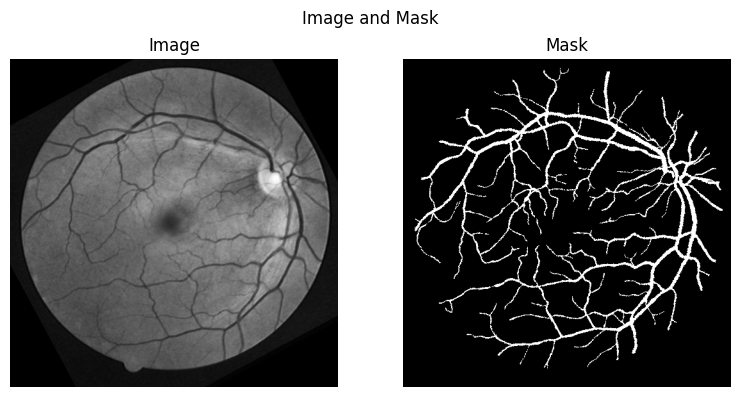

In [ ]:
# vessel segmentation dataset

class VesselSegmentationDataset(torch.utils.data.Dataset):
  """
    Dataset for vessel segmentation
  """

  def __init__(self, split):
    super().__init__()
    self.train_dir = '/content/drive/MyDrive/dataset_images/images/train/image'
    self.mask_train_dir = '/content/drive/MyDrive/dataset_images/images/train/mask'
    self.test_dir = '/content/drive/MyDrive/dataset_images/images/test/image'
    self.mask_test_dir = '/content/drive/MyDrive/dataset_images/images/test/mask'

    if split == 'train':
      self.image_dir = self.train_dir
      self.mask_dir = self.mask_train_dir
    elif split == 'test':
      self.image_dir = self.test_dir
      self.mask_dir = self.mask_test_dir

    self.image_paths = sorted(os.listdir(self.image_dir))
    self.mask_paths = sorted(os.listdir(self.mask_dir))

    self.transform = get_transforms('train' if split == 'train' else 'test')

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = os.path.join(self.image_dir, self.image_paths[idx])
    mask_path = os.path.join(self.mask_dir, self.mask_paths[idx])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    green = image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gaussian_blur = cv2.GaussianBlur(green, (5,5), 0.5)
    combined = clahe.apply(gaussian_blur)

    mask = cv2.imread(mask_path, 0)

    transformed = self.transform(image=combined, mask=mask)
    image = transformed['image']
    mask = transformed['mask']

    if image.ndim == 2:
      image = image.unsqueeze(0)
    if mask.ndim == 2:
      mask = mask.unsqueeze(0)

    mask = (mask > 127).float()


    return image, mask

if __name__ == '__main__':
  ds = VesselSegmentationDataset('train')

  print('Images loaded: {}'.format(len(ds)))

  image, mask = ds[random.randint(0, len(ds)-1)]
  print(image.shape, mask.shape)
  img = denorm(image)
  mask = denorm(mask)

  figure, axes = plt.subplots(1,2, figsize=(8,4))
  plt.suptitle('Image and Mask')

  axes[0].imshow(img, cmap='gray')
  axes[0].axis('off')
  axes[0].set_title('Image')

  axes[1].imshow(mask, cmap='gray')
  axes[1].axis('off')
  axes[1].set_title('Mask')

  plt.tight_layout()
  plt.show()

In [ ]:
# training modules

def train_epoch(model, dataloader, optimizer, criterion, device, epoch):
  model.train()

  total_losses = {
      'total': 0, 'bce': 0, 'dice': 0, 'tversky': 0,
      'focal': 0, 'thin_weighted': 0, 'edge': 0
  }
  all_metrics = {
      'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'iou': 0, 'dice': 0
  }

  num_batches = 0

  pbar = tqdm.tqdm(dataloader, desc='Epoch {}'.format(epoch))
  for images, masks in pbar:
    images = images.to(device)
    masks = masks.to(device)

    outputs = model(images)
    loss, loss_dict = criterion(outputs, masks)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    for k,v in loss_dict.items():
      total_losses[k] += v

    with torch.no_grad():
      metrics = calculate_metrics(outputs, masks, threshold)
      for k in all_metrics:
        all_metrics[k] += metrics[k]

    num_batches += 1



    pbar.set_postfix({
        'loss': f'{loss_dict['total']:.4f}',
        'f1': f'{metrics["f1"]:.4f}',
        'thin': f'{loss_dict['thin_weighted']:.4f}'
    })


  # average metrics
  results = {
      'losses': {k: v / num_batches for k,v in total_losses.items()},
      'metrics': {k: v / num_batches for k,v in all_metrics.items()}
  }

  return results

@torch.no_grad()
def validate(model, dataloader, criterion, device, threshold):
  model.eval()

  total_losses = {
      'total': 0, 'bce': 0, 'dice': 0, 'tversky': 0,
      'focal': 0, 'thin_weighted': 0, 'edge': 0
  }
  all_metrics = {
      'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'iou': 0, 'dice': 0
  }

  num_batches = 0

  for images, masks in tqdm.tqdm(dataloader, desc='Validating'):
    images = images.to(device)
    masks = masks.to(device)

    if images.ndim == 3:
      images = images.unsqueeze(1)
    if masks.ndim == 3:
      masks = masks.unsqueeze(1)

    outputs = model(images)
    loss, loss_dict = criterion(outputs, masks)

    for k,v in loss_dict.items():
      total_losses[k] += v

    metrics = calculate_metrics(outputs, masks, threshold=threshold)
    for k in all_metrics:
      all_metrics[k] += metrics[k]

    num_batches += 1


  results = {
      'losses': {k: v / num_batches for k,v in total_losses.items()},
      'metrics': {k: v / num_batches for k,v in all_metrics.items()}
  }

  return results

@torch.no_grad()
def visualize_predictions(model, dataloader, device, save_path, threshold, num_samples=4):
  model.eval()

  images,masks = next(iter(dataloader))
  images = images[:num_samples].to(device)
  masks = masks[:num_samples].to(device)

  outputs = model(images)
  preds = (torch.sigmoid(outputs) > threshold).float()

  fig, axes = plt.subplots(num_samples, 4, figsize=(16,4 * num_samples))

  for i in range(num_samples):

    img = images[i, 0].cpu()
    img = np.clip(denorm(img),0,1)
    axes[i,0].imshow(img, cmap='gray')
    axes[i,0].set_title('Input image')
    axes[i,0].axis('off')

    axes[i,1].imshow(np.clip(masks[i,0].cpu(), 0,1), cmap='gray')
    axes[i,1].set_title('Ground truth')
    axes[i,1].axis('off')

    axes[i,2].imshow(preds[i,0].cpu(), cmap='gray')
    axes[i,2].set_title('Prediction')
    axes[i,2].axis('off')

    gt = masks[i,0].cpu().numpy()
    pred = preds[i,0].cpu().numpy()

    overlay = np.zeros((*gt.shape, 3))
    overlay[...,1] = (gt * pred) # True positives (green)
    overlay[...,0] = (pred * (1-gt)) # False positives (red)
    overlay[...,2] = ((1-pred) * gt) # False negatives (blue)

    axes[i,3].imshow(overlay)
    axes[i,3].set_title('Overlay (G=TP, R=FP, B=FN)')
    axes[i,3].axis('off')

  plt.tight_layout()
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
  plt.close()

  print(f'Predictions saved to {save_path}')

In [ ]:
@torch.no_grad()
def find_optimal_threshold(model, dataloader, device):
  model.eval()

  all_preds = []
  all_masks = []

  print('Collecting predictions...')
  for images, masks in tqdm.tqdm(dataloader):
    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images)
    preds = torch.sigmoid(outputs).to(device)

    all_preds.append(preds)
    all_masks.append(masks)

  all_preds = torch.cat(all_preds)
  all_masks = torch.cat(all_masks)

  print('\n Testing thresholds...')
  best_f1 = 0.0
  best_thresh = 0.0

  results = []
  for thresh in np.arange(0.3, 0.7, 0.02):
    binary_preds = (all_preds > thresh).float()
    metrics = calculate_metrics(binary_preds, all_masks)
    f1 = metrics['f1']

    results.append({
        'threshold': thresh,
        'f1': f1,
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'iou': metrics['iou'],
        'dice': metrics['dice']
    })

    print(f"Thresh {thresh:.2f}: F1={f1:.4f} P={metrics['precision']:.4f} R={metrics['recall']:.4f}")

    if f1 > best_f1:
      best_f1 = f1
      best_thresh = thresh

  print(f"\n✓ Best threshold: {best_thresh:.2f}")
  print(f"✓ Best F1: {best_f1:.4f}")

  return best_thresh, results

best_threshold = find_optimal_threshold(model, test_data_loader, device)

NameError: name 'model' is not defined

Using device: cuda
Saving graphs to /content/drive/MyDrive/segmentation_results/graphs
Saving predictions to /content/drive/MyDrive/segmentation_results/visualizations
Saving models to /content/drive/MyDrive/segmentation_results/models
Saving checkpoints to /content/drive/MyDrive/segmentation_results/checkpoints

Loading Pretrained MAE
✓ Loaded MAE from epoch 169
 Final pretrain loss: 0.0059
 Final pretrain MSE loss: 0.0024
 Final pretrain edge loss: 0.0172

Creating Segmentation Model
✓ Encoder unfrozen - fine-tuning entire model
Total parameters: 58.8M
Total trainable paraemeters: 58.8M

Loading Data

 Testing Train Dataset
 Batch: Image torch.Size([4, 1, 512, 512]), Mask torch.Size([4, 1, 512, 512])

 Testing Test Dataset
 Batch: Image torch.Size([4, 1, 512, 512]), Mask torch.Size([4, 1, 512, 512])

 ✓ Loaded 20 batches of training images.
✓ Loaded 5 batches of testing images.

Training
✓ Loss function: Combined (BCE + Dice + Tversky + Focal)
✓ Optimizer: AdamW (lr=0.0001)
✓ Schedul

Epoch 1: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s, loss=4.0102, f1=0.3778, thin=0.5471]



Train Results:
  Loss: 4.3542
    ├─ BCE: 0.5968
    ├─ Dice: 0.8104
    ├─ Tversky: 0.6846
    ├─ Thin Weighted: 0.5968 ← Key!
    ├─ Edge: 1.3460
    └─ Focal: 0.0417
  F1: 0.2863 | Precision: 0.1926 | Recall: 0.5653


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]



Validation Results:
  Loss: 4.3345
  F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000
✓ Learning rate updated to 1.00e-04

 Epoch 2/200
------------------------------------------------------------


Epoch 2: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s, loss=3.7292, f1=0.4184, thin=0.4729]



Train Results:
  Loss: 3.9035
    ├─ BCE: 0.5105
    ├─ Dice: 0.7672
    ├─ Tversky: 0.6264
    ├─ Thin Weighted: 0.5105 ← Key!
    ├─ Edge: 1.3456
    └─ Focal: 0.0386
  F1: 0.3827 | Precision: 0.2696 | Recall: 0.6649


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]



Validation Results:
  Loss: 3.5847
  F1: 0.4442 | Precision: 0.4473 | Recall: 0.4415
✓ Best model saved (F1: 0.4442)
✓ Learning rate updated to 1.00e-04

 Epoch 3/200
------------------------------------------------------------


Epoch 3: 100%|██████████| 20/20 [00:08<00:00,  2.33it/s, loss=3.3582, f1=0.5050, thin=0.4141]



Train Results:
  Loss: 3.5998
    ├─ BCE: 0.4483
    ├─ Dice: 0.7382
    ├─ Tversky: 0.5930
    ├─ Thin Weighted: 0.4483 ← Key!
    ├─ Edge: 1.3271
    └─ Focal: 0.0341
  F1: 0.4428 | Precision: 0.3300 | Recall: 0.6765


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]



Validation Results:
  Loss: 3.2446
  F1: 0.4993 | Precision: 0.4125 | Recall: 0.6337
✓ Best model saved (F1: 0.4993)
✓ Learning rate updated to 1.00e-04

 Epoch 4/200
------------------------------------------------------------


Epoch 4: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s, loss=3.4391, f1=0.4597, thin=0.4000]



Train Results:
  Loss: 3.3925
    ├─ BCE: 0.4107
    ├─ Dice: 0.7148
    ├─ Tversky: 0.5658
    ├─ Thin Weighted: 0.4107 ← Key!
    ├─ Edge: 1.3079
    └─ Focal: 0.0312
  F1: 0.4832 | Precision: 0.3679 | Recall: 0.7059


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]



Validation Results:
  Loss: 3.1218
  F1: 0.5233 | Precision: 0.4194 | Recall: 0.6967
✓ Best model saved (F1: 0.5233)
✓ Learning rate updated to 1.00e-04

 Epoch 5/200
------------------------------------------------------------


Epoch 5: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s, loss=3.0652, f1=0.5592, thin=0.3602]



Train Results:
  Loss: 3.2413
    ├─ BCE: 0.3811
    ├─ Dice: 0.6989
    ├─ Tversky: 0.5485
    ├─ Thin Weighted: 0.3811 ← Key!
    ├─ Edge: 1.2816
    └─ Focal: 0.0279
  F1: 0.5166 | Precision: 0.4040 | Recall: 0.7178


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]



Validation Results:
  Loss: 3.0218
  F1: 0.5571 | Precision: 0.4691 | Recall: 0.6869
✓ Best model saved (F1: 0.5571)
✓ Learning rate updated to 1.00e-04
Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_005.png

 Epoch 6/200
------------------------------------------------------------


Epoch 6: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it, loss=3.2249, f1=0.5066, thin=0.3639]



Train Results:
  Loss: 3.1176
    ├─ BCE: 0.3613
    ├─ Dice: 0.6832
    ├─ Tversky: 0.5296
    ├─ Thin Weighted: 0.3613 ← Key!
    ├─ Edge: 1.2468
    └─ Focal: 0.0263
  F1: 0.5419 | Precision: 0.4286 | Recall: 0.7391


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]



Validation Results:
  Loss: 3.0132
  F1: 0.5531 | Precision: 0.4374 | Recall: 0.7523
✓ Learning rate updated to 1.00e-04

 Epoch 7/200
------------------------------------------------------------


Epoch 7: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s, loss=3.0745, f1=0.5429, thin=0.3537]



Train Results:
  Loss: 3.0132
    ├─ BCE: 0.3440
    ├─ Dice: 0.6693
    ├─ Tversky: 0.5148
    ├─ Thin Weighted: 0.3440 ← Key!
    ├─ Edge: 1.2151
    └─ Focal: 0.0250
  F1: 0.5647 | Precision: 0.4557 | Recall: 0.7436


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]



Validation Results:
  Loss: 2.9173
  F1: 0.5844 | Precision: 0.4774 | Recall: 0.7543
✓ Best model saved (F1: 0.5844)
✓ Learning rate updated to 1.00e-04

 Epoch 8/200
------------------------------------------------------------


Epoch 8: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s, loss=2.9152, f1=0.5793, thin=0.3285]



Train Results:
  Loss: 2.9191
    ├─ BCE: 0.3313
    ├─ Dice: 0.6554
    ├─ Tversky: 0.4980
    ├─ Thin Weighted: 0.3313 ← Key!
    ├─ Edge: 1.1822
    └─ Focal: 0.0247
  F1: 0.5834 | Precision: 0.4749 | Recall: 0.7583


Validating: 100%|██████████| 5/5 [00:21<00:00,  4.27s/it]



Validation Results:
  Loss: 2.8543
  F1: 0.5935 | Precision: 0.4877 | Recall: 0.7583
✓ Best model saved (F1: 0.5935)
✓ Learning rate updated to 1.00e-04

 Epoch 9/200
------------------------------------------------------------


Epoch 9: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s, loss=2.9012, f1=0.5763, thin=0.3209]



Train Results:
  Loss: 2.8465
    ├─ BCE: 0.3187
    ├─ Dice: 0.6451
    ├─ Tversky: 0.4886
    ├─ Thin Weighted: 0.3187 ← Key!
    ├─ Edge: 1.1607
    └─ Focal: 0.0238
  F1: 0.5962 | Precision: 0.4924 | Recall: 0.7578


Validating: 100%|██████████| 5/5 [00:20<00:00,  4.10s/it]



Validation Results:
  Loss: 2.7823
  F1: 0.6048 | Precision: 0.4999 | Recall: 0.7658
✓ Best model saved (F1: 0.6048)
✓ Learning rate updated to 1.00e-04

 Epoch 10/200
------------------------------------------------------------


Epoch 10: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, loss=2.6631, f1=0.6356, thin=0.2945]



Train Results:
  Loss: 2.7660
    ├─ BCE: 0.3062
    ├─ Dice: 0.6332
    ├─ Tversky: 0.4765
    ├─ Thin Weighted: 0.3062 ← Key!
    ├─ Edge: 1.1348
    └─ Focal: 0.0231
  F1: 0.6102 | Precision: 0.5091 | Recall: 0.7639


Validating: 100%|██████████| 5/5 [00:19<00:00,  3.95s/it]



Validation Results:
  Loss: 2.6930
  F1: 0.6312 | Precision: 0.5482 | Recall: 0.7462
✓ Best model saved (F1: 0.6312)
✓ Learning rate updated to 1.00e-04
Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_010.png

 Epoch 11/200
------------------------------------------------------------


Epoch 11: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s, loss=2.6741, f1=0.6188, thin=0.2909]



Train Results:
  Loss: 2.6978
    ├─ BCE: 0.2957
    ├─ Dice: 0.6228
    ├─ Tversky: 0.4662
    ├─ Thin Weighted: 0.2957 ← Key!
    ├─ Edge: 1.1120
    └─ Focal: 0.0225
  F1: 0.6222 | Precision: 0.5231 | Recall: 0.7690


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]



Validation Results:
  Loss: 2.6731
  F1: 0.6174 | Precision: 0.5075 | Recall: 0.7894
✓ Learning rate updated to 1.00e-04

 Epoch 12/200
------------------------------------------------------------


Epoch 12: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s, loss=2.5770, f1=0.6365, thin=0.2814]



Train Results:
  Loss: 2.6360
    ├─ BCE: 0.2854
    ├─ Dice: 0.6137
    ├─ Tversky: 0.4577
    ├─ Thin Weighted: 0.2854 ← Key!
    ├─ Edge: 1.0885
    └─ Focal: 0.0219
  F1: 0.6326 | Precision: 0.5359 | Recall: 0.7742


Validating: 100%|██████████| 5/5 [00:19<00:00,  3.95s/it]



Validation Results:
  Loss: 2.6327
  F1: 0.6163 | Precision: 0.4983 | Recall: 0.8080
✓ Learning rate updated to 1.00e-04

 Epoch 13/200
------------------------------------------------------------


Epoch 13: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s, loss=2.5747, f1=0.6368, thin=0.2751]



Train Results:
  Loss: 2.5770
    ├─ BCE: 0.2780
    ├─ Dice: 0.6031
    ├─ Tversky: 0.4472
    ├─ Thin Weighted: 0.2780 ← Key!
    ├─ Edge: 1.0792
    └─ Focal: 0.0219
  F1: 0.6388 | Precision: 0.5418 | Recall: 0.7797


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]



Validation Results:
  Loss: 2.5563
  F1: 0.6425 | Precision: 0.5475 | Recall: 0.7786
✓ Best model saved (F1: 0.6425)
✓ Learning rate updated to 1.00e-04

 Epoch 14/200
------------------------------------------------------------


Epoch 14: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s, loss=2.4973, f1=0.6482, thin=0.2647]



Train Results:
  Loss: 2.5193
    ├─ BCE: 0.2679
    ├─ Dice: 0.5938
    ├─ Tversky: 0.4402
    ├─ Thin Weighted: 0.2679 ← Key!
    ├─ Edge: 1.0590
    └─ Focal: 0.0213
  F1: 0.6471 | Precision: 0.5536 | Recall: 0.7803


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]



Validation Results:
  Loss: 2.4800
  F1: 0.6540 | Precision: 0.5663 | Recall: 0.7744
✓ Best model saved (F1: 0.6540)
✓ Learning rate updated to 1.00e-04

 Epoch 15/200
------------------------------------------------------------


Epoch 15: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s, loss=2.3941, f1=0.6730, thin=0.2478]



Train Results:
  Loss: 2.4576
    ├─ BCE: 0.2586
    ├─ Dice: 0.5839
    ├─ Tversky: 0.4309
    ├─ Thin Weighted: 0.2586 ← Key!
    ├─ Edge: 1.0372
    └─ Focal: 0.0205
  F1: 0.6569 | Precision: 0.5656 | Recall: 0.7853


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Validation Results:
  Loss: 2.5140
  F1: 0.6341 | Precision: 0.5197 | Recall: 0.8147
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_015.png

 Epoch 16/200
------------------------------------------------------------


Epoch 16: 100%|██████████| 20/20 [00:30<00:00,  1.50s/it, loss=2.3813, f1=0.6604, thin=0.2492]



Train Results:
  Loss: 2.4008
    ├─ BCE: 0.2502
    ├─ Dice: 0.5747
    ├─ Tversky: 0.4221
    ├─ Thin Weighted: 0.2502 ← Key!
    ├─ Edge: 1.0161
    └─ Focal: 0.0202
  F1: 0.6639 | Precision: 0.5721 | Recall: 0.7926


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]



Validation Results:
  Loss: 2.4163
  F1: 0.6637 | Precision: 0.5839 | Recall: 0.7693
✓ Best model saved (F1: 0.6637)
✓ Learning rate updated to 1.00e-04

 Epoch 17/200
------------------------------------------------------------


Epoch 17: 100%|██████████| 20/20 [00:08<00:00,  2.37it/s, loss=2.3416, f1=0.6641, thin=0.2473]



Train Results:
  Loss: 2.3712
    ├─ BCE: 0.2452
    ├─ Dice: 0.5679
    ├─ Tversky: 0.4189
    ├─ Thin Weighted: 0.2452 ← Key!
    ├─ Edge: 1.0195
    └─ Focal: 0.0205
  F1: 0.6655 | Precision: 0.5778 | Recall: 0.7861


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]



Validation Results:
  Loss: 2.3796
  F1: 0.6646 | Precision: 0.5785 | Recall: 0.7815
✓ Best model saved (F1: 0.6646)
✓ Learning rate updated to 1.00e-04

 Epoch 18/200
------------------------------------------------------------


Epoch 18: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s, loss=2.2626, f1=0.6825, thin=0.2229]



Train Results:
  Loss: 2.3230
    ├─ BCE: 0.2380
    ├─ Dice: 0.5594
    ├─ Tversky: 0.4119
    ├─ Thin Weighted: 0.2380 ← Key!
    ├─ Edge: 1.0038
    └─ Focal: 0.0201
  F1: 0.6701 | Precision: 0.5827 | Recall: 0.7900


Validating: 100%|██████████| 5/5 [00:20<00:00,  4.16s/it]



Validation Results:
  Loss: 2.3092
  F1: 0.6708 | Precision: 0.5930 | Recall: 0.7727
✓ Best model saved (F1: 0.6708)
✓ Learning rate updated to 1.00e-04

 Epoch 19/200
------------------------------------------------------------


Epoch 19: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s, loss=2.2001, f1=0.6903, thin=0.2276]



Train Results:
  Loss: 2.2766
    ├─ BCE: 0.2307
    ├─ Dice: 0.5508
    ├─ Tversky: 0.4055
    ├─ Thin Weighted: 0.2307 ← Key!
    ├─ Edge: 0.9911
    └─ Focal: 0.0197
  F1: 0.6758 | Precision: 0.5911 | Recall: 0.7903


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]



Validation Results:
  Loss: 2.2868
  F1: 0.6676 | Precision: 0.5736 | Recall: 0.7994
✓ Learning rate updated to 1.00e-04

 Epoch 20/200
------------------------------------------------------------


Epoch 20: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it, loss=2.2115, f1=0.6777, thin=0.2221]



Train Results:
  Loss: 2.2393
    ├─ BCE: 0.2266
    ├─ Dice: 0.5427
    ├─ Tversky: 0.3988
    ├─ Thin Weighted: 0.2266 ← Key!
    ├─ Edge: 0.9855
    └─ Focal: 0.0199
  F1: 0.6785 | Precision: 0.5934 | Recall: 0.7935


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]



Validation Results:
  Loss: 2.2452
  F1: 0.6776 | Precision: 0.6011 | Recall: 0.7774
✓ Best model saved (F1: 0.6776)
✓ Learning rate updated to 1.00e-04
Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_020.png

 Epoch 21/200
------------------------------------------------------------


Epoch 21: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s, loss=2.0818, f1=0.7094, thin=0.2032]



Train Results:
  Loss: 2.1899
    ├─ BCE: 0.2193
    ├─ Dice: 0.5333
    ├─ Tversky: 0.3917
    ├─ Thin Weighted: 0.2193 ← Key!
    ├─ Edge: 0.9735
    └─ Focal: 0.0195
  F1: 0.6841 | Precision: 0.6001 | Recall: 0.7969


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.57it/s]



Validation Results:
  Loss: 2.2246
  F1: 0.6723 | Precision: 0.5864 | Recall: 0.7879
✓ Learning rate updated to 1.00e-04

 Epoch 22/200
------------------------------------------------------------


Epoch 22: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it, loss=2.0454, f1=0.7222, thin=0.1960]



Train Results:
  Loss: 2.1564
    ├─ BCE: 0.2146
    ├─ Dice: 0.5255
    ├─ Tversky: 0.3870
    ├─ Thin Weighted: 0.2146 ← Key!
    ├─ Edge: 0.9687
    └─ Focal: 0.0196
  F1: 0.6863 | Precision: 0.6052 | Recall: 0.7936


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]



Validation Results:
  Loss: 2.1754
  F1: 0.6882 | Precision: 0.6262 | Recall: 0.7651
✓ Best model saved (F1: 0.6882)
✓ Learning rate updated to 1.00e-04

 Epoch 23/200
------------------------------------------------------------


Epoch 23: 100%|██████████| 20/20 [00:08<00:00,  2.35it/s, loss=2.0072, f1=0.7211, thin=0.1980]



Train Results:
  Loss: 2.1291
    ├─ BCE: 0.2095
    ├─ Dice: 0.5203
    ├─ Tversky: 0.3843
    ├─ Thin Weighted: 0.2095 ← Key!
    ├─ Edge: 0.9549
    └─ Focal: 0.0193
  F1: 0.6895 | Precision: 0.6109 | Recall: 0.7930


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s]



Validation Results:
  Loss: 2.1250
  F1: 0.6865 | Precision: 0.6104 | Recall: 0.7855
✓ Learning rate updated to 1.00e-04

 Epoch 24/200
------------------------------------------------------------


Epoch 24: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s, loss=2.0262, f1=0.7039, thin=0.1951]



Train Results:
  Loss: 2.0800
    ├─ BCE: 0.2045
    ├─ Dice: 0.5103
    ├─ Tversky: 0.3748
    ├─ Thin Weighted: 0.2045 ← Key!
    ├─ Edge: 0.9473
    └─ Focal: 0.0192
  F1: 0.6941 | Precision: 0.6138 | Recall: 0.8007


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]



Validation Results:
  Loss: 2.0962
  F1: 0.6927 | Precision: 0.6263 | Recall: 0.7753
✓ Best model saved (F1: 0.6927)
✓ Learning rate updated to 1.00e-04

 Epoch 25/200
------------------------------------------------------------


Epoch 25: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s, loss=2.0190, f1=0.7050, thin=0.1950]



Train Results:
  Loss: 2.0529
    ├─ BCE: 0.2000
    ├─ Dice: 0.5035
    ├─ Tversky: 0.3720
    ├─ Thin Weighted: 0.2000 ← Key!
    ├─ Edge: 0.9406
    └─ Focal: 0.0193
  F1: 0.6959 | Precision: 0.6188 | Recall: 0.7960


Validating: 100%|██████████| 5/5 [00:19<00:00,  3.90s/it]



Validation Results:
  Loss: 2.0655
  F1: 0.6938 | Precision: 0.6312 | Recall: 0.7717
✓ Best model saved (F1: 0.6938)
✓ Learning rate updated to 1.00e-04
Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_025.png

 Epoch 26/200
------------------------------------------------------------


Epoch 26: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s, loss=1.9275, f1=0.7145, thin=0.1904]



Train Results:
  Loss: 2.0209
    ├─ BCE: 0.1961
    ├─ Dice: 0.4973
    ├─ Tversky: 0.3665
    ├─ Thin Weighted: 0.1961 ← Key!
    ├─ Edge: 0.9311
    └─ Focal: 0.0191
  F1: 0.6995 | Precision: 0.6221 | Recall: 0.8014


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]



Validation Results:
  Loss: 2.0582
  F1: 0.6860 | Precision: 0.5991 | Recall: 0.8024
✓ Learning rate updated to 1.00e-04

 Epoch 27/200
------------------------------------------------------------


Epoch 27: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s, loss=2.0391, f1=0.6928, thin=0.1967]



Train Results:
  Loss: 1.9758
    ├─ BCE: 0.1906
    ├─ Dice: 0.4876
    ├─ Tversky: 0.3590
    ├─ Thin Weighted: 0.1906 ← Key!
    ├─ Edge: 0.9192
    └─ Focal: 0.0189
  F1: 0.7052 | Precision: 0.6291 | Recall: 0.8032


Validating: 100%|██████████| 5/5 [00:20<00:00,  4.18s/it]



Validation Results:
  Loss: 2.0048
  F1: 0.7038 | Precision: 0.6533 | Recall: 0.7636
✓ Best model saved (F1: 0.7038)
✓ Learning rate updated to 1.00e-04

 Epoch 28/200
------------------------------------------------------------


Epoch 28: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s, loss=1.9594, f1=0.7057, thin=0.1891]



Train Results:
  Loss: 1.9543
    ├─ BCE: 0.1883
    ├─ Dice: 0.4817
    ├─ Tversky: 0.3555
    ├─ Thin Weighted: 0.1883 ← Key!
    ├─ Edge: 0.9164
    └─ Focal: 0.0190
  F1: 0.7061 | Precision: 0.6314 | Recall: 0.8035


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]



Validation Results:
  Loss: 1.9981
  F1: 0.6973 | Precision: 0.6440 | Recall: 0.7617
✓ Learning rate updated to 1.00e-04

 Epoch 29/200
------------------------------------------------------------


Epoch 29: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s, loss=1.9272, f1=0.7086, thin=0.1841]



Train Results:
  Loss: 1.9180
    ├─ BCE: 0.1834
    ├─ Dice: 0.4732
    ├─ Tversky: 0.3503
    ├─ Thin Weighted: 0.1834 ← Key!
    ├─ Edge: 0.9088
    └─ Focal: 0.0189
  F1: 0.7104 | Precision: 0.6380 | Recall: 0.8035


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]



Validation Results:
  Loss: 1.9639
  F1: 0.7016 | Precision: 0.6348 | Recall: 0.7850
✓ Learning rate updated to 1.00e-04

 Epoch 30/200
------------------------------------------------------------


Epoch 30: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it, loss=1.7797, f1=0.7355, thin=0.1682]



Train Results:
  Loss: 1.8917
    ├─ BCE: 0.1803
    ├─ Dice: 0.4671
    ├─ Tversky: 0.3459
    ├─ Thin Weighted: 0.1803 ← Key!
    ├─ Edge: 0.9003
    └─ Focal: 0.0188
  F1: 0.7131 | Precision: 0.6410 | Recall: 0.8052


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


Validation Results:
  Loss: 1.9788
  F1: 0.6913 | Precision: 0.6073 | Recall: 0.8029
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_030.png

 Epoch 31/200
------------------------------------------------------------


Epoch 31: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s, loss=1.8158, f1=0.7274, thin=0.1769]



Train Results:
  Loss: 1.8583
    ├─ BCE: 0.1768
    ├─ Dice: 0.4594
    ├─ Tversky: 0.3399
    ├─ Thin Weighted: 0.1768 ← Key!
    ├─ Edge: 0.8870
    └─ Focal: 0.0188
  F1: 0.7169 | Precision: 0.6448 | Recall: 0.8079


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]



Validation Results:
  Loss: 1.9444
  F1: 0.6890 | Precision: 0.5968 | Recall: 0.8152
✓ Learning rate updated to 1.00e-04

 Epoch 32/200
------------------------------------------------------------


Epoch 32: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it, loss=1.7657, f1=0.7420, thin=0.1678]



Train Results:
  Loss: 1.8469
    ├─ BCE: 0.1757
    ├─ Dice: 0.4543
    ├─ Tversky: 0.3384
    ├─ Thin Weighted: 0.1757 ← Key!
    ├─ Edge: 0.8974
    └─ Focal: 0.0193
  F1: 0.7142 | Precision: 0.6434 | Recall: 0.8039


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]



Validation Results:
  Loss: 1.8911
  F1: 0.6988 | Precision: 0.6207 | Recall: 0.8000
✓ Learning rate updated to 1.00e-04

 Epoch 33/200
------------------------------------------------------------


Epoch 33: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s, loss=1.8236, f1=0.7189, thin=0.1643]



Train Results:
  Loss: 1.8053
    ├─ BCE: 0.1716
    ├─ Dice: 0.4456
    ├─ Tversky: 0.3304
    ├─ Thin Weighted: 0.1716 ← Key!
    ├─ Edge: 0.8857
    └─ Focal: 0.0190
  F1: 0.7197 | Precision: 0.6473 | Recall: 0.8115


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]



Validation Results:
  Loss: 1.8788
  F1: 0.7016 | Precision: 0.6340 | Recall: 0.7863
✓ Learning rate updated to 1.00e-04

 Epoch 34/200
------------------------------------------------------------


Epoch 34: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s, loss=1.7417, f1=0.7320, thin=0.1737]



Train Results:
  Loss: 1.7923
    ├─ BCE: 0.1683
    ├─ Dice: 0.4417
    ├─ Tversky: 0.3308
    ├─ Thin Weighted: 0.1683 ← Key!
    ├─ Edge: 0.8762
    └─ Focal: 0.0189
  F1: 0.7221 | Precision: 0.6562 | Recall: 0.8045


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]



Validation Results:
  Loss: 1.8907
  F1: 0.6874 | Precision: 0.5911 | Recall: 0.8230
✓ Learning rate updated to 1.00e-04

 Epoch 35/200
------------------------------------------------------------


Epoch 35: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=1.6917, f1=0.7429, thin=0.1552]



Train Results:
  Loss: 1.7683
    ├─ BCE: 0.1674
    ├─ Dice: 0.4351
    ├─ Tversky: 0.3247
    ├─ Thin Weighted: 0.1674 ← Key!
    ├─ Edge: 0.8765
    └─ Focal: 0.0193
  F1: 0.7213 | Precision: 0.6514 | Recall: 0.8090


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]



Validation Results:
  Loss: 1.8321
  F1: 0.7160 | Precision: 0.6791 | Recall: 0.7578
✓ Best model saved (F1: 0.7160)
✓ Learning rate updated to 1.00e-04
Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_035.png

 Epoch 36/200
------------------------------------------------------------


Epoch 36: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it, loss=1.6915, f1=0.7323, thin=0.1614]



Train Results:
  Loss: 1.7352
    ├─ BCE: 0.1633
    ├─ Dice: 0.4272
    ├─ Tversky: 0.3196
    ├─ Thin Weighted: 0.1633 ← Key!
    ├─ Edge: 0.8654
    └─ Focal: 0.0190
  F1: 0.7271 | Precision: 0.6606 | Recall: 0.8101


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]



Validation Results:
  Loss: 1.8119
  F1: 0.7128 | Precision: 0.6601 | Recall: 0.7765
✓ Learning rate updated to 1.00e-04

 Epoch 37/200
------------------------------------------------------------


Epoch 37: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s, loss=1.5962, f1=0.7675, thin=0.1478]



Train Results:
  Loss: 1.7082
    ├─ BCE: 0.1595
    ├─ Dice: 0.4214
    ├─ Tversky: 0.3159
    ├─ Thin Weighted: 0.1595 ← Key!
    ├─ Edge: 0.8478
    └─ Focal: 0.0186
  F1: 0.7314 | Precision: 0.6661 | Recall: 0.8121


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]



Validation Results:
  Loss: 1.7767
  F1: 0.7146 | Precision: 0.6578 | Recall: 0.7822
✓ Learning rate updated to 1.00e-04

 Epoch 38/200
------------------------------------------------------------


Epoch 38: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s, loss=1.7359, f1=0.7169, thin=0.1588]



Train Results:
  Loss: 1.7038
    ├─ BCE: 0.1607
    ├─ Dice: 0.4181
    ├─ Tversky: 0.3137
    ├─ Thin Weighted: 0.1607 ← Key!
    ├─ Edge: 0.8611
    └─ Focal: 0.0194
  F1: 0.7280 | Precision: 0.6605 | Recall: 0.8118


Validating: 100%|██████████| 5/5 [00:19<00:00,  3.87s/it]



Validation Results:
  Loss: 1.7812
  F1: 0.7134 | Precision: 0.6631 | Recall: 0.7720
✓ Learning rate updated to 1.00e-04

 Epoch 39/200
------------------------------------------------------------


Epoch 39: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s, loss=1.7125, f1=0.7188, thin=0.1660]



Train Results:
  Loss: 1.6730
    ├─ BCE: 0.1564
    ├─ Dice: 0.4105
    ├─ Tversky: 0.3097
    ├─ Thin Weighted: 0.1564 ← Key!
    ├─ Edge: 0.8469
    └─ Focal: 0.0190
  F1: 0.7328 | Precision: 0.6691 | Recall: 0.8112


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]



Validation Results:
  Loss: 1.7645
  F1: 0.7132 | Precision: 0.6556 | Recall: 0.7824
✓ Learning rate updated to 1.00e-04

 Epoch 40/200
------------------------------------------------------------


Epoch 40: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=1.4950, f1=0.7742, thin=0.1364]



Train Results:
  Loss: 1.6589
    ├─ BCE: 0.1554
    ├─ Dice: 0.4062
    ├─ Tversky: 0.3069
    ├─ Thin Weighted: 0.1554 ← Key!
    ├─ Edge: 0.8433
    └─ Focal: 0.0192
  F1: 0.7330 | Precision: 0.6690 | Recall: 0.8119


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


Validation Results:
  Loss: 1.7451
  F1: 0.7123 | Precision: 0.6489 | Recall: 0.7905
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_040.png

 Epoch 41/200
------------------------------------------------------------


Epoch 41: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s, loss=1.5278, f1=0.7511, thin=0.1409]



Train Results:
  Loss: 1.6340
    ├─ BCE: 0.1530
    ├─ Dice: 0.3999
    ├─ Tversky: 0.3023
    ├─ Thin Weighted: 0.1530 ← Key!
    ├─ Edge: 0.8389
    └─ Focal: 0.0192
  F1: 0.7355 | Precision: 0.6718 | Recall: 0.8138


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]



Validation Results:
  Loss: 1.7314
  F1: 0.7185 | Precision: 0.6736 | Recall: 0.7708
✓ Best model saved (F1: 0.7185)
✓ Learning rate updated to 1.00e-04

 Epoch 42/200
------------------------------------------------------------


Epoch 42: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=1.5759, f1=0.7505, thin=0.1458]



Train Results:
  Loss: 1.6179
    ├─ BCE: 0.1509
    ├─ Dice: 0.3956
    ├─ Tversky: 0.3002
    ├─ Thin Weighted: 0.1509 ← Key!
    ├─ Edge: 0.8291
    └─ Focal: 0.0191
  F1: 0.7374 | Precision: 0.6755 | Recall: 0.8133


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]



Validation Results:
  Loss: 1.7055
  F1: 0.7242 | Precision: 0.6829 | Recall: 0.7712
✓ Best model saved (F1: 0.7242)
✓ Learning rate updated to 1.00e-04

 Epoch 43/200
------------------------------------------------------------


Epoch 43: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s, loss=1.6371, f1=0.7246, thin=0.1538]



Train Results:
  Loss: 1.6091
    ├─ BCE: 0.1504
    ├─ Dice: 0.3920
    ├─ Tversky: 0.2986
    ├─ Thin Weighted: 0.1504 ← Key!
    ├─ Edge: 0.8299
    └─ Focal: 0.0194
  F1: 0.7372 | Precision: 0.6756 | Recall: 0.8123


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]



Validation Results:
  Loss: 1.7022
  F1: 0.7100 | Precision: 0.6342 | Recall: 0.8076
✓ Learning rate updated to 1.00e-04

 Epoch 44/200
------------------------------------------------------------


Epoch 44: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s, loss=1.4778, f1=0.7546, thin=0.1330]



Train Results:
  Loss: 1.5910
    ├─ BCE: 0.1490
    ├─ Dice: 0.3879
    ├─ Tversky: 0.2947
    ├─ Thin Weighted: 0.1490 ← Key!
    ├─ Edge: 0.8248
    └─ Focal: 0.0193
  F1: 0.7390 | Precision: 0.6762 | Recall: 0.8160


Validating: 100%|██████████| 5/5 [00:18<00:00,  3.75s/it]



Validation Results:
  Loss: 1.6885
  F1: 0.7262 | Precision: 0.7107 | Recall: 0.7442
✓ Best model saved (F1: 0.7262)
✓ Learning rate updated to 1.00e-04

 Epoch 45/200
------------------------------------------------------------


Epoch 45: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s, loss=1.6567, f1=0.7247, thin=0.1519]



Train Results:
  Loss: 1.5834
    ├─ BCE: 0.1476
    ├─ Dice: 0.3844
    ├─ Tversky: 0.2946
    ├─ Thin Weighted: 0.1476 ← Key!
    ├─ Edge: 0.8246
    └─ Focal: 0.0194
  F1: 0.7399 | Precision: 0.6806 | Recall: 0.8117


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]



Validation Results:
  Loss: 1.6682
  F1: 0.7293 | Precision: 0.7132 | Recall: 0.7472
✓ Best model saved (F1: 0.7293)
✓ Learning rate updated to 1.00e-04
Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_045.png

 Epoch 46/200
------------------------------------------------------------


Epoch 46: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s, loss=1.4992, f1=0.7611, thin=0.1387]



Train Results:
  Loss: 1.5475
    ├─ BCE: 0.1436
    ├─ Dice: 0.3765
    ├─ Tversky: 0.2886
    ├─ Thin Weighted: 0.1436 ← Key!
    ├─ Edge: 0.8077
    └─ Focal: 0.0189
  F1: 0.7456 | Precision: 0.6869 | Recall: 0.8166


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]



Validation Results:
  Loss: 1.6866
  F1: 0.7219 | Precision: 0.7021 | Recall: 0.7440
✓ Learning rate updated to 1.00e-04

 Epoch 47/200
------------------------------------------------------------


Epoch 47: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s, loss=1.5223, f1=0.7493, thin=0.1417]



Train Results:
  Loss: 1.5449
    ├─ BCE: 0.1439
    ├─ Dice: 0.3733
    ├─ Tversky: 0.2882
    ├─ Thin Weighted: 0.1439 ← Key!
    ├─ Edge: 0.8140
    └─ Focal: 0.0194
  F1: 0.7440 | Precision: 0.6870 | Recall: 0.8125


Validating: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]



Validation Results:
  Loss: 1.6639
  F1: 0.7204 | Precision: 0.6811 | Recall: 0.7654
✓ Learning rate updated to 1.00e-04

 Epoch 48/200
------------------------------------------------------------


Epoch 48: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s, loss=1.4278, f1=0.7657, thin=0.1358]



Train Results:
  Loss: 1.5255
    ├─ BCE: 0.1420
    ├─ Dice: 0.3690
    ├─ Tversky: 0.2844
    ├─ Thin Weighted: 0.1420 ← Key!
    ├─ Edge: 0.8039
    └─ Focal: 0.0193
  F1: 0.7463 | Precision: 0.6880 | Recall: 0.8161


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]



Validation Results:
  Loss: 1.6500
  F1: 0.7187 | Precision: 0.6608 | Recall: 0.7887
✓ Learning rate updated to 1.00e-04

 Epoch 49/200
------------------------------------------------------------


Epoch 49: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s, loss=1.3980, f1=0.7779, thin=0.1280]



Train Results:
  Loss: 1.5080
    ├─ BCE: 0.1404
    ├─ Dice: 0.3646
    ├─ Tversky: 0.2812
    ├─ Thin Weighted: 0.1404 ← Key!
    ├─ Edge: 0.7974
    └─ Focal: 0.0192
  F1: 0.7483 | Precision: 0.6909 | Recall: 0.8180


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]



Validation Results:
  Loss: 1.6398
  F1: 0.7219 | Precision: 0.6669 | Recall: 0.7874
✓ Learning rate updated to 1.00e-04

 Epoch 50/200
------------------------------------------------------------


Epoch 50: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s, loss=1.4227, f1=0.7629, thin=0.1299]



Train Results:
  Loss: 1.4973
    ├─ BCE: 0.1401
    ├─ Dice: 0.3612
    ├─ Tversky: 0.2785
    ├─ Thin Weighted: 0.1401 ← Key!
    ├─ Edge: 0.7987
    └─ Focal: 0.0194
  F1: 0.7486 | Precision: 0.6896 | Recall: 0.8197


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]



Validation Results:
  Loss: 1.6340
  F1: 0.7297 | Precision: 0.7250 | Recall: 0.7353
✓ Best model saved (F1: 0.7297)
✓ Learning rate updated to 1.00e-04
Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_050.png

 Epoch 51/200
------------------------------------------------------------


Epoch 51: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s, loss=1.5865, f1=0.7423, thin=0.1532]



Train Results:
  Loss: 1.4816
    ├─ BCE: 0.1379
    ├─ Dice: 0.3563
    ├─ Tversky: 0.2769
    ├─ Thin Weighted: 0.1379 ← Key!
    ├─ Edge: 0.7905
    └─ Focal: 0.0193
  F1: 0.7518 | Precision: 0.6969 | Recall: 0.8174


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]



Validation Results:
  Loss: 1.6293
  F1: 0.7267 | Precision: 0.6948 | Recall: 0.7620
✓ Learning rate updated to 1.00e-04

 Epoch 52/200
------------------------------------------------------------


Epoch 52: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it, loss=1.4096, f1=0.7803, thin=0.1326]



Train Results:
  Loss: 1.4766
    ├─ BCE: 0.1386
    ├─ Dice: 0.3546
    ├─ Tversky: 0.2747
    ├─ Thin Weighted: 0.1386 ← Key!
    ├─ Edge: 0.7928
    └─ Focal: 0.0196
  F1: 0.7503 | Precision: 0.6928 | Recall: 0.8211


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]



Validation Results:
  Loss: 1.6179
  F1: 0.7162 | Precision: 0.6472 | Recall: 0.8026
✓ Learning rate updated to 1.00e-04

 Epoch 53/200
------------------------------------------------------------


Epoch 53: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=1.3846, f1=0.7970, thin=0.1245]



Train Results:
  Loss: 1.4693
    ├─ BCE: 0.1377
    ├─ Dice: 0.3516
    ├─ Tversky: 0.2740
    ├─ Thin Weighted: 0.1377 ← Key!
    ├─ Edge: 0.7898
    └─ Focal: 0.0196
  F1: 0.7512 | Precision: 0.6956 | Recall: 0.8183


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]



Validation Results:
  Loss: 1.5906
  F1: 0.7297 | Precision: 0.6978 | Recall: 0.7647
✓ Best model saved (F1: 0.7297)
✓ Learning rate updated to 1.00e-04

 Epoch 54/200
------------------------------------------------------------


Epoch 54: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s, loss=1.3251, f1=0.7717, thin=0.1217]



Train Results:
  Loss: 1.4610
    ├─ BCE: 0.1381
    ├─ Dice: 0.3489
    ├─ Tversky: 0.2711
    ├─ Thin Weighted: 0.1381 ← Key!
    ├─ Edge: 0.7943
    └─ Focal: 0.0200
  F1: 0.7505 | Precision: 0.6922 | Recall: 0.8217


Validating: 100%|██████████| 5/5 [00:20<00:00,  4.17s/it]



Validation Results:
  Loss: 1.5847
  F1: 0.7307 | Precision: 0.7104 | Recall: 0.7541
✓ Best model saved (F1: 0.7307)
✓ Learning rate updated to 1.00e-04

 Epoch 55/200
------------------------------------------------------------


Epoch 55: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s, loss=1.4479, f1=0.7544, thin=0.1390]



Train Results:
  Loss: 1.4466
    ├─ BCE: 0.1346
    ├─ Dice: 0.3440
    ├─ Tversky: 0.2717
    ├─ Thin Weighted: 0.1346 ← Key!
    ├─ Edge: 0.7793
    └─ Focal: 0.0195
  F1: 0.7550 | Precision: 0.7041 | Recall: 0.8148


Validating: 100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Validation Results:
  Loss: 1.5730
  F1: 0.7267 | Precision: 0.6759 | Recall: 0.7867
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_055.png

 Epoch 56/200
------------------------------------------------------------


Epoch 56: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it, loss=1.3803, f1=0.7678, thin=0.1260]



Train Results:
  Loss: 1.4465
    ├─ BCE: 0.1358
    ├─ Dice: 0.3439
    ├─ Tversky: 0.2701
    ├─ Thin Weighted: 0.1358 ← Key!
    ├─ Edge: 0.7845
    └─ Focal: 0.0199
  F1: 0.7528 | Precision: 0.6991 | Recall: 0.8172


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.57it/s]



Validation Results:
  Loss: 1.5568
  F1: 0.7281 | Precision: 0.6773 | Recall: 0.7876
✓ Learning rate updated to 1.00e-04

 Epoch 57/200
------------------------------------------------------------


Epoch 57: 100%|██████████| 20/20 [00:07<00:00,  2.86it/s, loss=1.2725, f1=0.7674, thin=0.1185]



Train Results:
  Loss: 1.4195
    ├─ BCE: 0.1341
    ├─ Dice: 0.3377
    ├─ Tversky: 0.2639
    ├─ Thin Weighted: 0.1341 ← Key!
    ├─ Edge: 0.7780
    └─ Focal: 0.0197
  F1: 0.7567 | Precision: 0.7002 | Recall: 0.8250


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]



Validation Results:
  Loss: 1.5587
  F1: 0.7265 | Precision: 0.6720 | Recall: 0.7931
✓ Learning rate updated to 1.00e-04

 Epoch 58/200
------------------------------------------------------------


Epoch 58: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s, loss=1.3208, f1=0.7910, thin=0.1194]



Train Results:
  Loss: 1.3997
    ├─ BCE: 0.1309
    ├─ Dice: 0.3328
    ├─ Tversky: 0.2620
    ├─ Thin Weighted: 0.1309 ← Key!
    ├─ Edge: 0.7593
    └─ Focal: 0.0192
  F1: 0.7604 | Precision: 0.7071 | Recall: 0.8233


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]



Validation Results:
  Loss: 1.5567
  F1: 0.7241 | Precision: 0.6621 | Recall: 0.7998
✓ Learning rate updated to 1.00e-04

 Epoch 59/200
------------------------------------------------------------


Epoch 59: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=1.3652, f1=0.7650, thin=0.1228]



Train Results:
  Loss: 1.4044
    ├─ BCE: 0.1323
    ├─ Dice: 0.3320
    ├─ Tversky: 0.2622
    ├─ Thin Weighted: 0.1323 ← Key!
    ├─ Edge: 0.7709
    └─ Focal: 0.0198
  F1: 0.7576 | Precision: 0.7040 | Recall: 0.8213


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s]



Validation Results:
  Loss: 1.5419
  F1: 0.7288 | Precision: 0.6781 | Recall: 0.7890
✓ Learning rate updated to 1.00e-04

 Epoch 60/200
------------------------------------------------------------


Epoch 60: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=1.3243, f1=0.7755, thin=0.1255]



Train Results:
  Loss: 1.3839
    ├─ BCE: 0.1305
    ├─ Dice: 0.3274
    ├─ Tversky: 0.2582
    ├─ Thin Weighted: 0.1305 ← Key!
    ├─ Edge: 0.7607
    └─ Focal: 0.0195
  F1: 0.7610 | Precision: 0.7067 | Recall: 0.8254


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]



Validation Results:
  Loss: 1.5507
  F1: 0.7350 | Precision: 0.7253 | Recall: 0.7455
✓ Best model saved (F1: 0.7350)
✓ Learning rate updated to 1.00e-04
Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_060.png

 Epoch 61/200
------------------------------------------------------------


Epoch 61: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s, loss=1.2976, f1=0.7793, thin=0.1187]



Train Results:
  Loss: 1.3813
    ├─ BCE: 0.1297
    ├─ Dice: 0.3260
    ├─ Tversky: 0.2586
    ├─ Thin Weighted: 0.1297 ← Key!
    ├─ Edge: 0.7586
    └─ Focal: 0.0195
  F1: 0.7623 | Precision: 0.7110 | Recall: 0.8230


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s]



Validation Results:
  Loss: 1.5386
  F1: 0.7231 | Precision: 0.6549 | Recall: 0.8080
✓ Learning rate updated to 1.00e-04

 Epoch 62/200
------------------------------------------------------------


Epoch 62: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s, loss=1.2566, f1=0.7801, thin=0.1184]



Train Results:
  Loss: 1.3546
    ├─ BCE: 0.1277
    ├─ Dice: 0.3206
    ├─ Tversky: 0.2526
    ├─ Thin Weighted: 0.1277 ← Key!
    ├─ Edge: 0.7500
    └─ Focal: 0.0193
  F1: 0.7650 | Precision: 0.7106 | Recall: 0.8300


Validating: 100%|██████████| 5/5 [00:21<00:00,  4.28s/it]



Validation Results:
  Loss: 1.5482
  F1: 0.7238 | Precision: 0.6674 | Recall: 0.7916
✓ Learning rate updated to 1.00e-04

 Epoch 63/200
------------------------------------------------------------


Epoch 63: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=1.2105, f1=0.7882, thin=0.1036]



Train Results:
  Loss: 1.3726
    ├─ BCE: 0.1296
    ├─ Dice: 0.3216
    ├─ Tversky: 0.2569
    ├─ Thin Weighted: 0.1296 ← Key!
    ├─ Edge: 0.7551
    └─ Focal: 0.0199
  F1: 0.7620 | Precision: 0.7110 | Recall: 0.8218


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]



Validation Results:
  Loss: 1.5224
  F1: 0.7344 | Precision: 0.7033 | Recall: 0.7694
✓ Learning rate updated to 1.00e-04

 Epoch 64/200
------------------------------------------------------------


Epoch 64: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s, loss=1.2956, f1=0.7683, thin=0.1216]



Train Results:
  Loss: 1.3504
    ├─ BCE: 0.1280
    ├─ Dice: 0.3176
    ├─ Tversky: 0.2516
    ├─ Thin Weighted: 0.1280 ← Key!
    ├─ Edge: 0.7478
    └─ Focal: 0.0196
  F1: 0.7648 | Precision: 0.7116 | Recall: 0.8284


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]



Validation Results:
  Loss: 1.5184
  F1: 0.7282 | Precision: 0.6714 | Recall: 0.7965
✓ Learning rate updated to 1.00e-04

 Epoch 65/200
------------------------------------------------------------


Epoch 65: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s, loss=1.3198, f1=0.7684, thin=0.1228]



Train Results:
  Loss: 1.3455
    ├─ BCE: 0.1262
    ├─ Dice: 0.3152
    ├─ Tversky: 0.2530
    ├─ Thin Weighted: 0.1262 ← Key!
    ├─ Edge: 0.7402
    └─ Focal: 0.0194
  F1: 0.7656 | Precision: 0.7162 | Recall: 0.8231


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.46it/s]



Validation Results:
  Loss: 1.5099
  F1: 0.7350 | Precision: 0.7045 | Recall: 0.7686
✓ Best model saved (F1: 0.7350)
✓ Learning rate updated to 1.00e-04
Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_065.png

 Epoch 66/200
------------------------------------------------------------


Epoch 66: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s, loss=1.1867, f1=0.7936, thin=0.1096]



Train Results:
  Loss: 1.3468
    ├─ BCE: 0.1269
    ├─ Dice: 0.3141
    ├─ Tversky: 0.2530
    ├─ Thin Weighted: 0.1269 ← Key!
    ├─ Edge: 0.7433
    └─ Focal: 0.0197
  F1: 0.7655 | Precision: 0.7172 | Recall: 0.8218


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]



Validation Results:
  Loss: 1.5024
  F1: 0.7356 | Precision: 0.6985 | Recall: 0.7786
✓ Best model saved (F1: 0.7356)
✓ Learning rate updated to 1.00e-04

 Epoch 67/200
------------------------------------------------------------


Epoch 67: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it, loss=1.3202, f1=0.7681, thin=0.1240]



Train Results:
  Loss: 1.3252
    ├─ BCE: 0.1252
    ├─ Dice: 0.3104
    ├─ Tversky: 0.2479
    ├─ Thin Weighted: 0.1252 ← Key!
    ├─ Edge: 0.7331
    └─ Focal: 0.0194
  F1: 0.7678 | Precision: 0.7160 | Recall: 0.8287


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]



Validation Results:
  Loss: 1.4899
  F1: 0.7340 | Precision: 0.6839 | Recall: 0.7924
✓ Learning rate updated to 1.00e-04

 Epoch 68/200
------------------------------------------------------------


Epoch 68: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s, loss=1.1508, f1=0.8081, thin=0.1052]



Train Results:
  Loss: 1.3091
    ├─ BCE: 0.1241
    ├─ Dice: 0.3064
    ├─ Tversky: 0.2444
    ├─ Thin Weighted: 0.1241 ← Key!
    ├─ Edge: 0.7289
    └─ Focal: 0.0194
  F1: 0.7703 | Precision: 0.7183 | Recall: 0.8316


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.46it/s]



Validation Results:
  Loss: 1.5372
  F1: 0.7374 | Precision: 0.7470 | Recall: 0.7289
✓ Best model saved (F1: 0.7374)
✓ Learning rate updated to 1.00e-04

 Epoch 69/200
------------------------------------------------------------


Epoch 69: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s, loss=1.3143, f1=0.7792, thin=0.1187]



Train Results:
  Loss: 1.3142
    ├─ BCE: 0.1242
    ├─ Dice: 0.3060
    ├─ Tversky: 0.2464
    ├─ Thin Weighted: 0.1242 ← Key!
    ├─ Edge: 0.7269
    └─ Focal: 0.0195
  F1: 0.7703 | Precision: 0.7219 | Recall: 0.8276


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]



Validation Results:
  Loss: 1.4874
  F1: 0.7399 | Precision: 0.7170 | Recall: 0.7656
✓ Best model saved (F1: 0.7399)
✓ Learning rate updated to 1.00e-04

 Epoch 70/200
------------------------------------------------------------


Epoch 70: 100%|██████████| 20/20 [00:08<00:00,  2.22it/s, loss=1.1515, f1=0.8005, thin=0.1043]



Train Results:
  Loss: 1.3038
    ├─ BCE: 0.1239
    ├─ Dice: 0.3023
    ├─ Tversky: 0.2440
    ├─ Thin Weighted: 0.1239 ← Key!
    ├─ Edge: 0.7282
    └─ Focal: 0.0197
  F1: 0.7713 | Precision: 0.7228 | Recall: 0.8279


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s]


Validation Results:
  Loss: 1.4928
  F1: 0.7327 | Precision: 0.6881 | Recall: 0.7847
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_070.png

 Epoch 71/200
------------------------------------------------------------


Epoch 71: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s, loss=1.3115, f1=0.7843, thin=0.1264]



Train Results:
  Loss: 1.2957
    ├─ BCE: 0.1223
    ├─ Dice: 0.3013
    ├─ Tversky: 0.2433
    ├─ Thin Weighted: 0.1223 ← Key!
    ├─ Edge: 0.7157
    └─ Focal: 0.0193
  F1: 0.7723 | Precision: 0.7240 | Recall: 0.8283


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]



Validation Results:
  Loss: 1.4848
  F1: 0.7320 | Precision: 0.6801 | Recall: 0.7939
✓ Learning rate updated to 1.00e-04

 Epoch 72/200
------------------------------------------------------------


Epoch 72: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it, loss=1.2443, f1=0.7898, thin=0.1133]



Train Results:
  Loss: 1.2882
    ├─ BCE: 0.1226
    ├─ Dice: 0.2988
    ├─ Tversky: 0.2409
    ├─ Thin Weighted: 0.1226 ← Key!
    ├─ Edge: 0.7214
    └─ Focal: 0.0196
  F1: 0.7726 | Precision: 0.7225 | Recall: 0.8312


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]



Validation Results:
  Loss: 1.4780
  F1: 0.7345 | Precision: 0.6916 | Recall: 0.7855
✓ Learning rate updated to 1.00e-04

 Epoch 73/200
------------------------------------------------------------


Epoch 73: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s, loss=1.1549, f1=0.7875, thin=0.1070]



Train Results:
  Loss: 1.2779
    ├─ BCE: 0.1221
    ├─ Dice: 0.2963
    ├─ Tversky: 0.2384
    ├─ Thin Weighted: 0.1221 ← Key!
    ├─ Edge: 0.7167
    └─ Focal: 0.0196
  F1: 0.7739 | Precision: 0.7229 | Recall: 0.8338


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s]



Validation Results:
  Loss: 1.4928
  F1: 0.7279 | Precision: 0.6684 | Recall: 0.8004
✓ Learning rate updated to 1.00e-04

 Epoch 74/200
------------------------------------------------------------


Epoch 74: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s, loss=1.1585, f1=0.8016, thin=0.1063]



Train Results:
  Loss: 1.2812
    ├─ BCE: 0.1221
    ├─ Dice: 0.2959
    ├─ Tversky: 0.2397
    ├─ Thin Weighted: 0.1221 ← Key!
    ├─ Edge: 0.7196
    └─ Focal: 0.0196
  F1: 0.7732 | Precision: 0.7240 | Recall: 0.8303


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]



Validation Results:
  Loss: 1.4731
  F1: 0.7399 | Precision: 0.7181 | Recall: 0.7638
✓ Learning rate updated to 1.00e-04

 Epoch 75/200
------------------------------------------------------------


Epoch 75: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s, loss=1.1637, f1=0.7975, thin=0.1075]



Train Results:
  Loss: 1.2849
    ├─ BCE: 0.1227
    ├─ Dice: 0.2964
    ├─ Tversky: 0.2402
    ├─ Thin Weighted: 0.1227 ← Key!
    ├─ Edge: 0.7216
    └─ Focal: 0.0199
  F1: 0.7716 | Precision: 0.7229 | Recall: 0.8293


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


Validation Results:
  Loss: 1.4811
  F1: 0.7356 | Precision: 0.7052 | Recall: 0.7694
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_075.png

 Epoch 76/200
------------------------------------------------------------


Epoch 76: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s, loss=1.2756, f1=0.7804, thin=0.1231]



Train Results:
  Loss: 1.2792
    ├─ BCE: 0.1227
    ├─ Dice: 0.2934
    ├─ Tversky: 0.2391
    ├─ Thin Weighted: 0.1227 ← Key!
    ├─ Edge: 0.7237
    └─ Focal: 0.0200
  F1: 0.7727 | Precision: 0.7245 | Recall: 0.8285


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]



Validation Results:
  Loss: 1.4718
  F1: 0.7394 | Precision: 0.7191 | Recall: 0.7630
✓ Learning rate updated to 1.00e-04

 Epoch 77/200
------------------------------------------------------------


Epoch 77: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it, loss=1.2237, f1=0.7885, thin=0.1163]



Train Results:
  Loss: 1.2452
    ├─ BCE: 0.1182
    ├─ Dice: 0.2882
    ├─ Tversky: 0.2334
    ├─ Thin Weighted: 0.1182 ← Key!
    ├─ Edge: 0.6962
    └─ Focal: 0.0190
  F1: 0.7793 | Precision: 0.7303 | Recall: 0.8360


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]



Validation Results:
  Loss: 1.4726
  F1: 0.7373 | Precision: 0.7060 | Recall: 0.7720
✓ Learning rate updated to 1.00e-04

 Epoch 78/200
------------------------------------------------------------


Epoch 78: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s, loss=1.1698, f1=0.7981, thin=0.1066]



Train Results:
  Loss: 1.2491
    ├─ BCE: 0.1199
    ├─ Dice: 0.2879
    ├─ Tversky: 0.2327
    ├─ Thin Weighted: 0.1199 ← Key!
    ├─ Edge: 0.7040
    └─ Focal: 0.0196
  F1: 0.7775 | Precision: 0.7275 | Recall: 0.8359


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]



Validation Results:
  Loss: 1.4855
  F1: 0.7413 | Precision: 0.7433 | Recall: 0.7399
✓ Best model saved (F1: 0.7413)
✓ Learning rate updated to 1.00e-04

 Epoch 79/200
------------------------------------------------------------


Epoch 79: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s, loss=1.1448, f1=0.7943, thin=0.1075]



Train Results:
  Loss: 1.2344
    ├─ BCE: 0.1171
    ├─ Dice: 0.2835
    ├─ Tversky: 0.2321
    ├─ Thin Weighted: 0.1171 ← Key!
    ├─ Edge: 0.6884
    └─ Focal: 0.0191
  F1: 0.7820 | Precision: 0.7375 | Recall: 0.8337


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]



Validation Results:
  Loss: 1.4867
  F1: 0.7338 | Precision: 0.7049 | Recall: 0.7664
✓ Learning rate updated to 1.00e-04

 Epoch 80/200
------------------------------------------------------------


Epoch 80: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it, loss=1.2281, f1=0.7801, thin=0.1203]



Train Results:
  Loss: 1.2476
    ├─ BCE: 0.1201
    ├─ Dice: 0.2871
    ├─ Tversky: 0.2323
    ├─ Thin Weighted: 0.1201 ← Key!
    ├─ Edge: 0.7056
    └─ Focal: 0.0197
  F1: 0.7770 | Precision: 0.7263 | Recall: 0.8367


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


Validation Results:
  Loss: 1.4741
  F1: 0.7366 | Precision: 0.7111 | Recall: 0.7655
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_080.png

 Epoch 81/200
------------------------------------------------------------


Epoch 81: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s, loss=1.1657, f1=0.7914, thin=0.1096]



Train Results:
  Loss: 1.2417
    ├─ BCE: 0.1196
    ├─ Dice: 0.2844
    ├─ Tversky: 0.2315
    ├─ Thin Weighted: 0.1196 ← Key!
    ├─ Edge: 0.7021
    └─ Focal: 0.0197
  F1: 0.7781 | Precision: 0.7293 | Recall: 0.8352


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]



Validation Results:
  Loss: 1.4881
  F1: 0.7407 | Precision: 0.7461 | Recall: 0.7363
✓ Learning rate updated to 1.00e-04

 Epoch 82/200
------------------------------------------------------------


Epoch 82: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it, loss=1.1472, f1=0.8072, thin=0.1057]



Train Results:
  Loss: 1.2287
    ├─ BCE: 0.1176
    ├─ Dice: 0.2813
    ├─ Tversky: 0.2301
    ├─ Thin Weighted: 0.1176 ← Key!
    ├─ Edge: 0.6911
    └─ Focal: 0.0194
  F1: 0.7809 | Precision: 0.7338 | Recall: 0.8353


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]



Validation Results:
  Loss: 1.4720
  F1: 0.7424 | Precision: 0.7430 | Recall: 0.7428
✓ Best model saved (F1: 0.7424)
✓ Learning rate updated to 1.00e-04

 Epoch 83/200
------------------------------------------------------------


Epoch 83: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s, loss=1.1095, f1=0.8001, thin=0.1056]



Train Results:
  Loss: 1.2360
    ├─ BCE: 0.1184
    ├─ Dice: 0.2821
    ├─ Tversky: 0.2317
    ├─ Thin Weighted: 0.1184 ← Key!
    ├─ Edge: 0.6892
    └─ Focal: 0.0196
  F1: 0.7802 | Precision: 0.7348 | Recall: 0.8329


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]



Validation Results:
  Loss: 1.4437
  F1: 0.7385 | Precision: 0.6981 | Recall: 0.7840
✓ Learning rate updated to 1.00e-04

 Epoch 84/200
------------------------------------------------------------


Epoch 84: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=1.0656, f1=0.8225, thin=0.0994]



Train Results:
  Loss: 1.2173
    ├─ BCE: 0.1162
    ├─ Dice: 0.2785
    ├─ Tversky: 0.2284
    ├─ Thin Weighted: 0.1162 ← Key!
    ├─ Edge: 0.6790
    └─ Focal: 0.0193
  F1: 0.7826 | Precision: 0.7369 | Recall: 0.8356


Validating: 100%|██████████| 5/5 [00:21<00:00,  4.35s/it]



Validation Results:
  Loss: 1.4555
  F1: 0.7322 | Precision: 0.6735 | Recall: 0.8028
✓ Learning rate updated to 1.00e-04

 Epoch 85/200
------------------------------------------------------------


Epoch 85: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s, loss=1.0067, f1=0.8118, thin=0.0894]



Train Results:
  Loss: 1.2113
    ├─ BCE: 0.1171
    ├─ Dice: 0.2773
    ├─ Tversky: 0.2253
    ├─ Thin Weighted: 0.1171 ← Key!
    ├─ Edge: 0.6844
    └─ Focal: 0.0195
  F1: 0.7822 | Precision: 0.7322 | Recall: 0.8407


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]


Validation Results:
  Loss: 1.4355
  F1: 0.7421 | Precision: 0.7104 | Recall: 0.7780
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_085.png

 Epoch 86/200
------------------------------------------------------------


Epoch 86: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s, loss=1.0019, f1=0.8222, thin=0.0899]



Train Results:
  Loss: 1.2133
    ├─ BCE: 0.1167
    ├─ Dice: 0.2767
    ├─ Tversky: 0.2268
    ├─ Thin Weighted: 0.1167 ← Key!
    ├─ Edge: 0.6861
    └─ Focal: 0.0195
  F1: 0.7830 | Precision: 0.7364 | Recall: 0.8374


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.57it/s]



Validation Results:
  Loss: 1.4555
  F1: 0.7424 | Precision: 0.7333 | Recall: 0.7521
✓ Learning rate updated to 1.00e-04

 Epoch 87/200
------------------------------------------------------------


Epoch 87: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it, loss=1.1017, f1=0.8004, thin=0.1031]



Train Results:
  Loss: 1.2057
    ├─ BCE: 0.1163
    ├─ Dice: 0.2742
    ├─ Tversky: 0.2252
    ├─ Thin Weighted: 0.1163 ← Key!
    ├─ Edge: 0.6834
    └─ Focal: 0.0195
  F1: 0.7836 | Precision: 0.7369 | Recall: 0.8374


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]



Validation Results:
  Loss: 1.4369
  F1: 0.7417 | Precision: 0.7092 | Recall: 0.7780
✓ Learning rate updated to 1.00e-04

 Epoch 88/200
------------------------------------------------------------


Epoch 88: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s, loss=1.0805, f1=0.8067, thin=0.1020]



Train Results:
  Loss: 1.1989
    ├─ BCE: 0.1158
    ├─ Dice: 0.2730
    ├─ Tversky: 0.2237
    ├─ Thin Weighted: 0.1158 ← Key!
    ├─ Edge: 0.6779
    └─ Focal: 0.0194
  F1: 0.7848 | Precision: 0.7368 | Recall: 0.8403


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s]



Validation Results:
  Loss: 1.4369
  F1: 0.7385 | Precision: 0.6969 | Recall: 0.7857
✓ Learning rate updated to 1.00e-04

 Epoch 89/200
------------------------------------------------------------


Epoch 89: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s, loss=1.1373, f1=0.7894, thin=0.1152]



Train Results:
  Loss: 1.2110
    ├─ BCE: 0.1172
    ├─ Dice: 0.2745
    ├─ Tversky: 0.2260
    ├─ Thin Weighted: 0.1172 ← Key!
    ├─ Edge: 0.6826
    └─ Focal: 0.0198
  F1: 0.7819 | Precision: 0.7351 | Recall: 0.8362


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]



Validation Results:
  Loss: 1.4263
  F1: 0.7396 | Precision: 0.6960 | Recall: 0.7894
✓ Learning rate updated to 1.00e-04

 Epoch 90/200
------------------------------------------------------------


Epoch 90: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=1.2061, f1=0.7814, thin=0.1203]



Train Results:
  Loss: 1.1916
    ├─ BCE: 0.1146
    ├─ Dice: 0.2706
    ├─ Tversky: 0.2231
    ├─ Thin Weighted: 0.1146 ← Key!
    ├─ Edge: 0.6672
    └─ Focal: 0.0193
  F1: 0.7859 | Precision: 0.7404 | Recall: 0.8386


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s]


Validation Results:
  Loss: 1.4236
  F1: 0.7418 | Precision: 0.7053 | Recall: 0.7839
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_090.png

 Epoch 91/200
------------------------------------------------------------


Epoch 91: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s, loss=1.2472, f1=0.7787, thin=0.1230]



Train Results:
  Loss: 1.1776
    ├─ BCE: 0.1136
    ├─ Dice: 0.2676
    ├─ Tversky: 0.2200
    ├─ Thin Weighted: 0.1136 ← Key!
    ├─ Edge: 0.6662
    └─ Focal: 0.0191
  F1: 0.7884 | Precision: 0.7419 | Recall: 0.8420


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s]



Validation Results:
  Loss: 1.4273
  F1: 0.7404 | Precision: 0.7016 | Recall: 0.7851
✓ Learning rate updated to 1.00e-04

 Epoch 92/200
------------------------------------------------------------


Epoch 92: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s, loss=1.1109, f1=0.7963, thin=0.1054]



Train Results:
  Loss: 1.1821
    ├─ BCE: 0.1153
    ├─ Dice: 0.2689
    ├─ Tversky: 0.2192
    ├─ Thin Weighted: 0.1153 ← Key!
    ├─ Edge: 0.6733
    └─ Focal: 0.0195
  F1: 0.7863 | Precision: 0.7369 | Recall: 0.8440


Validating: 100%|██████████| 5/5 [00:18<00:00,  3.66s/it]



Validation Results:
  Loss: 1.4438
  F1: 0.7431 | Precision: 0.7323 | Recall: 0.7555
✓ Best model saved (F1: 0.7431)
✓ Learning rate updated to 1.00e-04

 Epoch 93/200
------------------------------------------------------------


Epoch 93: 100%|██████████| 20/20 [00:08<00:00,  2.35it/s, loss=1.1457, f1=0.7995, thin=0.1076]



Train Results:
  Loss: 1.1779
    ├─ BCE: 0.1132
    ├─ Dice: 0.2670
    ├─ Tversky: 0.2208
    ├─ Thin Weighted: 0.1132 ← Key!
    ├─ Edge: 0.6592
    └─ Focal: 0.0191
  F1: 0.7880 | Precision: 0.7430 | Recall: 0.8402


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]



Validation Results:
  Loss: 1.4396
  F1: 0.7438 | Precision: 0.7339 | Recall: 0.7553
✓ Best model saved (F1: 0.7438)
✓ Learning rate updated to 1.00e-04

 Epoch 94/200
------------------------------------------------------------


Epoch 94: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s, loss=0.9876, f1=0.8302, thin=0.0928]



Train Results:
  Loss: 1.1629
    ├─ BCE: 0.1124
    ├─ Dice: 0.2641
    ├─ Tversky: 0.2171
    ├─ Thin Weighted: 0.1124 ← Key!
    ├─ Edge: 0.6533
    └─ Focal: 0.0190
  F1: 0.7904 | Precision: 0.7437 | Recall: 0.8446


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]



Validation Results:
  Loss: 1.4292
  F1: 0.7441 | Precision: 0.7244 | Recall: 0.7665
✓ Best model saved (F1: 0.7441)
✓ Learning rate updated to 1.00e-04

 Epoch 95/200
------------------------------------------------------------


Epoch 95: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s, loss=0.9933, f1=0.8221, thin=0.0910]



Train Results:
  Loss: 1.1613
    ├─ BCE: 0.1124
    ├─ Dice: 0.2633
    ├─ Tversky: 0.2167
    ├─ Thin Weighted: 0.1124 ← Key!
    ├─ Edge: 0.6566
    └─ Focal: 0.0191
  F1: 0.7906 | Precision: 0.7443 | Recall: 0.8439


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


Validation Results:
  Loss: 1.4327
  F1: 0.7423 | Precision: 0.7190 | Recall: 0.7676
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_095.png

 Epoch 96/200
------------------------------------------------------------


Epoch 96: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it, loss=1.0393, f1=0.8154, thin=0.0979]



Train Results:
  Loss: 1.1646
    ├─ BCE: 0.1134
    ├─ Dice: 0.2630
    ├─ Tversky: 0.2168
    ├─ Thin Weighted: 0.1134 ← Key!
    ├─ Edge: 0.6577
    └─ Focal: 0.0194
  F1: 0.7901 | Precision: 0.7434 | Recall: 0.8441


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]



Validation Results:
  Loss: 1.4282
  F1: 0.7439 | Precision: 0.7228 | Recall: 0.7667
✓ Learning rate updated to 1.00e-04

 Epoch 97/200
------------------------------------------------------------


Epoch 97: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s, loss=0.9887, f1=0.8212, thin=0.0903]



Train Results:
  Loss: 1.1537
    ├─ BCE: 0.1115
    ├─ Dice: 0.2604
    ├─ Tversky: 0.2159
    ├─ Thin Weighted: 0.1115 ← Key!
    ├─ Edge: 0.6506
    └─ Focal: 0.0190
  F1: 0.7923 | Precision: 0.7482 | Recall: 0.8427


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.46it/s]



Validation Results:
  Loss: 1.4225
  F1: 0.7431 | Precision: 0.7154 | Recall: 0.7736
✓ Learning rate updated to 1.00e-04

 Epoch 98/200
------------------------------------------------------------


Epoch 98: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s, loss=1.0400, f1=0.8105, thin=0.0976]



Train Results:
  Loss: 1.1605
    ├─ BCE: 0.1127
    ├─ Dice: 0.2611
    ├─ Tversky: 0.2168
    ├─ Thin Weighted: 0.1127 ← Key!
    ├─ Edge: 0.6514
    └─ Focal: 0.0194
  F1: 0.7902 | Precision: 0.7454 | Recall: 0.8416


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]



Validation Results:
  Loss: 1.4197
  F1: 0.7397 | Precision: 0.6972 | Recall: 0.7887
✓ Learning rate updated to 1.00e-04

 Epoch 99/200
------------------------------------------------------------


Epoch 99: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s, loss=1.0140, f1=0.8447, thin=0.0921]



Train Results:
  Loss: 1.1389
    ├─ BCE: 0.1104
    ├─ Dice: 0.2573
    ├─ Tversky: 0.2125
    ├─ Thin Weighted: 0.1104 ← Key!
    ├─ Edge: 0.6420
    └─ Focal: 0.0188
  F1: 0.7943 | Precision: 0.7485 | Recall: 0.8472


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s]



Validation Results:
  Loss: 1.4455
  F1: 0.7430 | Precision: 0.7374 | Recall: 0.7500
✓ Learning rate updated to 1.00e-04

 Epoch 100/200
------------------------------------------------------------


Epoch 100: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s, loss=1.0532, f1=0.8044, thin=0.0972]



Train Results:
  Loss: 1.1558
    ├─ BCE: 0.1128
    ├─ Dice: 0.2599
    ├─ Tversky: 0.2152
    ├─ Thin Weighted: 0.1128 ← Key!
    ├─ Edge: 0.6534
    └─ Focal: 0.0194
  F1: 0.7909 | Precision: 0.7452 | Recall: 0.8435


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Validation Results:
  Loss: 1.4264
  F1: 0.7383 | Precision: 0.6967 | Recall: 0.7855
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_100.png

 Epoch 101/200
------------------------------------------------------------


Epoch 101: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s, loss=1.1025, f1=0.7906, thin=0.1007]



Train Results:
  Loss: 1.1462
    ├─ BCE: 0.1115
    ├─ Dice: 0.2586
    ├─ Tversky: 0.2136
    ├─ Thin Weighted: 0.1115 ← Key!
    ├─ Edge: 0.6461
    └─ Focal: 0.0191
  F1: 0.7922 | Precision: 0.7457 | Recall: 0.8456


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]



Validation Results:
  Loss: 1.4263
  F1: 0.7430 | Precision: 0.7210 | Recall: 0.7668
✓ Learning rate updated to 1.00e-04

 Epoch 102/200
------------------------------------------------------------


Epoch 102: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it, loss=1.0199, f1=0.8227, thin=0.0942]



Train Results:
  Loss: 1.1413
    ├─ BCE: 0.1114
    ├─ Dice: 0.2567
    ├─ Tversky: 0.2124
    ├─ Thin Weighted: 0.1114 ← Key!
    ├─ Edge: 0.6444
    └─ Focal: 0.0192
  F1: 0.7930 | Precision: 0.7468 | Recall: 0.8464


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]



Validation Results:
  Loss: 1.4131
  F1: 0.7452 | Precision: 0.7215 | Recall: 0.7718
✓ Best model saved (F1: 0.7452)
✓ Learning rate updated to 1.00e-04

 Epoch 103/200
------------------------------------------------------------


Epoch 103: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s, loss=1.0208, f1=0.8330, thin=0.0954]



Train Results:
  Loss: 1.1543
    ├─ BCE: 0.1133
    ├─ Dice: 0.2587
    ├─ Tversky: 0.2144
    ├─ Thin Weighted: 0.1133 ← Key!
    ├─ Edge: 0.6568
    └─ Focal: 0.0197
  F1: 0.7899 | Precision: 0.7439 | Recall: 0.8436


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]



Validation Results:
  Loss: 1.4257
  F1: 0.7461 | Precision: 0.7382 | Recall: 0.7553
✓ Best model saved (F1: 0.7461)
✓ Learning rate updated to 1.00e-04

 Epoch 104/200
------------------------------------------------------------


Epoch 104: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s, loss=1.1144, f1=0.7909, thin=0.1125]



Train Results:
  Loss: 1.1455
    ├─ BCE: 0.1126
    ├─ Dice: 0.2569
    ├─ Tversky: 0.2126
    ├─ Thin Weighted: 0.1126 ← Key!
    ├─ Edge: 0.6515
    └─ Focal: 0.0195
  F1: 0.7921 | Precision: 0.7460 | Recall: 0.8459


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]



Validation Results:
  Loss: 1.4400
  F1: 0.7298 | Precision: 0.6567 | Recall: 0.8214
✓ Learning rate updated to 1.00e-04

 Epoch 105/200
------------------------------------------------------------


Epoch 105: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it, loss=1.0861, f1=0.8184, thin=0.1030]



Train Results:
  Loss: 1.1519
    ├─ BCE: 0.1129
    ├─ Dice: 0.2570
    ├─ Tversky: 0.2147
    ├─ Thin Weighted: 0.1129 ← Key!
    ├─ Edge: 0.6520
    └─ Focal: 0.0196
  F1: 0.7915 | Precision: 0.7476 | Recall: 0.8419


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


Validation Results:
  Loss: 1.4255
  F1: 0.7413 | Precision: 0.7128 | Recall: 0.7736
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_105.png

 Epoch 106/200
------------------------------------------------------------


Epoch 106: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, loss=0.9427, f1=0.8357, thin=0.0875]



Train Results:
  Loss: 1.1339
    ├─ BCE: 0.1108
    ├─ Dice: 0.2547
    ├─ Tversky: 0.2111
    ├─ Thin Weighted: 0.1108 ← Key!
    ├─ Edge: 0.6409
    └─ Focal: 0.0191
  F1: 0.7938 | Precision: 0.7480 | Recall: 0.8473


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]



Validation Results:
  Loss: 1.4230
  F1: 0.7333 | Precision: 0.6637 | Recall: 0.8193
✓ Learning rate updated to 1.00e-04

 Epoch 107/200
------------------------------------------------------------


Epoch 107: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.9547, f1=0.8235, thin=0.0902]



Train Results:
  Loss: 1.1349
    ├─ BCE: 0.1115
    ├─ Dice: 0.2542
    ├─ Tversky: 0.2107
    ├─ Thin Weighted: 0.1115 ← Key!
    ├─ Edge: 0.6424
    └─ Focal: 0.0194
  F1: 0.7929 | Precision: 0.7461 | Recall: 0.8470


Validating: 100%|██████████| 5/5 [00:19<00:00,  3.80s/it]



Validation Results:
  Loss: 1.4067
  F1: 0.7459 | Precision: 0.7227 | Recall: 0.7713
✓ Learning rate updated to 1.00e-04

 Epoch 108/200
------------------------------------------------------------


Epoch 108: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=1.1294, f1=0.7965, thin=0.1136]



Train Results:
  Loss: 1.0997
    ├─ BCE: 0.1064
    ├─ Dice: 0.2471
    ├─ Tversky: 0.2060
    ├─ Thin Weighted: 0.1064 ← Key!
    ├─ Edge: 0.6139
    └─ Focal: 0.0183
  F1: 0.8007 | Precision: 0.7570 | Recall: 0.8503


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]



Validation Results:
  Loss: 1.4148
  F1: 0.7458 | Precision: 0.7286 | Recall: 0.7645
✓ Learning rate updated to 1.00e-04

 Epoch 109/200
------------------------------------------------------------


Epoch 109: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s, loss=0.9992, f1=0.8148, thin=0.0962]



Train Results:
  Loss: 1.1300
    ├─ BCE: 0.1118
    ├─ Dice: 0.2522
    ├─ Tversky: 0.2092
    ├─ Thin Weighted: 0.1118 ← Key!
    ├─ Edge: 0.6426
    └─ Focal: 0.0196
  F1: 0.7940 | Precision: 0.7475 | Recall: 0.8477


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]



Validation Results:
  Loss: 1.4067
  F1: 0.7417 | Precision: 0.6997 | Recall: 0.7895
✓ Learning rate updated to 1.00e-04

 Epoch 110/200
------------------------------------------------------------


Epoch 110: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.9910, f1=0.8006, thin=0.0932]



Train Results:
  Loss: 1.1069
    ├─ BCE: 0.1081
    ├─ Dice: 0.2483
    ├─ Tversky: 0.2063
    ├─ Thin Weighted: 0.1081 ← Key!
    ├─ Edge: 0.6224
    └─ Focal: 0.0188
  F1: 0.7986 | Precision: 0.7533 | Recall: 0.8507


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


Validation Results:
  Loss: 1.3989
  F1: 0.7430 | Precision: 0.6988 | Recall: 0.7951
✓ Learning rate updated to 1.00e-04


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_110.png

 Epoch 111/200
------------------------------------------------------------


Epoch 111: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s, loss=0.9382, f1=0.8278, thin=0.0861]



Train Results:
  Loss: 1.1203
    ├─ BCE: 0.1108
    ├─ Dice: 0.2499
    ├─ Tversky: 0.2074
    ├─ Thin Weighted: 0.1108 ← Key!
    ├─ Edge: 0.6383
    └─ Focal: 0.0194
  F1: 0.7957 | Precision: 0.7491 | Recall: 0.8489


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.46it/s]



Validation Results:
  Loss: 1.4143
  F1: 0.7431 | Precision: 0.7104 | Recall: 0.7791
✓ Learning rate updated to 1.00e-04

 Epoch 112/200
------------------------------------------------------------


Epoch 112: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it, loss=0.9701, f1=0.8195, thin=0.0902]



Train Results:
  Loss: 1.1022
    ├─ BCE: 0.1079
    ├─ Dice: 0.2473
    ├─ Tversky: 0.2050
    ├─ Thin Weighted: 0.1079 ← Key!
    ├─ Edge: 0.6228
    └─ Focal: 0.0187
  F1: 0.7989 | Precision: 0.7530 | Recall: 0.8518


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]



Validation Results:
  Loss: 1.4025
  F1: 0.7452 | Precision: 0.7138 | Recall: 0.7804
✓ Learning rate updated to 1.00e-04

 Epoch 113/200
------------------------------------------------------------


Epoch 113: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s, loss=0.9865, f1=0.8141, thin=0.0952]



Train Results:
  Loss: 1.0931
    ├─ BCE: 0.1065
    ├─ Dice: 0.2441
    ├─ Tversky: 0.2043
    ├─ Thin Weighted: 0.1065 ← Key!
    ├─ Edge: 0.6121
    └─ Focal: 0.0186
  F1: 0.8013 | Precision: 0.7586 | Recall: 0.8501


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]



Validation Results:
  Loss: 1.3983
  F1: 0.7421 | Precision: 0.6941 | Recall: 0.7982
✓ Learning rate updated to 1.00e-04

 Epoch 114/200
------------------------------------------------------------


Epoch 114: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s, loss=0.9669, f1=0.8305, thin=0.0914]



Train Results:
  Loss: 1.0809
    ├─ BCE: 0.1063
    ├─ Dice: 0.2432
    ├─ Tversky: 0.2002
    ├─ Thin Weighted: 0.1063 ← Key!
    ├─ Edge: 0.6101
    └─ Focal: 0.0185
  F1: 0.8024 | Precision: 0.7542 | Recall: 0.8579


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]



Validation Results:
  Loss: 1.4020
  F1: 0.7447 | Precision: 0.7115 | Recall: 0.7823
✓ Learning rate updated to 5.00e-05

 Epoch 115/200
------------------------------------------------------------


Epoch 115: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s, loss=0.9776, f1=0.8251, thin=0.0869]



Train Results:
  Loss: 1.0703
    ├─ BCE: 0.1046
    ├─ Dice: 0.2404
    ├─ Tversky: 0.1992
    ├─ Thin Weighted: 0.1046 ← Key!
    ├─ Edge: 0.5943
    └─ Focal: 0.0181
  F1: 0.8061 | Precision: 0.7610 | Recall: 0.8577


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]



Validation Results:
  Loss: 1.3919
  F1: 0.7490 | Precision: 0.7262 | Recall: 0.7742
✓ Best model saved (F1: 0.7490)
✓ Learning rate updated to 5.00e-05
Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_115.png

 Epoch 116/200
------------------------------------------------------------


Epoch 116: 100%|██████████| 20/20 [00:08<00:00,  2.37it/s, loss=0.9772, f1=0.8243, thin=0.0972]



Train Results:
  Loss: 1.0698
    ├─ BCE: 0.1051
    ├─ Dice: 0.2389
    ├─ Tversky: 0.1989
    ├─ Thin Weighted: 0.1051 ← Key!
    ├─ Edge: 0.5990
    └─ Focal: 0.0184
  F1: 0.8065 | Precision: 0.7630 | Recall: 0.8566


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]



Validation Results:
  Loss: 1.3834
  F1: 0.7480 | Precision: 0.7134 | Recall: 0.7865
✓ Learning rate updated to 5.00e-05

 Epoch 117/200
------------------------------------------------------------


Epoch 117: 100%|██████████| 20/20 [00:27<00:00,  1.35s/it, loss=0.8230, f1=0.8614, thin=0.0737]



Train Results:
  Loss: 1.0503
    ├─ BCE: 0.1024
    ├─ Dice: 0.2360
    ├─ Tversky: 0.1957
    ├─ Thin Weighted: 0.1024 ← Key!
    ├─ Edge: 0.5792
    └─ Focal: 0.0177
  F1: 0.8100 | Precision: 0.7654 | Recall: 0.8605


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]



Validation Results:
  Loss: 1.3906
  F1: 0.7491 | Precision: 0.7272 | Recall: 0.7738
✓ Best model saved (F1: 0.7491)
✓ Learning rate updated to 5.00e-05

 Epoch 118/200
------------------------------------------------------------


Epoch 118: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s, loss=0.9192, f1=0.8342, thin=0.0884]



Train Results:
  Loss: 1.0513
    ├─ BCE: 0.1031
    ├─ Dice: 0.2359
    ├─ Tversky: 0.1953
    ├─ Thin Weighted: 0.1031 ← Key!
    ├─ Edge: 0.5822
    └─ Focal: 0.0179
  F1: 0.8093 | Precision: 0.7639 | Recall: 0.8612


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]



Validation Results:
  Loss: 1.3805
  F1: 0.7484 | Precision: 0.7148 | Recall: 0.7862
✓ Learning rate updated to 5.00e-05

 Epoch 119/200
------------------------------------------------------------


Epoch 119: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it, loss=0.9404, f1=0.8216, thin=0.0883]



Train Results:
  Loss: 1.0308
    ├─ BCE: 0.1003
    ├─ Dice: 0.2324
    ├─ Tversky: 0.1921
    ├─ Thin Weighted: 0.1003 ← Key!
    ├─ Edge: 0.5702
    └─ Focal: 0.0173
  F1: 0.8133 | Precision: 0.7688 | Recall: 0.8640


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]



Validation Results:
  Loss: 1.3902
  F1: 0.7482 | Precision: 0.7207 | Recall: 0.7780
✓ Learning rate updated to 5.00e-05

 Epoch 120/200
------------------------------------------------------------


Epoch 120: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s, loss=1.0718, f1=0.8071, thin=0.1013]



Train Results:
  Loss: 1.0565
    ├─ BCE: 0.1033
    ├─ Dice: 0.2360
    ├─ Tversky: 0.1970
    ├─ Thin Weighted: 0.1033 ← Key!
    ├─ Edge: 0.5829
    └─ Focal: 0.0181
  F1: 0.8084 | Precision: 0.7653 | Recall: 0.8571


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


Validation Results:
  Loss: 1.4072
  F1: 0.7483 | Precision: 0.7378 | Recall: 0.7594
✓ Learning rate updated to 5.00e-05


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_120.png

 Epoch 121/200
------------------------------------------------------------


Epoch 121: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=0.9524, f1=0.8290, thin=0.0895]



Train Results:
  Loss: 1.0461
    ├─ BCE: 0.1022
    ├─ Dice: 0.2343
    ├─ Tversky: 0.1950
    ├─ Thin Weighted: 0.1022 ← Key!
    ├─ Edge: 0.5795
    └─ Focal: 0.0178
  F1: 0.8105 | Precision: 0.7675 | Recall: 0.8597


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]



Validation Results:
  Loss: 1.3943
  F1: 0.7482 | Precision: 0.7259 | Recall: 0.7730
✓ Learning rate updated to 5.00e-05

 Epoch 122/200
------------------------------------------------------------


Epoch 122: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it, loss=0.9486, f1=0.8172, thin=0.0899]



Train Results:
  Loss: 1.0470
    ├─ BCE: 0.1028
    ├─ Dice: 0.2345
    ├─ Tversky: 0.1944
    ├─ Thin Weighted: 0.1028 ← Key!
    ├─ Edge: 0.5805
    └─ Focal: 0.0180
  F1: 0.8100 | Precision: 0.7651 | Recall: 0.8610


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]



Validation Results:
  Loss: 1.3869
  F1: 0.7494 | Precision: 0.7242 | Recall: 0.7779
✓ Best model saved (F1: 0.7494)
✓ Learning rate updated to 5.00e-05

 Epoch 123/200
------------------------------------------------------------


Epoch 123: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s, loss=0.9637, f1=0.8351, thin=0.0909]



Train Results:
  Loss: 1.0396
    ├─ BCE: 0.1020
    ├─ Dice: 0.2325
    ├─ Tversky: 0.1932
    ├─ Thin Weighted: 0.1020 ← Key!
    ├─ Edge: 0.5750
    └─ Focal: 0.0178
  F1: 0.8119 | Precision: 0.7684 | Recall: 0.8615


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]



Validation Results:
  Loss: 1.3998
  F1: 0.7489 | Precision: 0.7340 | Recall: 0.7652
✓ Learning rate updated to 5.00e-05

 Epoch 124/200
------------------------------------------------------------


Epoch 124: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s, loss=0.8827, f1=0.8461, thin=0.0802]



Train Results:
  Loss: 1.0519
    ├─ BCE: 0.1041
    ├─ Dice: 0.2344
    ├─ Tversky: 0.1947
    ├─ Thin Weighted: 0.1041 ← Key!
    ├─ Edge: 0.5861
    └─ Focal: 0.0183
  F1: 0.8091 | Precision: 0.7646 | Recall: 0.8599


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]



Validation Results:
  Loss: 1.3922
  F1: 0.7505 | Precision: 0.7381 | Recall: 0.7645
✓ Best model saved (F1: 0.7505)
✓ Learning rate updated to 5.00e-05

 Epoch 125/200
------------------------------------------------------------


Epoch 125: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, loss=0.8195, f1=0.8366, thin=0.0715]



Train Results:
  Loss: 1.0341
    ├─ BCE: 0.1016
    ├─ Dice: 0.2312
    ├─ Tversky: 0.1922
    ├─ Thin Weighted: 0.1016 ← Key!
    ├─ Edge: 0.5729
    └─ Focal: 0.0177
  F1: 0.8126 | Precision: 0.7690 | Recall: 0.8624


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


Validation Results:
  Loss: 1.3847
  F1: 0.7494 | Precision: 0.7269 | Recall: 0.7742
✓ Learning rate updated to 5.00e-05


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_125.png

 Epoch 126/200
------------------------------------------------------------


Epoch 126: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it, loss=0.9877, f1=0.8233, thin=0.0937]



Train Results:
  Loss: 1.0344
    ├─ BCE: 0.1020
    ├─ Dice: 0.2317
    ├─ Tversky: 0.1915
    ├─ Thin Weighted: 0.1020 ← Key!
    ├─ Edge: 0.5733
    └─ Focal: 0.0178
  F1: 0.8123 | Precision: 0.7672 | Recall: 0.8643


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.57it/s]



Validation Results:
  Loss: 1.3992
  F1: 0.7503 | Precision: 0.7396 | Recall: 0.7618
✓ Learning rate updated to 5.00e-05

 Epoch 127/200
------------------------------------------------------------


Epoch 127: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s, loss=0.8257, f1=0.8574, thin=0.0724]



Train Results:
  Loss: 1.0248
    ├─ BCE: 0.1000
    ├─ Dice: 0.2288
    ├─ Tversky: 0.1915
    ├─ Thin Weighted: 0.1000 ← Key!
    ├─ Edge: 0.5583
    └─ Focal: 0.0175
  F1: 0.8152 | Precision: 0.7740 | Recall: 0.8619


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]



Validation Results:
  Loss: 1.3899
  F1: 0.7508 | Precision: 0.7360 | Recall: 0.7667
✓ Best model saved (F1: 0.7508)
✓ Learning rate updated to 5.00e-05

 Epoch 128/200
------------------------------------------------------------


Epoch 128: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s, loss=0.9945, f1=0.8239, thin=0.0943]



Train Results:
  Loss: 1.0135
    ├─ BCE: 0.0991
    ├─ Dice: 0.2274
    ├─ Tversky: 0.1886
    ├─ Thin Weighted: 0.0991 ← Key!
    ├─ Edge: 0.5567
    └─ Focal: 0.0173
  F1: 0.8164 | Precision: 0.7729 | Recall: 0.8661


Validating: 100%|██████████| 5/5 [00:20<00:00,  4.16s/it]



Validation Results:
  Loss: 1.4051
  F1: 0.7483 | Precision: 0.7353 | Recall: 0.7632
✓ Learning rate updated to 5.00e-05

 Epoch 129/200
------------------------------------------------------------


Epoch 129: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=0.9605, f1=0.8517, thin=0.0944]



Train Results:
  Loss: 1.0223
    ├─ BCE: 0.1008
    ├─ Dice: 0.2284
    ├─ Tversky: 0.1895
    ├─ Thin Weighted: 0.1008 ← Key!
    ├─ Edge: 0.5634
    └─ Focal: 0.0177
  F1: 0.8147 | Precision: 0.7713 | Recall: 0.8642


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]



Validation Results:
  Loss: 1.3925
  F1: 0.7484 | Precision: 0.7231 | Recall: 0.7754
✓ Learning rate updated to 5.00e-05

 Epoch 130/200
------------------------------------------------------------


Epoch 130: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s, loss=0.9179, f1=0.8455, thin=0.0871]



Train Results:
  Loss: 1.0367
    ├─ BCE: 0.1026
    ├─ Dice: 0.2305
    ├─ Tversky: 0.1922
    ├─ Thin Weighted: 0.1026 ← Key!
    ├─ Edge: 0.5731
    └─ Focal: 0.0181
  F1: 0.8122 | Precision: 0.7691 | Recall: 0.8610


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Validation Results:
  Loss: 1.3913
  F1: 0.7491 | Precision: 0.7260 | Recall: 0.7744
✓ Learning rate updated to 5.00e-05


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_130.png

 Epoch 131/200
------------------------------------------------------------


Epoch 131: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s, loss=0.9937, f1=0.8217, thin=0.1007]



Train Results:
  Loss: 1.0393
    ├─ BCE: 0.1029
    ├─ Dice: 0.2317
    ├─ Tversky: 0.1923
    ├─ Thin Weighted: 0.1029 ← Key!
    ├─ Edge: 0.5737
    └─ Focal: 0.0182
  F1: 0.8108 | Precision: 0.7662 | Recall: 0.8618


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]



Validation Results:
  Loss: 1.3867
  F1: 0.7490 | Precision: 0.7242 | Recall: 0.7768
✓ Learning rate updated to 5.00e-05

 Epoch 132/200
------------------------------------------------------------


Epoch 132: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it, loss=0.8991, f1=0.8459, thin=0.0841]



Train Results:
  Loss: 1.0155
    ├─ BCE: 0.1001
    ├─ Dice: 0.2270
    ├─ Tversky: 0.1883
    ├─ Thin Weighted: 0.1001 ← Key!
    ├─ Edge: 0.5588
    └─ Focal: 0.0176
  F1: 0.8158 | Precision: 0.7713 | Recall: 0.8661


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]



Validation Results:
  Loss: 1.3920
  F1: 0.7497 | Precision: 0.7309 | Recall: 0.7712
✓ Learning rate updated to 5.00e-05

 Epoch 133/200
------------------------------------------------------------


Epoch 133: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s, loss=0.8336, f1=0.8531, thin=0.0748]



Train Results:
  Loss: 1.0135
    ├─ BCE: 0.0994
    ├─ Dice: 0.2266
    ├─ Tversky: 0.1885
    ├─ Thin Weighted: 0.0994 ← Key!
    ├─ Edge: 0.5545
    └─ Focal: 0.0174
  F1: 0.8162 | Precision: 0.7729 | Recall: 0.8652


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]



Validation Results:
  Loss: 1.4061
  F1: 0.7503 | Precision: 0.7463 | Recall: 0.7551
✓ Learning rate updated to 5.00e-05

 Epoch 134/200
------------------------------------------------------------


Epoch 134: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.8609, f1=0.8446, thin=0.0812]



Train Results:
  Loss: 1.0107
    ├─ BCE: 0.1003
    ├─ Dice: 0.2259
    ├─ Tversky: 0.1865
    ├─ Thin Weighted: 0.1003 ← Key!
    ├─ Edge: 0.5580
    └─ Focal: 0.0176
  F1: 0.8166 | Precision: 0.7712 | Recall: 0.8682


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]



Validation Results:
  Loss: 1.3977
  F1: 0.7494 | Precision: 0.7323 | Recall: 0.7688
✓ Learning rate updated to 5.00e-05

 Epoch 135/200
------------------------------------------------------------


Epoch 135: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s, loss=0.7859, f1=0.8550, thin=0.0723]



Train Results:
  Loss: 1.0216
    ├─ BCE: 0.1010
    ├─ Dice: 0.2273
    ├─ Tversky: 0.1894
    ├─ Thin Weighted: 0.1010 ← Key!
    ├─ Edge: 0.5608
    └─ Focal: 0.0178
  F1: 0.8148 | Precision: 0.7717 | Recall: 0.8638


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


Validation Results:
  Loss: 1.3926
  F1: 0.7502 | Precision: 0.7320 | Recall: 0.7699
✓ Learning rate updated to 5.00e-05


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_135.png

 Epoch 136/200
------------------------------------------------------------


Epoch 136: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s, loss=0.9762, f1=0.8308, thin=0.0930]



Train Results:
  Loss: 1.0108
    ├─ BCE: 0.0988
    ├─ Dice: 0.2249
    ├─ Tversky: 0.1888
    ├─ Thin Weighted: 0.0988 ← Key!
    ├─ Edge: 0.5474
    └─ Focal: 0.0174
  F1: 0.8176 | Precision: 0.7770 | Recall: 0.8632


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]



Validation Results:
  Loss: 1.4025
  F1: 0.7483 | Precision: 0.7329 | Recall: 0.7656
✓ Learning rate updated to 5.00e-05

 Epoch 137/200
------------------------------------------------------------


Epoch 137: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it, loss=0.9763, f1=0.8306, thin=0.0988]



Train Results:
  Loss: 1.0098
    ├─ BCE: 0.1001
    ├─ Dice: 0.2255
    ├─ Tversky: 0.1865
    ├─ Thin Weighted: 0.1001 ← Key!
    ├─ Edge: 0.5569
    └─ Focal: 0.0177
  F1: 0.8156 | Precision: 0.7704 | Recall: 0.8672


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]



Validation Results:
  Loss: 1.3991
  F1: 0.7481 | Precision: 0.7293 | Recall: 0.7693
✓ Learning rate updated to 5.00e-05

 Epoch 138/200
------------------------------------------------------------


Epoch 138: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s, loss=0.8991, f1=0.8348, thin=0.0868]



Train Results:
  Loss: 1.0184
    ├─ BCE: 0.1007
    ├─ Dice: 0.2269
    ├─ Tversky: 0.1886
    ├─ Thin Weighted: 0.1007 ← Key!
    ├─ Edge: 0.5575
    └─ Focal: 0.0178
  F1: 0.8149 | Precision: 0.7711 | Recall: 0.8646


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]



Validation Results:
  Loss: 1.3987
  F1: 0.7469 | Precision: 0.7231 | Recall: 0.7738
✓ Learning rate updated to 2.50e-05

 Epoch 139/200
------------------------------------------------------------


Epoch 139: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s, loss=0.8530, f1=0.8501, thin=0.0797]



Train Results:
  Loss: 0.9868
    ├─ BCE: 0.0975
    ├─ Dice: 0.2209
    ├─ Tversky: 0.1826
    ├─ Thin Weighted: 0.0975 ← Key!
    ├─ Edge: 0.5388
    └─ Focal: 0.0172
  F1: 0.8206 | Precision: 0.7760 | Recall: 0.8710


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]



Validation Results:
  Loss: 1.3908
  F1: 0.7501 | Precision: 0.7316 | Recall: 0.7704
✓ Learning rate updated to 2.50e-05

 Epoch 140/200
------------------------------------------------------------


Epoch 140: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.8715, f1=0.8507, thin=0.0780]



Train Results:
  Loss: 0.9770
    ├─ BCE: 0.0955
    ├─ Dice: 0.2191
    ├─ Tversky: 0.1819
    ├─ Thin Weighted: 0.0955 ← Key!
    ├─ Edge: 0.5263
    └─ Focal: 0.0167
  F1: 0.8232 | Precision: 0.7804 | Recall: 0.8714


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]



Validation Results:
  Loss: 1.4039
  F1: 0.7511 | Precision: 0.7489 | Recall: 0.7535
✓ Best model saved (F1: 0.7511)
✓ Learning rate updated to 2.50e-05
Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_140.png

 Epoch 141/200
------------------------------------------------------------


Epoch 141: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s, loss=0.8314, f1=0.8511, thin=0.0784]



Train Results:
  Loss: 0.9862
    ├─ BCE: 0.0975
    ├─ Dice: 0.2202
    ├─ Tversky: 0.1825
    ├─ Thin Weighted: 0.0975 ← Key!
    ├─ Edge: 0.5408
    └─ Focal: 0.0172
  F1: 0.8214 | Precision: 0.7775 | Recall: 0.8711


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]



Validation Results:
  Loss: 1.4025
  F1: 0.7519 | Precision: 0.7519 | Recall: 0.7522
✓ Best model saved (F1: 0.7519)
✓ Learning rate updated to 2.50e-05

 Epoch 142/200
------------------------------------------------------------


Epoch 142: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s, loss=0.8855, f1=0.8442, thin=0.0850]



Train Results:
  Loss: 0.9861
    ├─ BCE: 0.0962
    ├─ Dice: 0.2198
    ├─ Tversky: 0.1842
    ├─ Thin Weighted: 0.0962 ← Key!
    ├─ Edge: 0.5303
    └─ Focal: 0.0169
  F1: 0.8222 | Precision: 0.7826 | Recall: 0.8672


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]



Validation Results:
  Loss: 1.4076
  F1: 0.7489 | Precision: 0.7399 | Recall: 0.7585
✓ Learning rate updated to 2.50e-05

 Epoch 143/200
------------------------------------------------------------


Epoch 143: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s, loss=0.7693, f1=0.8778, thin=0.0696]



Train Results:
  Loss: 0.9979
    ├─ BCE: 0.0981
    ├─ Dice: 0.2219
    ├─ Tversky: 0.1857
    ├─ Thin Weighted: 0.0981 ← Key!
    ├─ Edge: 0.5376
    └─ Focal: 0.0173
  F1: 0.8199 | Precision: 0.7788 | Recall: 0.8667


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]



Validation Results:
  Loss: 1.3878
  F1: 0.7499 | Precision: 0.7298 | Recall: 0.7734
✓ Learning rate updated to 2.50e-05

 Epoch 144/200
------------------------------------------------------------


Epoch 144: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s, loss=0.8689, f1=0.8478, thin=0.0811]



Train Results:
  Loss: 0.9853
    ├─ BCE: 0.0978
    ├─ Dice: 0.2201
    ├─ Tversky: 0.1818
    ├─ Thin Weighted: 0.0978 ← Key!
    ├─ Edge: 0.5352
    └─ Focal: 0.0173
  F1: 0.8215 | Precision: 0.7772 | Recall: 0.8718


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]



Validation Results:
  Loss: 1.3876
  F1: 0.7501 | Precision: 0.7273 | Recall: 0.7748
✓ Learning rate updated to 2.50e-05

 Epoch 145/200
------------------------------------------------------------


Epoch 145: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it, loss=0.7679, f1=0.8713, thin=0.0700]



Train Results:
  Loss: 0.9750
    ├─ BCE: 0.0960
    ├─ Dice: 0.2182
    ├─ Tversky: 0.1808
    ├─ Thin Weighted: 0.0960 ← Key!
    ├─ Edge: 0.5268
    └─ Focal: 0.0169
  F1: 0.8236 | Precision: 0.7804 | Recall: 0.8724


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


Validation Results:
  Loss: 1.3860
  F1: 0.7498 | Precision: 0.7253 | Recall: 0.7763
✓ Learning rate updated to 2.50e-05


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_145.png

 Epoch 146/200
------------------------------------------------------------


Epoch 146: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, loss=0.8023, f1=0.8563, thin=0.0763]



Train Results:
  Loss: 0.9768
    ├─ BCE: 0.0972
    ├─ Dice: 0.2183
    ├─ Tversky: 0.1799
    ├─ Thin Weighted: 0.0972 ← Key!
    ├─ Edge: 0.5356
    └─ Focal: 0.0172
  F1: 0.8226 | Precision: 0.7777 | Recall: 0.8737


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]



Validation Results:
  Loss: 1.3902
  F1: 0.7502 | Precision: 0.7314 | Recall: 0.7710
✓ Learning rate updated to 2.50e-05

 Epoch 147/200
------------------------------------------------------------


Epoch 147: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it, loss=0.9724, f1=0.8180, thin=0.0942]



Train Results:
  Loss: 0.9931
    ├─ BCE: 0.0986
    ├─ Dice: 0.2208
    ├─ Tversky: 0.1836
    ├─ Thin Weighted: 0.0986 ← Key!
    ├─ Edge: 0.5406
    └─ Focal: 0.0175
  F1: 0.8204 | Precision: 0.7777 | Recall: 0.8692


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]



Validation Results:
  Loss: 1.3907
  F1: 0.7495 | Precision: 0.7269 | Recall: 0.7745
✓ Learning rate updated to 2.50e-05

 Epoch 148/200
------------------------------------------------------------


Epoch 148: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s, loss=0.8130, f1=0.8510, thin=0.0717]



Train Results:
  Loss: 0.9850
    ├─ BCE: 0.0976
    ├─ Dice: 0.2195
    ├─ Tversky: 0.1821
    ├─ Thin Weighted: 0.0976 ← Key!
    ├─ Edge: 0.5373
    └─ Focal: 0.0172
  F1: 0.8215 | Precision: 0.7777 | Recall: 0.8709


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s]



Validation Results:
  Loss: 1.3999
  F1: 0.7490 | Precision: 0.7315 | Recall: 0.7685
✓ Learning rate updated to 2.50e-05

 Epoch 149/200
------------------------------------------------------------


Epoch 149: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s, loss=0.8299, f1=0.8628, thin=0.0796]



Train Results:
  Loss: 0.9669
    ├─ BCE: 0.0954
    ├─ Dice: 0.2156
    ├─ Tversky: 0.1792
    ├─ Thin Weighted: 0.0954 ← Key!
    ├─ Edge: 0.5216
    └─ Focal: 0.0168
  F1: 0.8256 | Precision: 0.7833 | Recall: 0.8731


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]



Validation Results:
  Loss: 1.3918
  F1: 0.7497 | Precision: 0.7297 | Recall: 0.7716
✓ Learning rate updated to 2.50e-05

 Epoch 150/200
------------------------------------------------------------


Epoch 150: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s, loss=0.7013, f1=0.8739, thin=0.0616]



Train Results:
  Loss: 0.9542
    ├─ BCE: 0.0941
    ├─ Dice: 0.2139
    ├─ Tversky: 0.1766
    ├─ Thin Weighted: 0.0941 ← Key!
    ├─ Edge: 0.5145
    └─ Focal: 0.0165
  F1: 0.8276 | Precision: 0.7842 | Recall: 0.8768


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


Validation Results:
  Loss: 1.3969
  F1: 0.7505 | Precision: 0.7385 | Recall: 0.7638
✓ Learning rate updated to 2.50e-05


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_150.png

 Epoch 151/200
------------------------------------------------------------


Epoch 151: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s, loss=0.8180, f1=0.8589, thin=0.0752]



Train Results:
  Loss: 0.9563
    ├─ BCE: 0.0937
    ├─ Dice: 0.2140
    ├─ Tversky: 0.1779
    ├─ Thin Weighted: 0.0937 ← Key!
    ├─ Edge: 0.5093
    └─ Focal: 0.0164
  F1: 0.8278 | Precision: 0.7863 | Recall: 0.8746


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]



Validation Results:
  Loss: 1.3963
  F1: 0.7497 | Precision: 0.7318 | Recall: 0.7691
✓ Learning rate updated to 2.50e-05

 Epoch 152/200
------------------------------------------------------------


Epoch 152: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it, loss=0.8829, f1=0.8493, thin=0.0821]



Train Results:
  Loss: 0.9853
    ├─ BCE: 0.0982
    ├─ Dice: 0.2187
    ├─ Tversky: 0.1819
    ├─ Thin Weighted: 0.0982 ← Key!
    ├─ Edge: 0.5345
    └─ Focal: 0.0175
  F1: 0.8217 | Precision: 0.7789 | Recall: 0.8700


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]



Validation Results:
  Loss: 1.3896
  F1: 0.7506 | Precision: 0.7303 | Recall: 0.7729
✓ Learning rate updated to 1.25e-05

 Epoch 153/200
------------------------------------------------------------


Epoch 153: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s, loss=0.8754, f1=0.8438, thin=0.0812]



Train Results:
  Loss: 0.9555
    ├─ BCE: 0.0944
    ├─ Dice: 0.2140
    ├─ Tversky: 0.1767
    ├─ Thin Weighted: 0.0944 ← Key!
    ├─ Edge: 0.5148
    └─ Focal: 0.0166
  F1: 0.8270 | Precision: 0.7831 | Recall: 0.8768


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]



Validation Results:
  Loss: 1.3849
  F1: 0.7510 | Precision: 0.7289 | Recall: 0.7750
✓ Learning rate updated to 1.25e-05

 Epoch 154/200
------------------------------------------------------------


Epoch 154: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s, loss=0.8753, f1=0.8514, thin=0.0855]



Train Results:
  Loss: 0.9683
    ├─ BCE: 0.0956
    ├─ Dice: 0.2155
    ├─ Tversky: 0.1796
    ├─ Thin Weighted: 0.0956 ← Key!
    ├─ Edge: 0.5206
    └─ Focal: 0.0169
  F1: 0.8250 | Precision: 0.7833 | Recall: 0.8720


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]



Validation Results:
  Loss: 1.3948
  F1: 0.7508 | Precision: 0.7371 | Recall: 0.7667
✓ Learning rate updated to 1.25e-05

 Epoch 155/200
------------------------------------------------------------


Epoch 155: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.8085, f1=0.8574, thin=0.0742]



Train Results:
  Loss: 0.9750
    ├─ BCE: 0.0965
    ├─ Dice: 0.2174
    ├─ Tversky: 0.1804
    ├─ Thin Weighted: 0.0965 ← Key!
    ├─ Edge: 0.5252
    └─ Focal: 0.0171
  F1: 0.8236 | Precision: 0.7807 | Recall: 0.8718


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


Validation Results:
  Loss: 1.3949
  F1: 0.7512 | Precision: 0.7371 | Recall: 0.7662
✓ Learning rate updated to 1.25e-05


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_155.png

 Epoch 156/200
------------------------------------------------------------


Epoch 156: 100%|██████████| 20/20 [00:08<00:00,  2.35it/s, loss=0.9228, f1=0.8442, thin=0.0905]



Train Results:
  Loss: 0.9465
    ├─ BCE: 0.0923
    ├─ Dice: 0.2115
    ├─ Tversky: 0.1768
    ├─ Thin Weighted: 0.0923 ← Key!
    ├─ Edge: 0.4997
    └─ Focal: 0.0162
  F1: 0.8305 | Precision: 0.7906 | Recall: 0.8751


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s]



Validation Results:
  Loss: 1.3946
  F1: 0.7497 | Precision: 0.7300 | Recall: 0.7714
✓ Learning rate updated to 1.25e-05

 Epoch 157/200
------------------------------------------------------------


Epoch 157: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it, loss=0.7579, f1=0.8626, thin=0.0681]



Train Results:
  Loss: 0.9636
    ├─ BCE: 0.0955
    ├─ Dice: 0.2146
    ├─ Tversky: 0.1782
    ├─ Thin Weighted: 0.0955 ← Key!
    ├─ Edge: 0.5171
    └─ Focal: 0.0169
  F1: 0.8260 | Precision: 0.7835 | Recall: 0.8739


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]



Validation Results:
  Loss: 1.4005
  F1: 0.7497 | Precision: 0.7355 | Recall: 0.7652
✓ Learning rate updated to 1.25e-05

 Epoch 158/200
------------------------------------------------------------


Epoch 158: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s, loss=0.9056, f1=0.8401, thin=0.0859]



Train Results:
  Loss: 0.9428
    ├─ BCE: 0.0928
    ├─ Dice: 0.2111
    ├─ Tversky: 0.1748
    ├─ Thin Weighted: 0.0928 ← Key!
    ├─ Edge: 0.5033
    └─ Focal: 0.0163
  F1: 0.8301 | Precision: 0.7878 | Recall: 0.8779


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]



Validation Results:
  Loss: 1.3983
  F1: 0.7507 | Precision: 0.7387 | Recall: 0.7644
✓ Learning rate updated to 1.25e-05

 Epoch 159/200
------------------------------------------------------------


Epoch 159: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.8953, f1=0.8357, thin=0.0837]



Train Results:
  Loss: 0.9543
    ├─ BCE: 0.0943
    ├─ Dice: 0.2131
    ├─ Tversky: 0.1767
    ├─ Thin Weighted: 0.0943 ← Key!
    ├─ Edge: 0.5109
    └─ Focal: 0.0166
  F1: 0.8279 | Precision: 0.7852 | Recall: 0.8761


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]



Validation Results:
  Loss: 1.4010
  F1: 0.7500 | Precision: 0.7371 | Recall: 0.7641
✓ Learning rate updated to 1.25e-05

 Epoch 160/200
------------------------------------------------------------


Epoch 160: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s, loss=0.8400, f1=0.8547, thin=0.0787]



Train Results:
  Loss: 0.9558
    ├─ BCE: 0.0938
    ├─ Dice: 0.2130
    ├─ Tversky: 0.1779
    ├─ Thin Weighted: 0.0938 ← Key!
    ├─ Edge: 0.5064
    └─ Focal: 0.0166
  F1: 0.8279 | Precision: 0.7872 | Recall: 0.8734


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


Validation Results:
  Loss: 1.3903
  F1: 0.7508 | Precision: 0.7322 | Recall: 0.7713
✓ Learning rate updated to 1.25e-05


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_160.png

 Epoch 161/200
------------------------------------------------------------


Epoch 161: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s, loss=0.8325, f1=0.8539, thin=0.0783]



Train Results:
  Loss: 0.9470
    ├─ BCE: 0.0935
    ├─ Dice: 0.2114
    ├─ Tversky: 0.1755
    ├─ Thin Weighted: 0.0935 ← Key!
    ├─ Edge: 0.5055
    └─ Focal: 0.0165
  F1: 0.8298 | Precision: 0.7879 | Recall: 0.8768


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]



Validation Results:
  Loss: 1.3932
  F1: 0.7497 | Precision: 0.7282 | Recall: 0.7736
✓ Learning rate updated to 1.25e-05

 Epoch 162/200
------------------------------------------------------------


Epoch 162: 100%|██████████| 20/20 [00:25<00:00,  1.25s/it, loss=0.8331, f1=0.8539, thin=0.0769]



Train Results:
  Loss: 0.9427
    ├─ BCE: 0.0934
    ├─ Dice: 0.2105
    ├─ Tversky: 0.1742
    ├─ Thin Weighted: 0.0934 ← Key!
    ├─ Edge: 0.5056
    └─ Focal: 0.0165
  F1: 0.8300 | Precision: 0.7872 | Recall: 0.8781


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]



Validation Results:
  Loss: 1.3951
  F1: 0.7503 | Precision: 0.7331 | Recall: 0.7693
✓ Learning rate updated to 1.25e-05

 Epoch 163/200
------------------------------------------------------------


Epoch 163: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=0.7200, f1=0.8723, thin=0.0676]



Train Results:
  Loss: 0.9541
    ├─ BCE: 0.0941
    ├─ Dice: 0.2124
    ├─ Tversky: 0.1771
    ├─ Thin Weighted: 0.0941 ← Key!
    ├─ Edge: 0.5064
    └─ Focal: 0.0166
  F1: 0.8285 | Precision: 0.7873 | Recall: 0.8748


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]



Validation Results:
  Loss: 1.3941
  F1: 0.7500 | Precision: 0.7306 | Recall: 0.7713
✓ Learning rate updated to 6.25e-06

 Epoch 164/200
------------------------------------------------------------


Epoch 164: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.7449, f1=0.8769, thin=0.0706]



Train Results:
  Loss: 0.9491
    ├─ BCE: 0.0938
    ├─ Dice: 0.2116
    ├─ Tversky: 0.1758
    ├─ Thin Weighted: 0.0938 ← Key!
    ├─ Edge: 0.5060
    └─ Focal: 0.0165
  F1: 0.8293 | Precision: 0.7872 | Recall: 0.8767


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]



Validation Results:
  Loss: 1.3898
  F1: 0.7504 | Precision: 0.7295 | Recall: 0.7728
✓ Learning rate updated to 6.25e-06

 Epoch 165/200
------------------------------------------------------------


Epoch 165: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s, loss=0.8643, f1=0.8496, thin=0.0849]



Train Results:
  Loss: 0.9409
    ├─ BCE: 0.0928
    ├─ Dice: 0.2104
    ├─ Tversky: 0.1743
    ├─ Thin Weighted: 0.0928 ← Key!
    ├─ Edge: 0.5002
    └─ Focal: 0.0164
  F1: 0.8305 | Precision: 0.7882 | Recall: 0.8780


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Validation Results:
  Loss: 1.3946
  F1: 0.7507 | Precision: 0.7345 | Recall: 0.7680
✓ Learning rate updated to 6.25e-06


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_165.png

 Epoch 166/200
------------------------------------------------------------


Epoch 166: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s, loss=0.7470, f1=0.8698, thin=0.0694]



Train Results:
  Loss: 0.9661
    ├─ BCE: 0.0961
    ├─ Dice: 0.2141
    ├─ Tversky: 0.1787
    ├─ Thin Weighted: 0.0961 ← Key!
    ├─ Edge: 0.5177
    └─ Focal: 0.0171
  F1: 0.8262 | Precision: 0.7850 | Recall: 0.8724


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]



Validation Results:
  Loss: 1.3882
  F1: 0.7508 | Precision: 0.7301 | Recall: 0.7734
✓ Learning rate updated to 6.25e-06

 Epoch 167/200
------------------------------------------------------------


Epoch 167: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it, loss=0.8769, f1=0.8352, thin=0.0835]



Train Results:
  Loss: 0.9396
    ├─ BCE: 0.0922
    ├─ Dice: 0.2099
    ├─ Tversky: 0.1748
    ├─ Thin Weighted: 0.0922 ← Key!
    ├─ Edge: 0.4971
    └─ Focal: 0.0162
  F1: 0.8310 | Precision: 0.7899 | Recall: 0.8770


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]



Validation Results:
  Loss: 1.3906
  F1: 0.7500 | Precision: 0.7278 | Recall: 0.7742
✓ Learning rate updated to 6.25e-06

 Epoch 168/200
------------------------------------------------------------


Epoch 168: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s, loss=0.8241, f1=0.8539, thin=0.0760]



Train Results:
  Loss: 0.9374
    ├─ BCE: 0.0926
    ├─ Dice: 0.2098
    ├─ Tversky: 0.1734
    ├─ Thin Weighted: 0.0926 ← Key!
    ├─ Edge: 0.4996
    └─ Focal: 0.0163
  F1: 0.8309 | Precision: 0.7880 | Recall: 0.8790


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]



Validation Results:
  Loss: 1.3956
  F1: 0.7505 | Precision: 0.7349 | Recall: 0.7687
✓ Learning rate updated to 6.25e-06

 Epoch 169/200
------------------------------------------------------------


Epoch 169: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.8134, f1=0.8535, thin=0.0800]



Train Results:
  Loss: 0.9402
    ├─ BCE: 0.0923
    ├─ Dice: 0.2096
    ├─ Tversky: 0.1749
    ├─ Thin Weighted: 0.0923 ← Key!
    ├─ Edge: 0.4944
    └─ Focal: 0.0162
  F1: 0.8319 | Precision: 0.7917 | Recall: 0.8768


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]



Validation Results:
  Loss: 1.3886
  F1: 0.7504 | Precision: 0.7275 | Recall: 0.7759
✓ Learning rate updated to 6.25e-06

 Epoch 170/200
------------------------------------------------------------


Epoch 170: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s, loss=0.8212, f1=0.8547, thin=0.0808]



Train Results:
  Loss: 0.9463
    ├─ BCE: 0.0935
    ├─ Dice: 0.2109
    ├─ Tversky: 0.1753
    ├─ Thin Weighted: 0.0935 ← Key!
    ├─ Edge: 0.5014
    └─ Focal: 0.0165
  F1: 0.8298 | Precision: 0.7883 | Recall: 0.8764


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


Validation Results:
  Loss: 1.3893
  F1: 0.7507 | Precision: 0.7299 | Recall: 0.7736
✓ Learning rate updated to 6.25e-06


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_170.png

 Epoch 171/200
------------------------------------------------------------


Epoch 171: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, loss=0.7928, f1=0.8421, thin=0.0704]



Train Results:
  Loss: 0.9496
    ├─ BCE: 0.0935
    ├─ Dice: 0.2114
    ├─ Tversky: 0.1765
    ├─ Thin Weighted: 0.0935 ← Key!
    ├─ Edge: 0.5049
    └─ Focal: 0.0165
  F1: 0.8296 | Precision: 0.7893 | Recall: 0.8749


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]



Validation Results:
  Loss: 1.3929
  F1: 0.7499 | Precision: 0.7283 | Recall: 0.7741
✓ Learning rate updated to 6.25e-06

 Epoch 172/200
------------------------------------------------------------


Epoch 172: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it, loss=0.7483, f1=0.8640, thin=0.0664]



Train Results:
  Loss: 0.9510
    ├─ BCE: 0.0937
    ├─ Dice: 0.2116
    ├─ Tversky: 0.1767
    ├─ Thin Weighted: 0.0937 ← Key!
    ├─ Edge: 0.5052
    └─ Focal: 0.0166
  F1: 0.8287 | Precision: 0.7879 | Recall: 0.8741


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]



Validation Results:
  Loss: 1.3935
  F1: 0.7503 | Precision: 0.7301 | Recall: 0.7723
✓ Learning rate updated to 6.25e-06

 Epoch 173/200
------------------------------------------------------------


Epoch 173: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s, loss=0.7488, f1=0.8704, thin=0.0700]



Train Results:
  Loss: 0.9527
    ├─ BCE: 0.0945
    ├─ Dice: 0.2117
    ├─ Tversky: 0.1763
    ├─ Thin Weighted: 0.0945 ← Key!
    ├─ Edge: 0.5085
    └─ Focal: 0.0168
  F1: 0.8286 | Precision: 0.7870 | Recall: 0.8752


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]



Validation Results:
  Loss: 1.3943
  F1: 0.7501 | Precision: 0.7310 | Recall: 0.7714
✓ Learning rate updated to 6.25e-06

 Epoch 174/200
------------------------------------------------------------


Epoch 174: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s, loss=0.8114, f1=0.8625, thin=0.0793]



Train Results:
  Loss: 0.9346
    ├─ BCE: 0.0916
    ├─ Dice: 0.2086
    ├─ Tversky: 0.1741
    ├─ Thin Weighted: 0.0916 ← Key!
    ├─ Edge: 0.4899
    └─ Focal: 0.0161
  F1: 0.8328 | Precision: 0.7926 | Recall: 0.8777


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]



Validation Results:
  Loss: 1.3888
  F1: 0.7499 | Precision: 0.7249 | Recall: 0.7770
✓ Learning rate updated to 3.13e-06

 Epoch 175/200
------------------------------------------------------------


Epoch 175: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s, loss=0.7658, f1=0.8719, thin=0.0720]



Train Results:
  Loss: 0.9321
    ├─ BCE: 0.0923
    ├─ Dice: 0.2087
    ├─ Tversky: 0.1722
    ├─ Thin Weighted: 0.0923 ← Key!
    ├─ Edge: 0.4967
    └─ Focal: 0.0162
  F1: 0.8321 | Precision: 0.7888 | Recall: 0.8807


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


Validation Results:
  Loss: 1.3930
  F1: 0.7502 | Precision: 0.7302 | Recall: 0.7720
✓ Learning rate updated to 3.13e-06


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_175.png

 Epoch 176/200
------------------------------------------------------------


Epoch 176: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s, loss=0.7280, f1=0.8680, thin=0.0633]



Train Results:
  Loss: 0.9535
    ├─ BCE: 0.0939
    ├─ Dice: 0.2112
    ├─ Tversky: 0.1775
    ├─ Thin Weighted: 0.0939 ← Key!
    ├─ Edge: 0.5037
    └─ Focal: 0.0167
  F1: 0.8294 | Precision: 0.7908 | Recall: 0.8727


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]



Validation Results:
  Loss: 1.3895
  F1: 0.7503 | Precision: 0.7273 | Recall: 0.7754
✓ Learning rate updated to 3.13e-06

 Epoch 177/200
------------------------------------------------------------


Epoch 177: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it, loss=0.7635, f1=0.8635, thin=0.0676]



Train Results:
  Loss: 0.9491
    ├─ BCE: 0.0941
    ├─ Dice: 0.2110
    ├─ Tversky: 0.1756
    ├─ Thin Weighted: 0.0941 ← Key!
    ├─ Edge: 0.5041
    └─ Focal: 0.0167
  F1: 0.8297 | Precision: 0.7881 | Recall: 0.8764


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]



Validation Results:
  Loss: 1.3928
  F1: 0.7496 | Precision: 0.7272 | Recall: 0.7745
✓ Learning rate updated to 3.13e-06

 Epoch 178/200
------------------------------------------------------------


Epoch 178: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s, loss=0.7622, f1=0.8535, thin=0.0707]



Train Results:
  Loss: 0.9270
    ├─ BCE: 0.0915
    ├─ Dice: 0.2073
    ├─ Tversky: 0.1716
    ├─ Thin Weighted: 0.0915 ← Key!
    ├─ Edge: 0.4912
    └─ Focal: 0.0161
  F1: 0.8336 | Precision: 0.7914 | Recall: 0.8809


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]



Validation Results:
  Loss: 1.3907
  F1: 0.7506 | Precision: 0.7310 | Recall: 0.7727
✓ Learning rate updated to 3.13e-06

 Epoch 179/200
------------------------------------------------------------


Epoch 179: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s, loss=0.7365, f1=0.8731, thin=0.0661]



Train Results:
  Loss: 0.9511
    ├─ BCE: 0.0943
    ├─ Dice: 0.2113
    ├─ Tversky: 0.1761
    ├─ Thin Weighted: 0.0943 ← Key!
    ├─ Edge: 0.5051
    └─ Focal: 0.0168
  F1: 0.8291 | Precision: 0.7880 | Recall: 0.8753


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]



Validation Results:
  Loss: 1.3949
  F1: 0.7501 | Precision: 0.7303 | Recall: 0.7711
✓ Learning rate updated to 3.13e-06

 Epoch 180/200
------------------------------------------------------------


Epoch 180: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s, loss=0.6781, f1=0.8789, thin=0.0591]



Train Results:
  Loss: 0.9474
    ├─ BCE: 0.0942
    ├─ Dice: 0.2106
    ├─ Tversky: 0.1750
    ├─ Thin Weighted: 0.0942 ← Key!
    ├─ Edge: 0.5059
    └─ Focal: 0.0167
  F1: 0.8296 | Precision: 0.7875 | Recall: 0.8767


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


Validation Results:
  Loss: 1.3932
  F1: 0.7504 | Precision: 0.7303 | Recall: 0.7720
✓ Learning rate updated to 3.13e-06


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_180.png

 Epoch 181/200
------------------------------------------------------------


Epoch 181: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s, loss=0.7386, f1=0.8591, thin=0.0642]



Train Results:
  Loss: 0.9251
    ├─ BCE: 0.0918
    ├─ Dice: 0.2076
    ├─ Tversky: 0.1704
    ├─ Thin Weighted: 0.0918 ← Key!
    ├─ Edge: 0.4931
    └─ Focal: 0.0162
  F1: 0.8331 | Precision: 0.7887 | Recall: 0.8830


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]



Validation Results:
  Loss: 1.3929
  F1: 0.7503 | Precision: 0.7300 | Recall: 0.7718
✓ Learning rate updated to 3.13e-06

 Epoch 182/200
------------------------------------------------------------


Epoch 182: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it, loss=0.7638, f1=0.8593, thin=0.0696]



Train Results:
  Loss: 0.9302
    ├─ BCE: 0.0910
    ├─ Dice: 0.2077
    ├─ Tversky: 0.1734
    ├─ Thin Weighted: 0.0910 ← Key!
    ├─ Edge: 0.4893
    └─ Focal: 0.0160
  F1: 0.8333 | Precision: 0.7938 | Recall: 0.8773


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]



Validation Results:
  Loss: 1.3898
  F1: 0.7503 | Precision: 0.7278 | Recall: 0.7760
✓ Learning rate updated to 3.13e-06

 Epoch 183/200
------------------------------------------------------------


Epoch 183: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.7886, f1=0.8604, thin=0.0741]



Train Results:
  Loss: 0.9225
    ├─ BCE: 0.0908
    ├─ Dice: 0.2064
    ├─ Tversky: 0.1711
    ├─ Thin Weighted: 0.0908 ← Key!
    ├─ Edge: 0.4870
    └─ Focal: 0.0160
  F1: 0.8346 | Precision: 0.7929 | Recall: 0.8812


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]



Validation Results:
  Loss: 1.3916
  F1: 0.7497 | Precision: 0.7268 | Recall: 0.7755
✓ Learning rate updated to 3.13e-06

 Epoch 184/200
------------------------------------------------------------


Epoch 184: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.9096, f1=0.8411, thin=0.0922]



Train Results:
  Loss: 0.9461
    ├─ BCE: 0.0938
    ├─ Dice: 0.2104
    ├─ Tversky: 0.1750
    ├─ Thin Weighted: 0.0938 ← Key!
    ├─ Edge: 0.5003
    └─ Focal: 0.0167
  F1: 0.8303 | Precision: 0.7891 | Recall: 0.8765


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]



Validation Results:
  Loss: 1.3909
  F1: 0.7505 | Precision: 0.7310 | Recall: 0.7732
✓ Learning rate updated to 3.13e-06

 Epoch 185/200
------------------------------------------------------------


Epoch 185: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s, loss=0.7159, f1=0.8749, thin=0.0667]



Train Results:
  Loss: 0.9318
    ├─ BCE: 0.0925
    ├─ Dice: 0.2083
    ├─ Tversky: 0.1718
    ├─ Thin Weighted: 0.0925 ← Key!
    ├─ Edge: 0.4967
    └─ Focal: 0.0163
  F1: 0.8322 | Precision: 0.7891 | Recall: 0.8805


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


Validation Results:
  Loss: 1.3939
  F1: 0.7505 | Precision: 0.7327 | Recall: 0.7702
✓ Learning rate updated to 1.56e-06


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_185.png

 Epoch 186/200
------------------------------------------------------------


Epoch 186: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s, loss=0.8288, f1=0.8573, thin=0.0797]



Train Results:
  Loss: 0.9341
    ├─ BCE: 0.0918
    ├─ Dice: 0.2078
    ├─ Tversky: 0.1738
    ├─ Thin Weighted: 0.0918 ← Key!
    ├─ Edge: 0.4914
    └─ Focal: 0.0163
  F1: 0.8327 | Precision: 0.7935 | Recall: 0.8766


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s]



Validation Results:
  Loss: 1.3930
  F1: 0.7502 | Precision: 0.7291 | Recall: 0.7734
✓ Learning rate updated to 1.56e-06

 Epoch 187/200
------------------------------------------------------------


Epoch 187: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it, loss=0.9053, f1=0.8520, thin=0.0924]



Train Results:
  Loss: 0.9356
    ├─ BCE: 0.0924
    ├─ Dice: 0.2088
    ├─ Tversky: 0.1733
    ├─ Thin Weighted: 0.0924 ← Key!
    ├─ Edge: 0.4972
    └─ Focal: 0.0163
  F1: 0.8315 | Precision: 0.7896 | Recall: 0.8783


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]



Validation Results:
  Loss: 1.3923
  F1: 0.7507 | Precision: 0.7318 | Recall: 0.7715
✓ Learning rate updated to 1.56e-06

 Epoch 188/200
------------------------------------------------------------


Epoch 188: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.7388, f1=0.8607, thin=0.0670]



Train Results:
  Loss: 0.9338
    ├─ BCE: 0.0920
    ├─ Dice: 0.2081
    ├─ Tversky: 0.1734
    ├─ Thin Weighted: 0.0920 ← Key!
    ├─ Edge: 0.4937
    └─ Focal: 0.0162
  F1: 0.8325 | Precision: 0.7919 | Recall: 0.8778


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]



Validation Results:
  Loss: 1.3896
  F1: 0.7501 | Precision: 0.7256 | Recall: 0.7767
✓ Learning rate updated to 1.56e-06

 Epoch 189/200
------------------------------------------------------------


Epoch 189: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.8362, f1=0.8409, thin=0.0804]



Train Results:
  Loss: 0.9250
    ├─ BCE: 0.0917
    ├─ Dice: 0.2070
    ├─ Tversky: 0.1708
    ├─ Thin Weighted: 0.0917 ← Key!
    ├─ Edge: 0.4922
    └─ Focal: 0.0162
  F1: 0.8334 | Precision: 0.7904 | Recall: 0.8819


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]



Validation Results:
  Loss: 1.3920
  F1: 0.7505 | Precision: 0.7304 | Recall: 0.7724
✓ Learning rate updated to 1.56e-06

 Epoch 190/200
------------------------------------------------------------


Epoch 190: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s, loss=0.7607, f1=0.8623, thin=0.0726]



Train Results:
  Loss: 0.9431
    ├─ BCE: 0.0932
    ├─ Dice: 0.2095
    ├─ Tversky: 0.1750
    ├─ Thin Weighted: 0.0932 ← Key!
    ├─ Edge: 0.4998
    └─ Focal: 0.0165
  F1: 0.8308 | Precision: 0.7908 | Recall: 0.8755


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


Validation Results:
  Loss: 1.3941
  F1: 0.7502 | Precision: 0.7307 | Recall: 0.7714
✓ Learning rate updated to 1.56e-06


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_190.png

 Epoch 191/200
------------------------------------------------------------


Epoch 191: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s, loss=0.8431, f1=0.8488, thin=0.0846]



Train Results:
  Loss: 0.9416
    ├─ BCE: 0.0932
    ├─ Dice: 0.2098
    ├─ Tversky: 0.1743
    ├─ Thin Weighted: 0.0932 ← Key!
    ├─ Edge: 0.4985
    └─ Focal: 0.0165
  F1: 0.8308 | Precision: 0.7895 | Recall: 0.8772


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]



Validation Results:
  Loss: 1.3920
  F1: 0.7499 | Precision: 0.7269 | Recall: 0.7751
✓ Learning rate updated to 1.56e-06

 Epoch 192/200
------------------------------------------------------------


Epoch 192: 100%|██████████| 20/20 [00:25<00:00,  1.25s/it, loss=0.6725, f1=0.8806, thin=0.0584]



Train Results:
  Loss: 0.9326
    ├─ BCE: 0.0920
    ├─ Dice: 0.2080
    ├─ Tversky: 0.1729
    ├─ Thin Weighted: 0.0920 ← Key!
    ├─ Edge: 0.4906
    └─ Focal: 0.0163
  F1: 0.8327 | Precision: 0.7915 | Recall: 0.8788


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]



Validation Results:
  Loss: 1.3923
  F1: 0.7500 | Precision: 0.7272 | Recall: 0.7748
✓ Learning rate updated to 1.56e-06

 Epoch 193/200
------------------------------------------------------------


Epoch 193: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s, loss=0.7238, f1=0.8757, thin=0.0682]



Train Results:
  Loss: 0.9231
    ├─ BCE: 0.0913
    ├─ Dice: 0.2069
    ├─ Tversky: 0.1705
    ├─ Thin Weighted: 0.0913 ← Key!
    ├─ Edge: 0.4891
    └─ Focal: 0.0161
  F1: 0.8340 | Precision: 0.7908 | Recall: 0.8828


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]



Validation Results:
  Loss: 1.3938
  F1: 0.7503 | Precision: 0.7302 | Recall: 0.7723
✓ Learning rate updated to 1.56e-06

 Epoch 194/200
------------------------------------------------------------


Epoch 194: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s, loss=0.8505, f1=0.8492, thin=0.0834]



Train Results:
  Loss: 0.9216
    ├─ BCE: 0.0910
    ├─ Dice: 0.2065
    ├─ Tversky: 0.1704
    ├─ Thin Weighted: 0.0910 ← Key!
    ├─ Edge: 0.4892
    └─ Focal: 0.0160
  F1: 0.8340 | Precision: 0.7911 | Recall: 0.8822


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]



Validation Results:
  Loss: 1.3949
  F1: 0.7498 | Precision: 0.7293 | Recall: 0.7718
✓ Learning rate updated to 1.56e-06

 Epoch 195/200
------------------------------------------------------------


Epoch 195: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s, loss=0.6808, f1=0.8756, thin=0.0593]



Train Results:
  Loss: 0.9338
    ├─ BCE: 0.0921
    ├─ Dice: 0.2082
    ├─ Tversky: 0.1732
    ├─ Thin Weighted: 0.0921 ← Key!
    ├─ Edge: 0.4933
    └─ Focal: 0.0163
  F1: 0.8320 | Precision: 0.7909 | Recall: 0.8780


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


Validation Results:
  Loss: 1.3919
  F1: 0.7502 | Precision: 0.7301 | Recall: 0.7740
✓ Learning rate updated to 1.56e-06


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_195.png

 Epoch 196/200
------------------------------------------------------------


Epoch 196: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s, loss=0.7883, f1=0.8616, thin=0.0710]



Train Results:
  Loss: 0.9316
    ├─ BCE: 0.0923
    ├─ Dice: 0.2083
    ├─ Tversky: 0.1721
    ├─ Thin Weighted: 0.0923 ← Key!
    ├─ Edge: 0.4937
    └─ Focal: 0.0163
  F1: 0.8323 | Precision: 0.7894 | Recall: 0.8805


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]



Validation Results:
  Loss: 1.3943
  F1: 0.7501 | Precision: 0.7288 | Recall: 0.7734
✓ Learning rate updated to 1.00e-06

 Epoch 197/200
------------------------------------------------------------


Epoch 197: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it, loss=0.8499, f1=0.8510, thin=0.0838]



Train Results:
  Loss: 0.9394
    ├─ BCE: 0.0931
    ├─ Dice: 0.2094
    ├─ Tversky: 0.1737
    ├─ Thin Weighted: 0.0931 ← Key!
    ├─ Edge: 0.4996
    └─ Focal: 0.0165
  F1: 0.8314 | Precision: 0.7895 | Recall: 0.8784


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]



Validation Results:
  Loss: 1.3925
  F1: 0.7504 | Precision: 0.7299 | Recall: 0.7732
✓ Learning rate updated to 1.00e-06

 Epoch 198/200
------------------------------------------------------------


Epoch 198: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=0.7411, f1=0.8663, thin=0.0678]



Train Results:
  Loss: 0.9442
    ├─ BCE: 0.0938
    ├─ Dice: 0.2094
    ├─ Tversky: 0.1747
    ├─ Thin Weighted: 0.0938 ← Key!
    ├─ Edge: 0.5035
    └─ Focal: 0.0167
  F1: 0.8305 | Precision: 0.7899 | Recall: 0.8759


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]



Validation Results:
  Loss: 1.3909
  F1: 0.7500 | Precision: 0.7265 | Recall: 0.7758
✓ Learning rate updated to 1.00e-06

 Epoch 199/200
------------------------------------------------------------


Epoch 199: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s, loss=0.8042, f1=0.8501, thin=0.0745]



Train Results:
  Loss: 0.9430
    ├─ BCE: 0.0936
    ├─ Dice: 0.2095
    ├─ Tversky: 0.1744
    ├─ Thin Weighted: 0.0936 ← Key!
    ├─ Edge: 0.5008
    └─ Focal: 0.0166
  F1: 0.8313 | Precision: 0.7904 | Recall: 0.8771


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]



Validation Results:
  Loss: 1.3920
  F1: 0.7501 | Precision: 0.7280 | Recall: 0.7745
✓ Learning rate updated to 1.00e-06

 Epoch 200/200
------------------------------------------------------------


Epoch 200: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s, loss=0.7375, f1=0.8652, thin=0.0687]



Train Results:
  Loss: 0.9231
    ├─ BCE: 0.0910
    ├─ Dice: 0.2071
    ├─ Tversky: 0.1707
    ├─ Thin Weighted: 0.0910 ← Key!
    ├─ Edge: 0.4889
    └─ Focal: 0.0160
  F1: 0.8334 | Precision: 0.7901 | Recall: 0.8819


Validating: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


Validation Results:
  Loss: 1.3921
  F1: 0.7504 | Precision: 0.7304 | Recall: 0.7727
✓ Learning rate updated to 1.00e-06


Predictions saved to /content/drive/MyDrive/segmentation_results/visualizations/predictions_epoch_200.png

Training Complete! Best F1: 0.7519


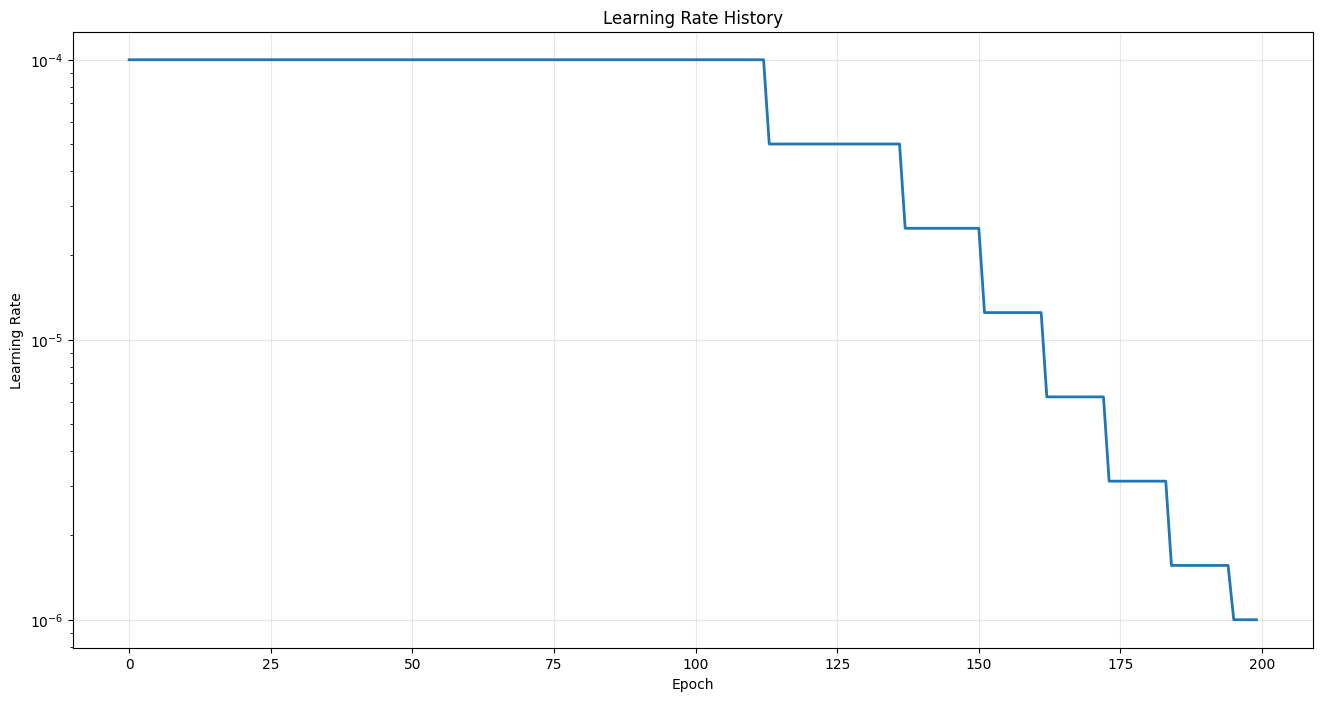

In [ ]:
# training

if __name__ == '__main__':
    parser = arg.ArgumentParser()
    parser.add_argument('--image_size', type=int, default=512)
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--freeze_encoder', type=bool, default=False)
    parser.add_argument('--dropout', type=float, default=0.01)
    parser.add_argument('--epochs', type=int, default=200)
    parser.add_argument('--learning_rate', type=float, default=1e-4)
    parser.add_argument('--weight_decay', type=float, default=0.01)
    parser.add_argument('--bce_weight', type=float, default=0.5)
    parser.add_argument('--dice_weight', type=float, default=1.0)
    parser.add_argument('--tversky_weight', type=float, default=2.0)
    parser.add_argument('--focal_weight', type=float, default=1.0),
    parser.add_argument('--thin_weight', type=float, default=2.5)
    parser.add_argument('--edge_weight', type=float, default=1.5)
    parser.add_argument('--threshold', type=float, default=0.5)
    parser.add_argument('--save_dir', type=str, default='segmentation_results')
    parser.add_argument('--save_freq', type=int, default=5)
    parser.add_argument('--save_vis', type=int, default=5)
    parser.add_argument('--device', type=str, default='cuda')

    args, _ = parser.parse_known_args()

    device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    save_predictions_dir = f'/content/drive/MyDrive/{args.save_dir}/visualizations'
    save_checkpoints_dir = f'/content/drive/MyDrive/{args.save_dir}/checkpoints'
    save_model_dir = f'/content/drive/MyDrive/{args.save_dir}/models'
    save_graphs_dir = f'/content/drive/MyDrive/{args.save_dir}/graphs'
    os.makedirs(save_graphs_dir, exist_ok=True)
    os.makedirs(save_model_dir, exist_ok=True)
    os.makedirs(save_checkpoints_dir, exist_ok=True)
    os.makedirs(save_predictions_dir, exist_ok=True)
    print(f'Saving graphs to {save_graphs_dir}')
    print(f'Saving predictions to {save_predictions_dir}')
    print(f'Saving models to {save_model_dir}')
    print(f'Saving checkpoints to {save_checkpoints_dir}')

    print('\n' + '='*60)
    print('Loading Pretrained MAE')
    print('='*60)

    mae = MAE(
        512,
        16,
        1,
        768,
        8,
        8,
        512,
        4,
        8,
        mask_ratio=0.5
        )
    state = torch.load('/content/drive/MyDrive/MAE_pretrain_results/final_pretrain_model.pth', weights_only=False,map_location=device)
    mae.load_state_dict(state['model_state_dict'])
    mae.to(device)

    train_loss_history = state['history']
    last_train_loss = train_loss_history['train_loss'][-1]
    last_mse_loss = train_loss_history['train_mse'][-1]
    last_edge_loss = train_loss_history['train_edge'][-1]

    print(f'✓ Loaded MAE from epoch {state['epoch']}')
    print(f' Final pretrain loss: {last_train_loss:.4f}')
    print(f' Final pretrain MSE loss: {last_mse_loss:.4f}')
    print(f' Final pretrain edge loss: {last_edge_loss:.4f}')

    print('\n' + '='*60)
    print('Creating Segmentation Model')
    print('='*60)

    model = VesselSegmentationModel(
        mae_model = mae,
        freeze_encoder = args.freeze_encoder,
        dropout = args.dropout
    )

    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f'Total parameters: {total_params/1e6:.1f}M')
    print(f'Total trainable paraemeters: {trainable_params/1e6:.1f}M')

    print('\n' + '='*60)
    print('Loading Data')
    print('='*60)

    train_data_loader = torch.utils.data.DataLoader(VesselSegmentationDataset('train'), batch_size=args.batch_size, num_workers=args.num_workers, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(VesselSegmentationDataset('test'), batch_size=args.batch_size, num_workers=args.num_workers, shuffle=True)

    print('\n Testing Train Dataset')
    image, mask = next(iter(train_data_loader))
    print(f' Batch: Image {image.shape}, Mask {mask.shape}')

    print('\n Testing Test Dataset')
    image, mask = next(iter(test_data_loader))
    print(f' Batch: Image {image.shape}, Mask {mask.shape}')

    print(f'\n ✓ Loaded {len(train_data_loader)} batches of training images.')
    print(f'✓ Loaded {len(test_data_loader)} batches of testing images.')

    print('\n' + '='*60)
    print('Training')
    print('='*60)

    criterion = CombinedSegmentationLoss(
    bce_weight=0.5,
    dice_weight=1.0,
    tversky_weight=2.5,
    focal_weight=1.0,
    thin_weight=2.5,
    edge_weight=0.0,
    tversky_alpha=0.2,
    tversky_beta=0.8,
    ).to(device)


    criterion = criterion.to(device)

    threshold = args.threshold

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=args.learning_rate,
        weight_decay=args.weight_decay
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=10,
        min_lr=1e-6
        )

    print('✓ Loss function: Combined (BCE + Dice + Tversky + Focal)')
    print(f'✓ Optimizer: AdamW (lr={args.learning_rate})')
    print('✓ Scheduler: ReduceLROnPlateau')

    best_f1 = 0
    history = {'train': [], 'val': [], 'lr': []}

    for epoch in range(1, args.epochs + 1):
      print(f'\n Epoch {epoch}/{args.epochs}')
      print('-'*60)

      train_results = train_epoch(
          model, train_data_loader, optimizer, criterion, device, epoch
      )

      print(f"\nTrain Results:")
      print(f"  Loss: {train_results['losses']['total']:.4f}")
      print(f"    ├─ BCE: {train_results['losses']['bce']:.4f}")
      print(f"    ├─ Dice: {train_results['losses']['dice']:.4f}")
      print(f"    ├─ Tversky: {train_results['losses']['tversky']:.4f}")
      print(f"    ├─ Thin Weighted: {train_results['losses']['thin_weighted']:.4f} ← Key!")
      print(f"    ├─ Edge: {train_results['losses']['edge']:.4f}")
      print(f"    └─ Focal: {train_results['losses']['focal']:.4f}")
      print(f"  F1: {train_results['metrics']['f1']:.4f} | "
            f"Precision: {train_results['metrics']['precision']:.4f} | "
            f"Recall: {train_results['metrics']['recall']:.4f}")
      history['train'].append(train_results)

      val_results = validate(model, test_data_loader, criterion, device, threshold)
      history['val'].append(val_results)

      print(f"\nValidation Results:")
      print(f"  Loss: {val_results['losses']['total']:.4f}")
      print(f"  F1: {val_results['metrics']['f1']:.4f} | "
            f"Precision: {val_results['metrics']['precision']:.4f} | "
            f"Recall: {val_results['metrics']['recall']:.4f}")

        # Save best model
      if val_results['metrics']['f1'] > best_f1:
          best_f1 = val_results['metrics']['f1']
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'f1': val_results['metrics']['f1'],
              'iou': val_results['metrics']['iou'],
              'dice': val_results['metrics']['dice'],
          }, os.path.join(save_model_dir, 'best_model.pth'))
          print(f'✓ Best model saved (F1: {best_f1:.4f})')

      # Update learning rate
      scheduler.step(val_results['metrics']['f1'])
      current_lr = optimizer.param_groups[0]['lr']
      history['lr'].append(current_lr)
      print(f'✓ Learning rate updated to {current_lr:.2e}')

      # Visualize
      if epoch % args.save_vis == 0:
          vis_path = os.path.join(save_predictions_dir, f'predictions_epoch_{epoch:03d}.png')
          visualize_predictions(model, test_data_loader, device, vis_path, threshold)

      # Save checkpoint
      if epoch % args.save_freq == 0:
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'history': history,
          }, os.path.join(save_checkpoints_dir, f'checkpoint_epoch_{epoch:03d}.pth'))


    plt.figure(figsize=(16,8))
    plt.plot(history['lr'], linewidth=2)
    plt.title('Learning Rate History')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_graphs_dir, 'lr_schedule.png'))

    print('\n' + '='*60)
    print(f'Training Complete! Best F1: {best_f1:.4f}')
    print('='*60)

✓ Loaded MAE from epoch 169
✓ Encoder unfrozen - fine-tuning entire model
✓ Loaded segmentation model from epoch 141


/tmp/ipython-input-3346674571.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


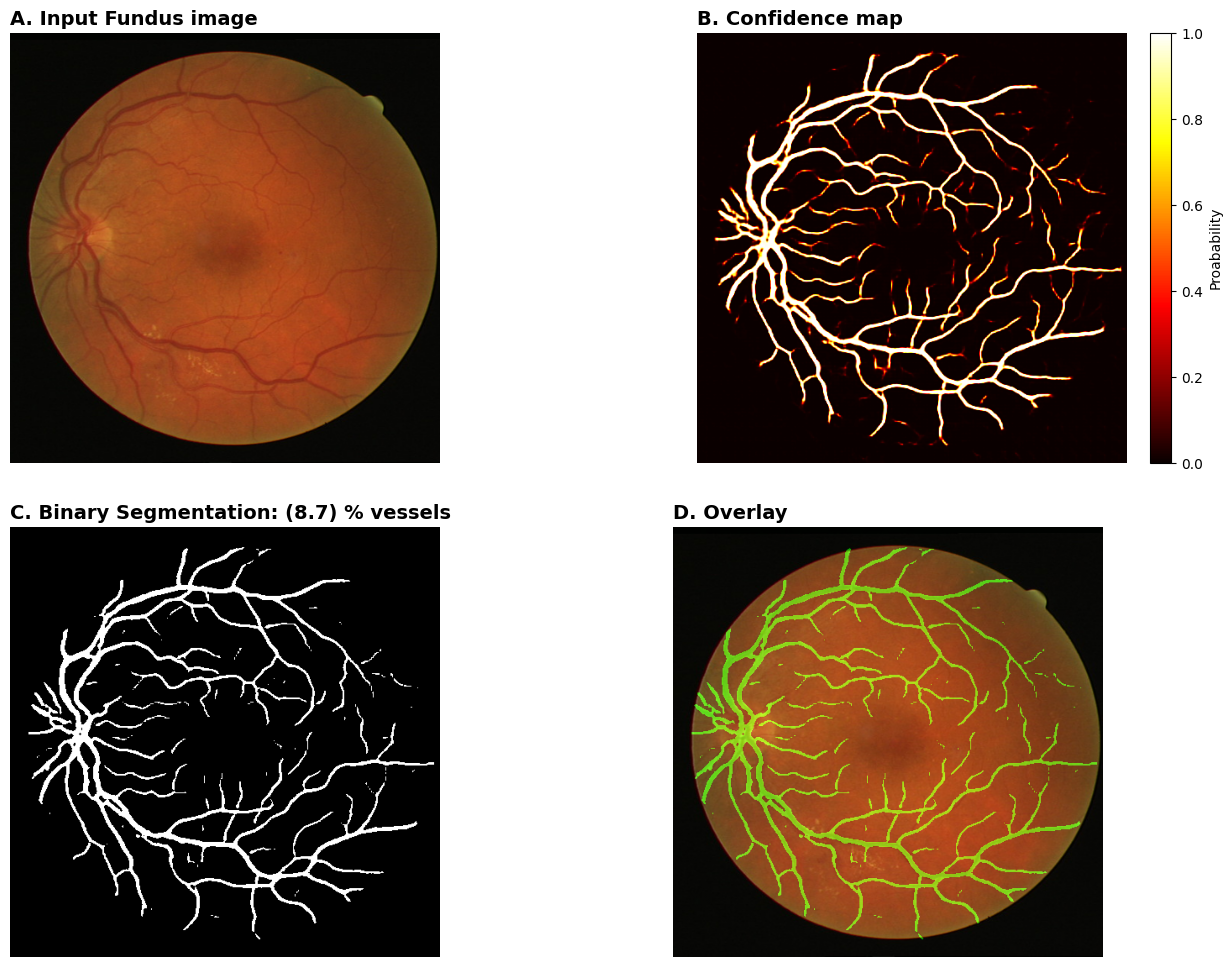

In [ ]:
pretrained_encoder = os.path.join('/content/drive/MyDrive/' , 'MAE_pretrain_results/' ,'final_pretrain_model.pth')
trained_decoder = os.path.join('/content/drive/MyDrive/segmentation_results/', 'models', 'best_model.pth' )

mae = MAE(
    512, # image-size
    16, # patch-size
    1, # in_channels
    768, # embed_dim
    8, # encoder heads
    8, # encoder layers
    512, # decoder dim
    4, # depth
    8, # heads
    mask_ratio=0.5 # mask_ratio
)
state = torch.load(pretrained_encoder, weights_only=False, map_location=torch.device('cuda'))
mae.load_state_dict(state['model_state_dict'])
mae.to(torch.device('cuda'))

print(f'✓ Loaded MAE from epoch {state['epoch']}')


vessel_segmentation = VesselSegmentationModel(
    mae_model = mae,
    freeze_encoder = False,
    dropout = 0.1
)
state = torch.load(trained_decoder, weights_only=False, map_location=torch.device('cuda'))
vessel_segmentation.load_state_dict(state['model_state_dict'])
vessel_segmentation.to(torch.device('cuda'))

print(f'✓ Loaded segmentation model from epoch {state['epoch']}')

test_img = cv2.imread('/content/drive/MyDrive/DRIVE/test/images/03_test.tif')
test_img = cv2.resize(test_img, (512,512))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

def preprocess_image(image, transform):
    green_channel = image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gaussian_blur = cv2.GaussianBlur(green_channel, (5, 5), 0.5)
    clahe_image = clahe.apply(gaussian_blur)

    transformed = transform(image=clahe_image)
    return transformed['image']

if __name__ == '__main__':
    img_tensor = preprocess_image(test_img, get_transforms('test'))

    if img_tensor.ndim == 3:
      img_tensor = img_tensor.unsqueeze(0)

    img_tensor = img_tensor.to(torch.device('cuda'))

    with torch.no_grad():
      outputs = vessel_segmentation(img_tensor)
      preds_prob = torch.sigmoid(outputs)
      pred_binary = (preds_prob > 0.5).float()

    pred = pred_binary[0,0].cpu().numpy()
    pred_prob = preds_prob[0,0].cpu().numpy()

    fig = plt.figure(figsize=(16,12))
    gs = fig.add_gridspec(2,2,hspace=0.15, wspace=0.15)

    # Panel 1: Original
    ax1 = fig.add_subplot(gs[0,0])
    ax1.imshow(test_img)
    ax1.set_title('A. Input Fundus image', fontsize=14, fontweight='bold', loc='left')
    ax1.axis('off')

    # Panel 2: Proabablity map (shows confidence)

    ax2 = fig.add_subplot(gs[0,1])
    im = ax2.imshow(pred_prob, cmap='hot', vmin=0, vmax=1)
    ax2.set_title('B. Confidence map', fontsize=14, fontweight='bold', loc='left')
    ax2.axis('off')
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04, label='Proabability')

    # Panel 3: Binary Segmentation
    ax3 = fig.add_subplot(gs[1,0])
    ax3.imshow(pred, cmap='gray')
    ax3.set_title(f'C. Binary Segmentation: ({pred.mean()*100:.1f}) % vessels', fontsize=14, fontweight='bold', loc='left')
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[1,1])
    overlay = test_img.astype(float) / 255.0
    overlay[pred>0.5,1] = np.clip(overlay[pred > 0.5,1] + 0.6, 0, 1)
    ax4.imshow(overlay)
    ax4.set_title('D. Overlay', fontsize=14, fontweight='bold', loc='left')
    ax4.axis('off')

    plt.tight_layout()
    plt.savefig('vessel_segmentation.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
